In [1]:
import numpy as np
import pandas as pd
from functools import reduce

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from pylab import rcParams # rcParams['figure.figsize']

In [3]:
import pymysql
import csv
import xlrd
from datetime import datetime

In [4]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from collections import OrderedDict # 進度條

In [5]:
# load data
View_Bets_20180801_to_20181031 = pd.read_excel("/Users/johnsonhuang/py_ds/WebCrawler_matador/View_Bets_20180801_to_20181031_extend_version.xlsx")
View_Bets_20181101_to_20190216 = pd.read_excel("/Users/johnsonhuang/py_ds/WebCrawler_matador/View_Bets_20181101_to_20190216_extend_version.xlsx")


In [6]:
# concat all - ignore_index=True，否則會把DF變成每個row都是Series
df_raw_data = pd.concat([View_Bets_20180801_to_20181031, View_Bets_20181101_to_20190216], axis = 0, ignore_index=True)
View_Bets_20180801_to_20181031 = None
View_Bets_20181101_to_20190216 = None

In [7]:
# drop duplicates
df_raw_data = df_raw_data.drop_duplicates(keep = 'first')

In [8]:
# view head
df_raw_data.head(5)

,Member,Placed,Selection,Bet_ID,In_Play,One_Click,Type,Odds,Stake,Status,Member_Win_Loss,Agent_Win_Loss,MA_Win_Loss,CUS_Win_Loss,http
0,karan123456 (MTDR0G04M02),31/10/2018 00:07:34,Clergyman,1810301607342310,N,N,Lay,5.200,500.00,WON,500.00,0.00,-250.00,0.00,https://admin.matador.games/index.html#/report...
1,karan123456 (MTDR0G04M02),31/10/2018 00:02:07,Out For Justice,1810301602071190,Y,N,Lay,4.783,500.00,WON,500.00,0.00,-250.00,0.00,https://admin.matador.games/index.html#/report...
2,karan123456 (MTDR0G04M02),31/10/2018 00:32:40,Westerly Wind,1810301632408179,Y,N,Lay,5.000,500.00,WON,500.00,0.00,-250.00,0.00,https://admin.matador.games/index.html#/report...
3,karan123456 (MTDR0G04M02),31/10/2018 20:49:05,Gold Runner,1810311249051042,N,N,Back,350.065,75.00,LOST,-75.00,0.00,37.50,0.00,https://admin.matador.games/index.html#/report...
4,karan123456 (MTDR0G04M02),31/10/2018 20:49:16,Weve Got Payet,1810311249161088,N,N,Back,180.000,100.00,LOST,-100.00,0.00,50.00,0.00,https://admin.matador.games/index.html#/report...


In [9]:
df_raw_data.shape

(77848, 15)

In [10]:
len(set(df_raw_data["Member"]))

145

In [11]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77848 entries, 0 to 92052
Data columns (total 15 columns):
Member             77848 non-null object
Placed             77848 non-null object
Selection          77847 non-null object
Bet_ID             77848 non-null int64
In_Play            77848 non-null object
One_Click          77848 non-null object
Type               77848 non-null object
Odds               77848 non-null object
Stake              77848 non-null object
Status             77848 non-null object
Member_Win_Loss    77848 non-null object
Agent_Win_Loss     77848 non-null object
MA_Win_Loss        77848 non-null object
CUS_Win_Loss       77848 non-null object
http               77848 non-null object
dtypes: int64(1), object(14)
memory usage: 9.5+ MB


In [12]:
df_raw_data.isnull().sum()

Member             0
Placed             0
Selection          1
Bet_ID             0
In_Play            0
One_Click          0
Type               0
Odds               0
Stake              0
Status             0
Member_Win_Loss    0
Agent_Win_Loss     0
MA_Win_Loss        0
CUS_Win_Loss       0
http               0
dtype: int64

-------------------

## Preprocessing

In [13]:
df_preprocess = df_raw_data.copy()#.head(100)

In [14]:
# df_raw_data = None

In [15]:
# Member : shiv2424 (MTDR0901M02)

# 變成
# Member : shiv2424
# Mem_Info_1 : MTDR0901
# Mem_Info_2 : M02

df_preprocess["Mem_Info_1"] = df_preprocess["Member"].apply(lambda x : (x.split(" ")[1].replace("(", "").replace(")", ""))[0:-3])
df_preprocess["Mem_Info_2"] = df_preprocess["Member"].apply(lambda x : (x.split(" ")[1].replace("(", "").replace(")", ""))[-3:])
df_preprocess["Member"] = df_preprocess["Member"].apply(lambda x : x.split("(")[0].replace(" ", ""))
# df_preprocess.head(5)


> 時間可透過IP對應到國家，比對該時區來看是否為該地區的假日等資訊

In [16]:
# Placed : 2019-01-01 23:57:48

# 變成
# Placed_Year : 2019
# Placed_Month : 1
# Placed_Date : 1
# Placed_Day_of_Week : 1
# Placed_Hour : 23
# Placed_Minute : 57

# to datetime
df_preprocess['Placed_dt'] = pd.to_datetime(df_preprocess['Placed'], dayfirst = True) # 預設是dayfirst = False
# 抓資料的時候採台灣時間，改為UTC時間
df_preprocess["Placed_dt"] = df_preprocess["Placed_dt"] - pd.Timedelta(hours=8)


df_preprocess['Placed_Year'] = df_preprocess['Placed_dt'].dt.year
df_preprocess['Placed_Month'] = df_preprocess['Placed_dt'].dt.month
df_preprocess['Placed_Date'] = df_preprocess['Placed_dt'].dt.day
df_preprocess['Placed_Day_of_Week'] = df_preprocess['Placed_dt'].dt.dayofweek # 0 1 2 3 4 5 6
df_preprocess['Placed_Hour'] = df_preprocess['Placed_dt'].dt.hour
df_preprocess['Placed_Minute'] = df_preprocess['Placed_dt'].dt.minute
df_preprocess["Placed"] = df_preprocess["Placed"].astype(str)

# df_preprocess.head(5)

In [17]:
# Odds
# Stake
# Member_Win_Loss
# Agent_Win_Loss
# MA_Win_Loss
# CUS_Win_Loss

df_preprocess["Odds"] = df_preprocess["Odds"].apply(lambda x : x.replace(",", "").replace("\n(reduced)", "")).astype("float32")
df_preprocess["Stake"] = df_preprocess["Stake"].apply(lambda x : x.replace(",", "")).astype("float32")
df_preprocess["Member_Win_Loss"] = df_preprocess["Member_Win_Loss"].apply(lambda x : x.replace(",", "")).replace("--", np.nan).astype("float32")
df_preprocess["Agent_Win_Loss"] = df_preprocess["Agent_Win_Loss"].apply(lambda x : x.replace(",", "")).replace("--", np.nan).astype("float32")
df_preprocess["MA_Win_Loss"] = df_preprocess["MA_Win_Loss"].apply(lambda x : x.replace(",", "")).replace("--", np.nan).astype("float32")
df_preprocess["CUS_Win_Loss"] = df_preprocess["CUS_Win_Loss"].apply(lambda x : x.replace(",", "")).replace("--", np.nan).astype("float32")
# df_preprocess


In [18]:
# # Stake - 幣值轉換，Betfair是用英鎊的樣子


# df_preprocess["Stake"] = df_preprocess["Stake"].apply(lambda x : x.replace(",", "")).astype("float32")

In [19]:
# In_Play
# One_Click

df_preprocess["In_Play"] = df_preprocess["In_Play"].replace({"N": "0", "Y": "1"}, regex = True).astype("int32")
df_preprocess["One_Click"] = df_preprocess["One_Click"].replace({"N": "0", "Y": "1"}, regex = True).astype("int32")

# df_preprocess

### VOID

> A void transaction is a debit or credit card purchase that is canceled after it has been authorized but before it has been settled. 

> A void transaction does not appear on the customer’s account statement, though it might appear in a list of pending transactions when the customer checks their account online.


https://www.investopedia.com/terms/v/void-transaction.asp


In [20]:
# One Hot Encoding

# Type
# Status

Type_dummies = pd.get_dummies(df_preprocess['Type'], prefix = "Type")
Status_dummies = pd.get_dummies(df_preprocess['Status'], prefix = "Status")

df_preprocess = pd.concat([df_preprocess, Type_dummies, Status_dummies], axis = 1) # df_test = df_preprocess.join(Type_dummies).join(Status_dummies)



In [21]:
# http

df_preprocess["http_Info_1"] = df_preprocess["http"].apply(lambda x : x.split("/")[-3])
df_preprocess["http_Info_2"] = df_preprocess["http"].apply(lambda x : x.split("/")[-2])
df_preprocess["http_Info_3"] = df_preprocess["http"].apply(lambda x : x.split("/")[-1])
# df_preprocess.head()

## 檢視VOID, INVALID，去除這些資料

In [22]:
# 用戶出現 VOID or INVALID 的次數
df_suspicious_rec = df_preprocess.loc[df_preprocess["Status"].isin(["VOID", "INVALID"]), : ]
df_suspicious_0 = df_suspicious_rec.groupby(["Member"])["Bet_ID"].count().reset_index().sort_values(by = "Bet_ID", ascending = False)

# 用戶出現 VOID 的次數
df_suspicious_rec = df_preprocess.loc[df_preprocess["Status"].isin(["VOID"]), : ]
df_suspicious_1 = df_suspicious_rec.groupby(["Member"])["Bet_ID"].count().reset_index().sort_values(by = "Bet_ID", ascending = False)

# 用戶出現 INVALID 的次數
df_suspicious_rec = df_preprocess.loc[df_preprocess["Status"].isin(["INVALID"]), : ]
df_suspicious_2 = df_suspicious_rec.groupby(["Member"])["Bet_ID"].count().reset_index().sort_values(by = "Bet_ID", ascending = False)

# 各用戶總下注次數
df_allrecord = df_preprocess.groupby(["Member"])["Bet_ID"].count().reset_index().sort_values(by = "Bet_ID", ascending = False)
df_allrecord.columns = ["Member", "all_records"]

# merge - VOID_num	INVALID_num 	 suspicious_rec 	 all_records	suspicious_rate
dfs = [df_suspicious_0, df_suspicious_1, df_suspicious_2, df_allrecord]
df_suspicious_rec = reduce(lambda left,right: pd.merge(left, right, how = "left", on = ["Member"]), dfs)
df_suspicious_rec.columns = ["Member", "suspicious_rec", "VOID_num", "INVALID_num", "all_records"]
# adjust order of columns
df_suspicious_rec = pd.DataFrame(df_suspicious_rec, columns = ["Member", "VOID_num", "INVALID_num", "suspicious_rec", "all_records"])
df_suspicious_rec["suspicious_rate"] = df_suspicious_rec["suspicious_rec"] / df_suspicious_rec["all_records"]
# sort by suspicious_rate, all_records
df_suspicious_rec = df_suspicious_rec.sort_values(by = ["all_records", "suspicious_rate"], ascending = [False, False])

# df_suspicious_rec.dropna(how = 'any')
# df_suspicious_rec


In [23]:
df_suspicious_rec

,Member,VOID_num,INVALID_num,suspicious_rec,all_records,suspicious_rate
0,bird26,104.0,6.0,110,6538,0.016825
3,am121,58.0,5.0,63,6419,0.009815
10,ddlj01,33.0,1.0,34,5637,0.006032
5,am113,55.0,4.0,59,5063,0.011653
9,js999,35.0,NaN,35,4028,0.008689
2,bird27,72.0,NaN,72,3348,0.021505
7,am902,39.0,4.0,43,2960,0.014527
16,king09,24.0,NaN,24,2560,0.009375
11,am901,33.0,NaN,33,1973,0.016726
12,jumper01,31.0,1.0,32,1801,0.017768


In [24]:
df_suspicious_rec.loc[((df_suspicious_rec["suspicious_rec"] > np.percentile(df_suspicious_rec["suspicious_rec"], 80)) & \
                (df_suspicious_rec["suspicious_rate"] > np.percentile(df_suspicious_rec["suspicious_rate"], 80))\
              | (df_suspicious_rec["suspicious_rec"] > np.percentile(df_suspicious_rec["suspicious_rec"], 95))), :]


,Member,VOID_num,INVALID_num,suspicious_rec,all_records,suspicious_rate
0,bird26,104.0,6.0,110,6538,0.016825
2,bird27,72.0,NaN,72,3348,0.021505
1,am333,76.0,1.0,77,917,0.083969
6,bird29,47.0,NaN,47,590,0.079661
8,am905,41.0,NaN,41,425,0.096471


In [25]:
# VOID, INVALID
VO_INV_mem = \
df_suspicious_rec.loc[((df_suspicious_rec["suspicious_rec"] > np.percentile(df_suspicious_rec["suspicious_rec"], 80)) & \
                (df_suspicious_rec["suspicious_rate"] > np.percentile(df_suspicious_rec["suspicious_rate"], 80))\
              | (df_suspicious_rec["suspicious_rec"] > np.percentile(df_suspicious_rec["suspicious_rec"], 95))), :]["Member"].tolist()
VO_INV_mem


['bird26', 'bird27', 'am333', 'bird29', 'am905']

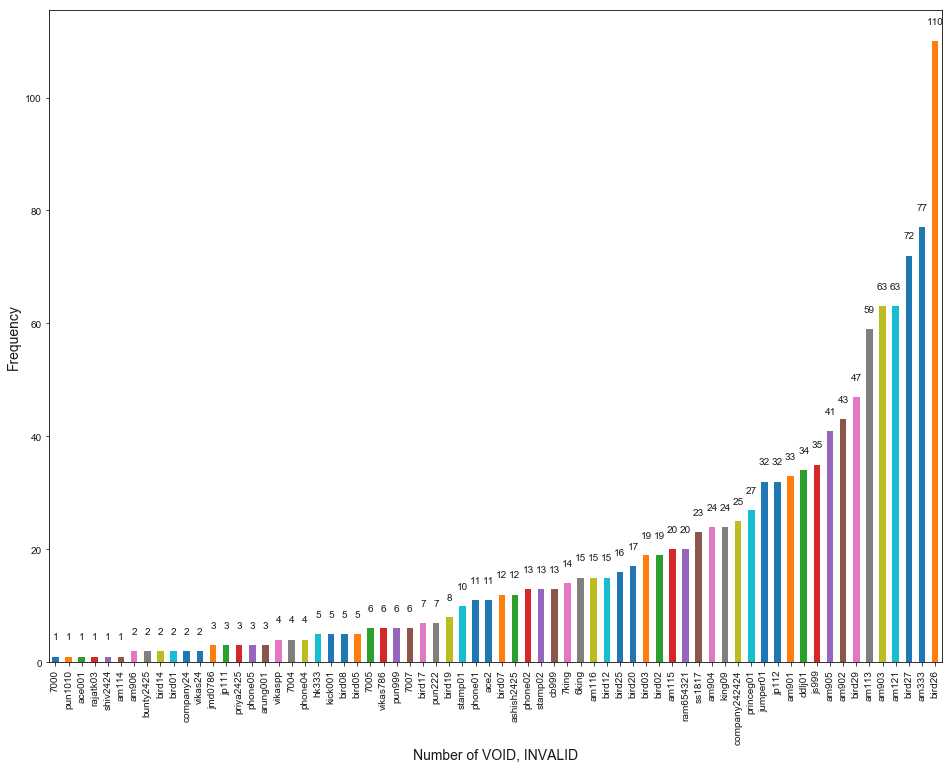

In [26]:
fig, ax = plt.subplots(figsize=(16, 12))

# total = float(len(df_suspicious_0)) 
# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
ax = df_suspicious_0.groupby(["Member"])['Bet_ID'].sum().sort_values().plot(kind='bar') # sns.countplot(df_suspicious_0['Status'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}'.format(height),   # '{:1.2f}'.format(height/total),
            ha="center") 

ax.set_xlabel('Number of VOID, INVALID',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)   

sns.set(font_scale=1.5) # font size
sns.set(style="darkgrid")
plt.xticks(rotation=90) # x-axis 字體方向
plt.show()



In [27]:
# release
df_suspicious_0, df_suspicious_1, df_suspicious_2, df_allrecord = None, None, None, None

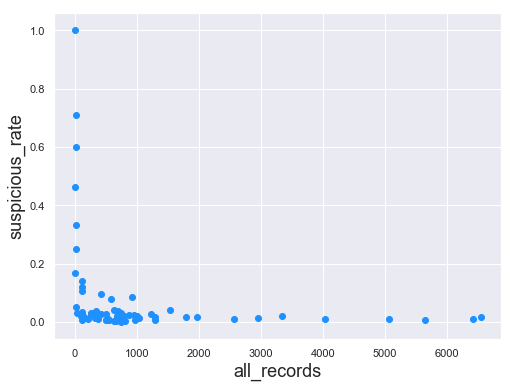

In [28]:
# plot - scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.scatter(df_suspicious_rec["all_records"], df_suspicious_rec["suspicious_rate"], marker='o', color='dodgerblue')

sns.set(font_scale = 1.5) # font size
plt.xlabel('all_records', fontsize = 18) # ax.set_xlabel('Status, Type',fontsize=14)
plt.ylabel('suspicious_rate', fontsize = 18) # ax.set_ylabel('Member_Win_Loss',fontsize=14) 

plt.style.use('ggplot')
plt.show()


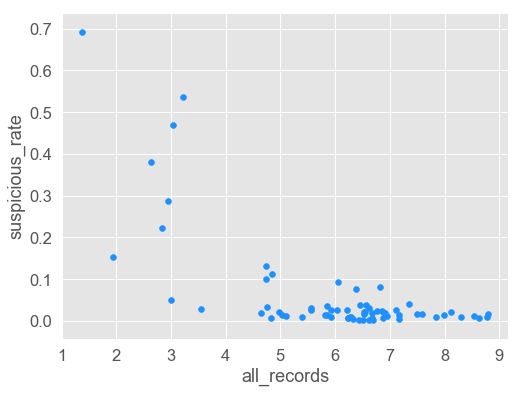

In [29]:
# View by log transform

# plot - scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.scatter(np.log1p(df_suspicious_rec["all_records"]), np.log1p(df_suspicious_rec["suspicious_rate"]), marker='o', color='dodgerblue')

sns.set(font_scale = 1.5) # font size
plt.xlabel('all_records', fontsize = 18) # ax.set_xlabel('Status, Type',fontsize=14)
plt.ylabel('suspicious_rate', fontsize = 18) # ax.set_ylabel('Member_Win_Loss',fontsize=14) 

plt.style.use('ggplot')
plt.show()


In [30]:
np.log1p(df_suspicious_rec["all_records"])

0     8.785540
3     8.767173
10    8.637285
5     8.529912
9     8.301273
2     8.116417
7     7.993282
16    7.848153
11    7.587817
12    7.496652
4     7.341484
19    7.170888
39    7.167038
13    7.121252
29    6.946014
21    6.918695
22    6.898715
42    6.875232
17    6.861711
1     6.822197
20    6.771936
58    6.700731
27    6.672033
40    6.669498
18    6.622736
65    6.616065
14    6.559615
25    6.541030
34    6.532334
28    6.527958
        ...   
54    6.228511
31    6.214608
8     6.054439
35    6.042633
48    5.932245
36    5.926926
46    5.855072
30    5.852202
44    5.814131
37    5.556828
38    5.556828
59    5.402677
60    5.099866
57    5.023881
55    4.969813
26    4.852030
67    4.836282
50    4.753590
24    4.736198
33    4.736198
61    4.653960
63    3.555348
23    3.218876
32    3.044522
66    2.995732
41    2.944439
49    2.833213
43    2.639057
64    1.945910
53    1.386294
Name: all_records, Length: 68, dtype: float64

In [31]:
# condition 1

In [32]:
# View by log transform
df_suspicious_rec.loc[(np.log1p(df_suspicious_rec["suspicious_rate"]) > 0.05) & (np.log1p(df_suspicious_rec["all_records"]) < 4), :]

df_suspicious_mem = df_suspicious_rec.loc[(np.log1p(df_suspicious_rec["suspicious_rate"]) > 0.05) & (np.log1p(df_suspicious_rec["all_records"]) < 4), ["Member"]]
# list of suspicious_mem
list_suspicious_mem = df_suspicious_mem["Member"].values.tolist()
list_suspicious_mem


['bird20',
 'ashish2425',
 'pun1010',
 '7005',
 '7004',
 '7007',
 '7000',
 'priya2425']

In [33]:
df_suspicious_rec.loc[df_suspicious_rec["Member"].isin(list_suspicious_mem), :]

,Member,VOID_num,INVALID_num,suspicious_rec,all_records,suspicious_rate
23,bird20,17.0,NaN,17,24,0.708333
32,ashish2425,NaN,12.0,12,20,0.600000
66,pun1010,1.0,NaN,1,19,0.052632
41,7005,NaN,6.0,6,18,0.333333
49,7004,NaN,4.0,4,16,0.250000
43,7007,NaN,6.0,6,13,0.461538
64,7000,NaN,1.0,1,6,0.166667
53,priya2425,NaN,3.0,3,3,1.000000


In [34]:
# condition 2

In [35]:
# View by log transform
df_suspicious_rec.loc[(np.log1p(df_suspicious_rec["suspicious_rate"]) > 0.05) & (np.log1p(df_suspicious_rec["all_records"]) > 4), :]

df_suspicious_mem = df_suspicious_rec.loc[(np.log1p(df_suspicious_rec["suspicious_rate"]) > 0.05) & (np.log1p(df_suspicious_rec["all_records"]) > 4), ["Member"]]
# list of suspicious_mem
list_suspicious_mem = df_suspicious_mem["Member"].values.tolist()
list_suspicious_mem


['am333', 'bird29', 'am905', '6king', 'bird25', 'bird07']

In [36]:
df_suspicious_rec.loc[df_suspicious_rec["Member"].isin(list_suspicious_mem), :]

,Member,VOID_num,INVALID_num,suspicious_rec,all_records,suspicious_rate
1,am333,76.0,1.0,77,917,0.083969
6,bird29,47.0,NaN,47,590,0.079661
8,am905,41.0,NaN,41,425,0.096471
26,6king,15.0,NaN,15,127,0.118110
24,bird25,16.0,NaN,16,113,0.141593
33,bird07,12.0,NaN,12,113,0.106195


In [37]:
df_preprocess.ix[(df_preprocess["Member"].isin(list_suspicious_mem)) & (df_preprocess["Status"].isin(["VOID", "INVALID"])), 0:14]


/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,Member,Placed,Selection,Bet_ID,In_Play,One_Click,Type,Odds,Stake,Status,Member_Win_Loss,Agent_Win_Loss,MA_Win_Loss,CUS_Win_Loss
2040,bird29,26/10/2018 21:39:09,161 Runs,1810261339089234,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0
2041,bird29,26/10/2018 21:39:15,161 Runs,1810261339149289,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0
2042,bird29,26/10/2018 21:39:19,161 Runs,1810261339179313,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0
2043,bird29,26/10/2018 21:39:23,161 Runs,1810261339229360,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0
2044,bird29,26/10/2018 21:39:27,161 Runs,1810261339259398,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0
2047,bird29,26/10/2018 21:37:45,47 Runs,1810261337448302,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0
2048,bird29,26/10/2018 21:37:52,47 Runs,1810261337518423,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0
2049,bird29,26/10/2018 21:37:56,47 Runs,1810261337558488,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0
2050,bird29,26/10/2018 21:38:02,47 Runs,1810261338018543,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0
2051,bird29,26/10/2018 21:38:07,47 Runs,1810261338068595,1,0,Yes,100.000,375.000000,VOID,0.0,0.0,0.0,0.0


In [38]:
df_preprocess.ix[(df_preprocess["Member"].isin(list_suspicious_mem)) & (df_preprocess["Status"].isin(["VOID", "INVALID"])), 0:14].shape


/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(208, 14)

In [39]:
# df_suspicious_rec.dropna(how = 'any')

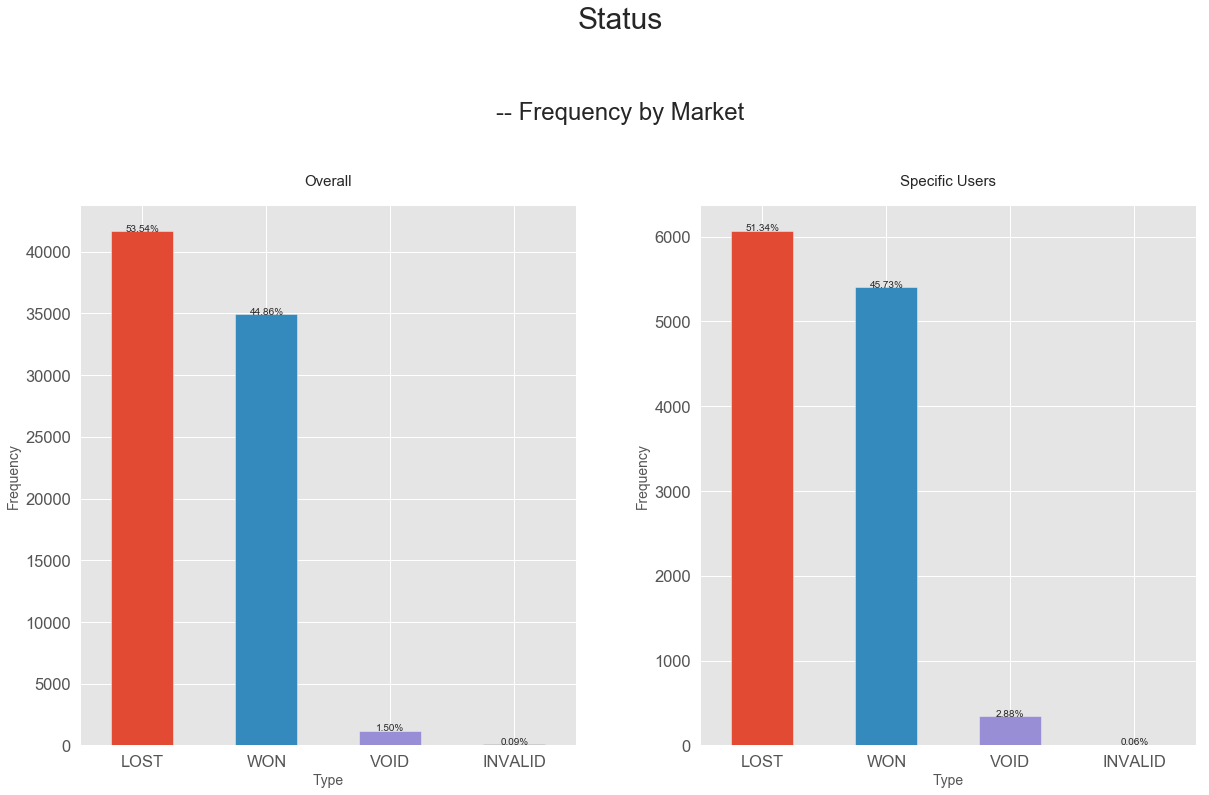

Specific Users : 
['bird26', 'bird27', 'am333', 'bird29', 'am905']


In [40]:
fig, (ax) = plt.subplots(1,2, figsize = (20, 12))


# plot 1-1


set_order = ["LOST", "WON", "VOID", "INVALID"] # order of x-axis
ax[0] = df_preprocess.groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[0]) 
total = float(len(df_preprocess)) 
for p in ax[0].patches:
    height = p.get_height()
    ax[0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0].set_title("Overall", size = 15, pad = 20)
ax[0].set_xlabel('Type',fontsize=14)
ax[0].set_ylabel('Frequency',fontsize=14)   
#     ax[0].set_ylim([0, 30000])



# plot 1-2

set_order = ["LOST", "WON", "VOID", "INVALID"] # order of x-axis
ax[1] = df_preprocess[df_preprocess["Member"].isin(VO_INV_mem)].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[1]) 
total = float(len(df_preprocess[df_preprocess["Member"].isin(VO_INV_mem)])) 
for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1].set_title("Specific Users", size = 15, pad = 20)
ax[1].set_xlabel('Type',fontsize=14)
ax[1].set_ylabel('Frequency',fontsize=14)   
#     ax[1].set_ylim([0, 30000])


# control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
plt.style.use('ggplot')

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")

# x-axis 字體方向
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
        
plt.subplots_adjust(wspace = 0.25, hspace = 1)
# 總標題
fig.suptitle("Status", fontsize=30)
plt.text(x=0.5, y=0.85, s= "-- Frequency by Market", fontsize=24, ha="center", transform=fig.transFigure)

plt.subplots_adjust(top=0.75)
plt.show()

print("Specific Users : \n%s" % VO_INV_mem)




## discard rows which contain VOID, INVALID

In [41]:
# discard rows which contain VOID, INVALID
df_preprocess = df_preprocess.loc[~df_preprocess["Status"].isin(["VOID", "INVALID"]), : ]

In [42]:
# # df_preprocess - overall_winning_percentage

# a1 = df_preprocess.groupby(["Member"])["Bet_ID"].count().reset_index().sort_values(by = "Bet_ID", ascending = False)
# a1.columns = ["Member", "overall_Bet_num"]
# a2 = df_preprocess.groupby(["Member"])["Status_WON"].sum().reset_index().sort_values(by = "Status_WON", ascending = False)
# a2.columns = ["Member", "overall_WON_num"]

# a1 = pd.merge(a1, a2, how = "right", on = ["Member"])
# a1["overall_winning_percentage"] = a1["overall_WON_num"] / a1["overall_Bet_num"]
# a1.sort_values(by = "overall_winning_percentage", ascending = False)


# df_preprocess = pd.merge(df_preprocess, a1, how = "left", on = ["Member"])
# df_preprocess.head()


## Correlation Heat Map

In [43]:
# corr = df_preprocess.corr()

# f,ax = plt.subplots(figsize=(21,14)) # figure size
# sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax, cmap = "BuPu")
# plt.show()

In [44]:
# cols = ['Bet_ID', 'In_Play', 'One_Click',
#        'Odds', 'Stake', 'Member_Win_Loss', 'Agent_Win_Loss',
#        'MA_Win_Loss', 'CUS_Win_Loss', 'Mem_Info_1', 'Mem_Info_2',
#        'Placed_Year', 'Placed_Month', 'Placed_Date', 'Placed_Day_of_Week',
#        'Placed_Hour', 'Placed_Minute',
#        'Type_Back', 'Type_Lay', 'Type_No', 'Type_Yes',
#        'Status_INVALID', 'Status_LOST', 'Status_VOID', 'Status_WON']

# corr = df_preprocess[cols].corr()

# f,ax = plt.subplots(figsize=(30,20)) # figure size
# sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.5f',ax=ax, cmap = "BuPu")
# plt.show()

## 對照Navicat資料庫裡的 MarketAlls,  EventTypes,  EventAlls

In [45]:
#    從SQL選到Python
def read_sql_to_df(sql) :
    conn = pymysql.connect(host="snk-alpha.cluster-c4ajpvm491zl.eu-west-1.rds.amazonaws.com",    # your host, usually localhost
                           user="johnsonhuang",         # your username
                           passwd="Johnson111111huang",           # your password (Johnson111111huang)
                           db = "collection",    # name of the data base         
                           use_unicode=True, 
                           charset="utf8")
    
#     conn = pymysql.connect(host="127.0.0.1",    # your host, usually localhost
#                          user="root",         # your username
#                          passwd="",           # your password
#                          db = "matador",    # name of the data base         
#                          use_unicode=True, 
#                          charset="utf8")

    cur = conn.cursor()
    df = pd.read_sql(sql, conn)
    conn.close()
    return df

In [46]:
sql = """
select distinct sportBetfairMarketAlls.eventId as http_Info_2,
       sportBetfairMarketAlls.marketStartTime as marketStartTime,
       sportBetfairMarketAlls.totalMatched as totalMatched,
       sportBetfairEventTypes.eventTypeName as eventTypeName
from sportBetfairMarketAlls
left join sportBetfairEventTypes
on sportBetfairEventTypes.eventTypeId = sportBetfairMarketAlls.eventTypeId
where sportBetfairEventTypes.eventTypeId in (1,2,4,7,4339) 

and eventTypeName not in ("Horse Racing", "Greyhound Racing") 
and sportBetfairMarketAlls.marketTypeId in (1)
"""
# and sportBetfairMarketAlls.eventId not in ("29071290", "29089029", "29051452")

### 加上 and sportBetfairMarketAlls.marketTypeId in (1) 會少91筆eventid

a1 = read_sql_to_df(sql)


In [47]:
a1.shape

(19434, 4)

In [48]:
# a1.loc[a1["totalMatched"] != 0, :]

In [49]:
# select those only one marketStartTime
a2 = a1.groupby(["http_Info_2"])["marketStartTime"].count().reset_index()
a2 = a2.loc[a2["marketStartTime"] == 1, :]
a2 = a2.drop(["marketStartTime"], axis = 1)

In [50]:
# join a1, a2
a1 = pd.merge(a1, a2, how = "right", on = ["http_Info_2"])
a1.shape

(19416, 4)

In [51]:
# a1.loc[a1["http_Info_2"] == "29126375", :]

In [52]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76608 entries, 0 to 92052
Data columns (total 35 columns):
Member                76608 non-null object
Placed                76608 non-null object
Selection             76607 non-null object
Bet_ID                76608 non-null int64
In_Play               76608 non-null int32
One_Click             76608 non-null int32
Type                  76608 non-null object
Odds                  76608 non-null float32
Stake                 76608 non-null float32
Status                76608 non-null object
Member_Win_Loss       76608 non-null float32
Agent_Win_Loss        76608 non-null float32
MA_Win_Loss           76608 non-null float32
CUS_Win_Loss          76608 non-null float32
http                  76608 non-null object
Mem_Info_1            76608 non-null object
Mem_Info_2            76608 non-null object
Placed_dt             76608 non-null datetime64[ns]
Placed_Year           76608 non-null int64
Placed_Month          76608 non-null int64
Pl

## 總table -  df_preprocess_eventall  - 對應到各賽事名稱

In [53]:
df_preprocess_eventall = df_preprocess[["http_Info_2"]]

In [54]:
df_preprocess_eventall = pd.merge(df_preprocess, a1, how = "inner", on = ["http_Info_2"])

In [55]:
print(df_preprocess_eventall.shape)
df_preprocess_eventall#.head()

(23969, 38)


,Member,Placed,Selection,Bet_ID,In_Play,One_Click,Type,Odds,Stake,Status,...,Status_INVALID,Status_LOST,Status_VOID,Status_WON,http_Info_1,http_Info_2,http_Info_3,marketStartTime,totalMatched,eventTypeName
0,rajeshg01,16/02/2019 20:11:28,Under 0.5 Goals,1902161211288456,1,0,Lay,1.559,6000.000000,LOST,...,0,1,0,0,MTDR0G,29126375,MTDR,2019-02-16 10:30:00,420.49,Soccer
1,rajeshg01,16/02/2019 20:14:28,Under 0.5 Goals,1902161214280577,1,0,Back,1.370,11.380000,WON,...,0,0,0,1,MTDR0G,29126375,MTDR,2019-02-16 10:30:00,420.49,Soccer
2,rajeshg01,16/02/2019 20:14:46,Under 0.5 Goals,1902161214460814,1,0,Back,1.335,6000.000000,WON,...,0,0,0,1,MTDR0G,29126375,MTDR,2019-02-16 10:30:00,420.49,Soccer
3,bird26,16/02/2019 03:57:26,Bayern Munich,1902151957263332,1,0,Back,1.610,5000.000000,WON,...,0,0,0,1,MTDR01,29112434,MTDR,2019-02-15 19:30:00,109410.27,Soccer
4,bird26,16/02/2019 03:58:16,Bayern Munich,1902151958153536,1,0,Lay,1.620,5000.000000,LOST,...,0,1,0,0,MTDR01,29112434,MTDR,2019-02-15 19:30:00,109410.27,Soccer
5,bird26,16/02/2019 03:58:43,Bayern Munich,1902151958433668,1,0,Lay,1.630,10000.000000,LOST,...,0,1,0,0,MTDR01,29112434,MTDR,2019-02-15 19:30:00,109410.27,Soccer
6,bird26,16/02/2019 04:09:48,Bayern Munich,1902152009486387,1,0,Lay,1.790,10000.000000,LOST,...,0,1,0,0,MTDR01,29112434,MTDR,2019-02-15 19:30:00,109410.27,Soccer
7,bird26,16/02/2019 04:18:38,Bayern Munich,1902152018387862,1,0,Back,1.350,20000.000000,WON,...,0,0,0,1,MTDR01,29112434,MTDR,2019-02-15 19:30:00,109410.27,Soccer
8,bird26,16/02/2019 04:19:57,Bayern Munich,1902152019578077,1,0,Back,1.330,5000.000000,WON,...,0,0,0,1,MTDR01,29112434,MTDR,2019-02-15 19:30:00,109410.27,Soccer
9,bird26,16/02/2019 04:20:49,Bayern Munich,1902152020488210,1,0,Back,1.310,5000.000000,WON,...,0,0,0,1,MTDR01,29112434,MTDR,2019-02-15 19:30:00,109410.27,Soccer


## ！！ 發現的問題

> totalMatched < sum(Stake) 推測可能是幣值問題

> totalMatched == 0

> 賽馬：matchid, marketid

In [56]:
# df_preprocess_eventall - Placed_ms_mST
df_preprocess_eventall["Placed_ms_mST"] = df_preprocess_eventall["Placed_dt"] - df_preprocess_eventall["marketStartTime"]


In [57]:
# df_preprocess_eventall - Stake_d_totalMatch
df_preprocess_eventall["Stake_d_totalMatched"] = df_preprocess_eventall["Stake"] / df_preprocess_eventall["totalMatched"] 
    

In [58]:
# df_preprocess_eventall - win_loss_ratio
df_preprocess_eventall["win_loss_ratio"] = df_preprocess_eventall["Member_Win_Loss"] / df_preprocess_eventall["Stake"] 

In [59]:
df_preprocess_eventall.head(3)

,Member,Placed,Selection,Bet_ID,In_Play,One_Click,Type,Odds,Stake,Status,...,Status_WON,http_Info_1,http_Info_2,http_Info_3,marketStartTime,totalMatched,eventTypeName,Placed_ms_mST,Stake_d_totalMatched,win_loss_ratio
0,rajeshg01,16/02/2019 20:11:28,Under 0.5 Goals,1902161211288456,1,0,Lay,1.559,6000.00,LOST,...,0,MTDR0G,29126375,MTDR,2019-02-16 10:30:00,420.49,Soccer,01:41:28,14.269067,-0.559000
1,rajeshg01,16/02/2019 20:14:28,Under 0.5 Goals,1902161214280577,1,0,Back,1.370,11.38,WON,...,1,MTDR0G,29126375,MTDR,2019-02-16 10:30:00,420.49,Soccer,01:44:28,0.027064,0.369947
2,rajeshg01,16/02/2019 20:14:46,Under 0.5 Goals,1902161214460814,1,0,Back,1.335,6000.00,WON,...,1,MTDR0G,29126375,MTDR,2019-02-16 10:30:00,420.49,Soccer,01:44:46,14.269067,0.335000


In [60]:
# df_preprocess_eventall.loc[(df_preprocess_eventall["Stake_d_totalMatched"] > 1) & (df_preprocess_eventall["Stake_d_totalMatched"] != np.inf), :]

In [61]:
# df_preprocess_eventall = df_preprocess_eventall.drop_duplicates()
# df_preprocess_eventall

-----------

## Grouped

### sql sum case when  group  pandas

> ### Python Pandas Conditional Sum with Groupby

> ### https://stackoverflow.com/questions/17266129/python-pandas-conditional-sum-with-groupby


g = df_preprocess_eventall.groupby('Member')

g.apply(lambda x: x[x['Status'] == 'WON']['Member_Win_Loss'].sum())

In [62]:
"""
select 
sum(MEMBERWinLoss) as PL,
count(1) as BetTimes, 
(count(case Betstatus when 'WON' then 1 end)/count(1))*100 as WinRatio,
sum(if(MEMBERWinLoss>0,MEMBERWinLoss,0))/(count(case Betstatus when 'WON' then 1 end)) as AvgWin,
sum(if(MEMBERWinLoss<0,MEMBERWinLoss,0))/(count(case Betstatus when 'LOST' then 1 end)) as AvgLose,
sum(if(MEMBERWinLoss>0,MEMBERWinLoss,0))/(count(case Betstatus when 'WON' then 1 end))*(count(case Betstatus when 'WON' then 1 end)/count(1))+sum(if(MEMBERWinLoss<0,MEMBERWinLoss,0))/(count(case Betstatus when 'LOST' then 1 end))*(1-(count(case Betstatus when 'WON' then 1 end)/count(1))) as Expected,
MemberLoginName 
from betlist_settled 
where CONCAT(substr(placedGMT,7,4),substr(placedGMT,4,2),substr(placedGMT,1,2)) between '20180801' and '20190311'
and betstatus in ('WON','LOST')
group by MemberLoginName 
order by PL desc;
"""


"\nselect \nsum(MEMBERWinLoss) as PL,\ncount(1) as BetTimes, \n(count(case Betstatus when 'WON' then 1 end)/count(1))*100 as WinRatio,\nsum(if(MEMBERWinLoss>0,MEMBERWinLoss,0))/(count(case Betstatus when 'WON' then 1 end)) as AvgWin,\nsum(if(MEMBERWinLoss<0,MEMBERWinLoss,0))/(count(case Betstatus when 'LOST' then 1 end)) as AvgLose,\nsum(if(MEMBERWinLoss>0,MEMBERWinLoss,0))/(count(case Betstatus when 'WON' then 1 end))*(count(case Betstatus when 'WON' then 1 end)/count(1))+sum(if(MEMBERWinLoss<0,MEMBERWinLoss,0))/(count(case Betstatus when 'LOST' then 1 end))*(1-(count(case Betstatus when 'WON' then 1 end)/count(1))) as Expected,\nMemberLoginName \nfrom betlist_settled \nwhere CONCAT(substr(placedGMT,7,4),substr(placedGMT,4,2),substr(placedGMT,1,2)) between '20180801' and '20190311'\nand betstatus in ('WON','LOST')\ngroup by MemberLoginName \norder by PL desc;\n"

In [63]:
# df1 = df_preprocess_eventall.groupby(["Member"])["Member_Win_Loss"].count().reset_index() \
#       .rename(columns={'Member_Win_Loss':'overall_count'})
# # overall_WON_count, overall_LOST_count
# df1["overall_WON_count"] = df_preprocess_eventall.groupby('Member').apply(lambda x: x[x['Status'] == 'WON']['Status'].count()).values
# df1["overall_LOST_count"] = df_preprocess_eventall.groupby('Member').apply(lambda x: x[x['Status'] == 'LOST']['Status'].count()).values
# # df1["overall_WON_count"] = df_preprocess_eventall.groupby(["Member"])["Status"].apply(lambda x: x[x.str.contains('WON')].count()).reset_index() \
# #       .rename(columns={'Status':'overall_WON_count'})["overall_WON_count"]

# # overall_WON_sum, overall_LOST_sum     ## g = df_preprocess_eventall.groupby('Member')
# df1["overall_WON_sum"] = df_preprocess_eventall.groupby('Member').apply(lambda x: x[x['Status'] == 'WON']['Member_Win_Loss'].sum()).values
# df1["overall_LOST_sum"] = df_preprocess_eventall.groupby('Member').apply(lambda x: x[x['Status'] == 'LOST']['Member_Win_Loss'].sum()).values
# df1 = df1.fillna(0)
# # overall_WPCT
# df1["overall_WPCT"] = df1["overall_WON_count"] / df1["overall_count"]
# # overall_Expected_Return
# df1["overall_Expected_Return"] = (df1["overall_WON_sum"] / df1["overall_WON_count"] * df1["overall_WPCT"]) + \
#                         (df1["overall_LOST_sum"] / df1["overall_LOST_count"] * (1-df1["overall_WPCT"]))
# df1.loc[((df1['overall_WON_count'] == 0) & df1['overall_Expected_Return'].isnull()), "overall_Expected_Return"] = (df1["overall_LOST_sum"] / df1["overall_LOST_count"] * (1-df1["overall_WPCT"]))
# df1.loc[((df1['overall_LOST_count'] == 0) & df1['overall_Expected_Return'].isnull()), "overall_Expected_Return"] = (df1["overall_WON_sum"] / df1["overall_WON_count"] * (df1["overall_WPCT"]))

# df1

In [64]:
# """# # Avg_WON, Avg_LOST
# # df1["Avg_WON"] = df1["overall_WON_sum"] / df1["overall_WON_count"]
# # df1["Avg_LOST"] = df1["overall_LOST_sum"] / df1["overall_LOST_count"]"""

# """
#     # 取前80%的下單次數（濾掉剛開始玩卻剛好運氣好的那種）
#     # mem = mem[(mem["count_of_Member_WON"] + mem["count_of_Member_LOST"]) > (30)]
#     mem = mem[(mem["count_of_Member_WON"] + mem["count_of_Member_LOST"]) > (np.percentile((mem["count_of_Member_WON"] + mem["count_of_Member_LOST"]), 20))]
    
#     # sort by  "淨獲利", "期望回報", "勝場數多的"
#     mem = mem.sort_values(by = ["PL", "Expected_Return", "count_of_Member_WON"], ascending = [False, False, False]).reset_index(drop = True)
#     # 取 "淨獲利", "期望回報" > 0
#     mem = mem[(mem["Expected_Return"] > 0) & (mem["PL"] > 0)].reset_index(drop = True)

#     df_test_2 = df_test[["Member", "AVG_bet_amount_per_person"]].drop_duplicates()
#     mem = pd.merge(mem, df_test_2, how = "left", on = ["Member"])

# """

In [65]:
# df_preprocess_eventall.loc[(df_preprocess_eventall["Member"]=="am121")&(df_preprocess_eventall["eventTypeName"]=="Soccer")\
#                            &(df_preprocess_eventall["Status"]=="WON"),:]


In [66]:
# df1 = df_preprocess_eventall.groupby(["Member"])["Member_Win_Loss"].count().reset_index() \
#       .rename(columns={'Member_Win_Loss':'overall_count'})

# def o_won_count_sum(df1, df_preprocess_eventall, status):
#     # overall_WON_count, overall_LOST_count
#     df1[f"overall_{status}_count"] = df_preprocess_eventall.groupby('Member').apply(lambda x: x[x['Status'] == 'f{status}']['Member_Win_Loss'].count()).values
#     # overall_WON_sum, overall_LOST_sum     ## g = df_preprocess_eventall.groupby('Member')
#     df1[f"overall_{status}_sum"] = df_preprocess_eventall.groupby('Member').apply(lambda x: x[x['Status'] == 'f{status}']['Member_Win_Loss'].sum()).values
# o_won_count_sum(df1, df_preprocess_eventall, "WON")
# o_won_count_sum(df1, df_preprocess_eventall, "LOST")
# df1 = df1.fillna(0)

# # # overall_WPCT
# # df1["overall_WPCT"] = df1["overall_WON_count"] / df1["overall_count"]
# # # overall_Expected_Return
# # df1["overall_Expected_Return"] = (df1["overall_WON_sum"] / df1["overall_WON_count"] * df1["overall_WPCT"]) + \
# #                         (df1["overall_LOST_sum"] / df1["overall_LOST_count"] * (1-df1["overall_WPCT"]))
# # df1.loc[((df1['overall_WON_count'] == 0) & df1['overall_Expected_Return'].isnull()), "overall_Expected_Return"] = (df1["overall_LOST_sum"] / df1["overall_LOST_count"] * (1-df1["overall_WPCT"]))
# # df1.loc[((df1['overall_LOST_count'] == 0) & df1['overall_Expected_Return'].isnull()), "overall_Expected_Return"] = (df1["overall_WON_sum"] / df1["overall_WON_count"] * (df1["overall_WPCT"]))


# # def f_all(df1, market, feature) :
# #     df1[f"{market}_AVG_{feature}"] = df_preprocess_eventall.groupby(['Member'])[f"{feature}"].mean().reset_index().rename(columns={f'{feature}':f'AVG_{feature}'})[f"AVG_{feature}"]
# #     df1[f"{market}_Std_{feature}"] = df_preprocess_eventall.groupby(['Member'])[f"{feature}"].std().reset_index().rename(columns={f'{feature}':f'Std_{feature}'})[f"Std_{feature}"]

# # f_all(df1, "overall", "win_loss_ratio")
# # f_all(df1, "overall", "Odds")
# # f_all(df1, "overall", "Stake")
# # # df1.loc[df1["Member"] == "stick001", :]
# df1


In [67]:
df1=None
df2=None
df3=None
df4=None

In [358]:
df1 = df_preprocess_eventall.groupby(["Member"])["Member_Win_Loss"].count().reset_index() \
      .rename(columns={"Member_Win_Loss":"overall_count"})

df1["overall_PL"] = df_preprocess_eventall.groupby("Member")["Member_Win_Loss"].sum().values


def o_won_count_sum(df1, status):
    # overall_WON_count, overall_LOST_count
    df1[f"overall_{status}_count"] = df_preprocess_eventall.groupby("Member").apply(lambda x: x[x["Status"] == f"{status}"]["Member_Win_Loss"].count()).values
    # overall_WON_sum, overall_LOST_sum     ## g = df_preprocess_eventall.groupby("Member")
    df1[f"overall_{status}_sum"] = df_preprocess_eventall.groupby("Member").apply(lambda x: x[x["Status"] == f"{status}"]["Member_Win_Loss"].sum()).values
    return df1

def f_all(df1, event, feature) :
    df1[f"{event}_AVG_{feature}"] = df_preprocess_eventall.groupby(["Member"])[f"{feature}"].mean().reset_index().rename(columns={f"{feature}":f"{event}_AVG_{feature}"})[f"{event}_AVG_{feature}"]
    df1[f"{event}_Std_{feature}"] = df_preprocess_eventall.groupby(["Member"])[f"{feature}"].std().reset_index().rename(columns={f"{feature}":f"{event}_Std_{feature}"})[f"{event}_Std_{feature}"]
    return df1


def fun_overall(df1) :
    o_won_count_sum(df1, "WON")
    o_won_count_sum(df1, "LOST")
    df1 = df1.fillna(0)
    
    # overall_WPCT
    df1["overall_WPCT"] = df1["overall_WON_count"] / df1["overall_count"]
    # overall_Expected_Return
    df1["overall_Expected_Return"] = (df1["overall_WON_sum"] / df1["overall_WON_count"] * df1["overall_WPCT"]) + \
                            (df1["overall_LOST_sum"] / df1["overall_LOST_count"] * (1-df1["overall_WPCT"]))
    df1.loc[((df1["overall_WON_count"] == 0) & df1["overall_Expected_Return"].isnull()), "overall_Expected_Return"] = (df1["overall_LOST_sum"] / df1["overall_LOST_count"] * (1-df1["overall_WPCT"]))
    df1.loc[((df1["overall_LOST_count"] == 0) & df1["overall_Expected_Return"].isnull()), "overall_Expected_Return"] = (df1["overall_WON_sum"] / df1["overall_WON_count"] * (df1["overall_WPCT"]))

    # feature
    f_all(df1, "overall", "win_loss_ratio")
    f_all(df1, "overall", "Odds")
    f_all(df1, "overall", "Stake")
       
    return df1
    

df1 = fun_overall(df1)

    # df1.loc[df1["Member"] == "stick001", :]

# df1


In [359]:
def each_won_count_sum(df1, event, status):
    # {event}_WON_count, {event}_LOST_count
    df1[f"{event}_{status}_count"] = df_preprocess_eventall.groupby("Member").apply(lambda x: x[(x["eventTypeName"] == f"{event}") & (x["Status"] == f"{status}")]["Member_Win_Loss"].count()).values
    # {event}_WON_sum, {event}_LOST_sum     ## g = df_preprocess_eventall.groupby("Member")
    df1[f"{event}_{status}_sum"] = df_preprocess_eventall.groupby("Member").apply(lambda x: x[(x["eventTypeName"] == f"{event}") & (x["Status"] == f"{status}")]["Member_Win_Loss"].sum()).values
    return df1

def f_each(df1, event, feature) :
    df1[f"{event}_AVG_{feature}"] = df_preprocess_eventall.groupby(["Member"]).apply(lambda x: x[x["eventTypeName"] == f"{event}"][f"{feature}"].mean()).values
    df1[f"{event}_AVG_{feature}"].replace(np.nan, 0, inplace=True)

    df1[f"{event}_Std_{feature}"] = df_preprocess_eventall.groupby(["Member"]).apply(lambda x: x[x["eventTypeName"] == f"{event}"][f"{feature}"].std()).values
    df1[f"{event}_Std_{feature}"].replace(np.nan, 0, inplace=True)
    return df1



def fun_each_event(df1, event) :
   
    df1[f"{event}_PL"] = df_preprocess_eventall.groupby("Member").apply(lambda x: x[(x["eventTypeName"] == f"{event}")]["Member_Win_Loss"].sum()).values
    df1[f"{event}_count"] = df_preprocess_eventall.groupby("Member").apply(lambda x: x[(x["eventTypeName"] == f"{event}")]["Member_Win_Loss"].count()).values

    
    each_won_count_sum(df1, event, "WON")
    each_won_count_sum(df1, event, "LOST")
    df1 = df1.fillna(0)

    # {event}_WPCT
    df1[f"{event}_WPCT"] = df1[f"{event}_WON_count"] / df1[f"{event}_count"]
    ##########################
    df1.loc[(df1[f"{event}_count"] == 0), f"{event}_WPCT"] = 0
    ##########################
    # {event}_Expected_Return
    df1[f"{event}_Expected_Return"] = (df1[f"{event}_WON_sum"] / df1[f"{event}_WON_count"] * df1[f"{event}_WPCT"]) + \
                            (df1[f"{event}_LOST_sum"] / df1[f"{event}_LOST_count"] * (1-df1[f"{event}_WPCT"]))
    ##########################
    df1.loc[(df1[f"{event}_count"] == 0), f"{event}_Expected_Return"] = 0
    ##########################
    df1.loc[((df1[f"{event}_WON_count"] == 0) & df1[f"{event}_Expected_Return"].isnull()), f"{event}_Expected_Return"] = (df1[f"{event}_LOST_sum"] / df1[f"{event}_LOST_count"] * (1-df1[f"{event}_WPCT"]))
    df1.loc[((df1[f"{event}_LOST_count"] == 0) & df1[f"{event}_Expected_Return"].isnull()), f"{event}_Expected_Return"] = (df1[f"{event}_WON_sum"] / df1[f"{event}_WON_count"] * (df1[f"{event}_WPCT"]))


    
    # feature
    df1 = f_each(df1, event, "win_loss_ratio")
    df1 = f_each(df1, event, "Odds")
    df1 = f_each(df1, event, "Stake")
    
    return df1

df1 = fun_each_event(df1, "Soccer")
df1 = fun_each_event(df1, "Tennis")
df1 = fun_each_event(df1, "Cricket")
df1


,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_LOST_count,Cricket_LOST_sum,Cricket_WPCT,Cricket_Expected_Return,Cricket_AVG_win_loss_ratio,Cricket_Std_win_loss_ratio,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake
0,7king,2,1500.000000,1,3.900000e+03,1,-2.400000e+03,0.500000,750.000000,0.135000,...,1,-2.400000e+03,0.500000,750.000000,0.135000,0.360624,1.255000,0.190919,15000.000000,7071.067871
1,9king,68,-24901.320312,32,7.721936e+04,36,-1.021207e+05,0.470588,-366.195887,-0.045947,...,17,-3.972000e+04,0.468750,-183.615601,-0.061657,0.852166,23.077095,41.355728,3003.617676,2658.895508
2,ace2,366,-18448.070312,177,2.719182e+05,189,-2.903662e+05,0.483607,-50.404628,-0.010303,...,189,-2.903662e+05,0.483607,-50.404628,-0.010303,0.728620,16.770466,36.923843,2803.423584,2596.549072
3,am113,398,-5087.720215,160,1.685844e+05,238,-1.736721e+05,0.402010,-12.783252,-0.009511,...,181,-1.447336e+05,0.400662,-22.622724,-0.011749,0.725957,1.574165,0.276084,1594.873291,1278.946533
4,am115,600,106632.179688,253,1.080947e+06,347,-9.743145e+05,0.421667,177.720417,-0.092647,...,280,-8.789752e+05,0.432049,250.151116,-0.070463,0.805172,25.915489,42.609200,6044.475098,7954.927246
5,am121,1920,-109226.109375,851,2.071750e+06,1069,-2.180976e+06,0.443229,-56.888542,-0.020518,...,523,-1.541041e+06,0.482178,-28.295421,-0.020369,0.855415,28.890480,44.939945,5174.627930,7577.041504
6,am122,803,19123.041016,311,2.580587e+05,492,-2.389357e+05,0.387298,23.814485,0.012200,...,53,-3.228700e+04,0.453608,10.515464,0.024742,0.764801,1.543917,0.287848,1071.649536,688.707397
7,am333,584,-120608.445312,228,5.031589e+05,356,-6.237673e+05,0.390411,-206.521244,-0.172147,...,330,-4.877007e+05,0.385475,-185.634369,-0.186765,0.950703,74.412964,43.864998,2285.073975,4410.814941
8,am666,5,-9883.600586,4,1.511640e+04,1,-2.500000e+04,0.800000,-1976.719922,0.082600,...,0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,am901,785,-9367.500000,363,1.852745e+05,422,-1.946420e+05,0.462420,-11.933141,-0.020210,...,418,-1.941711e+05,0.462033,-12.246984,-0.021731,0.867975,14.811707,33.188171,822.311523,1117.424316


In [70]:
# 取前80%的下單次數（濾掉剛開始玩卻剛好運氣好的那種）
# df1 = df1[(df1["count_of_Member_WON"] + df1["count_of_Member_LOST"]) > (30)]
overall_mem = df1[df1["overall_count"] > (np.percentile(df1["overall_count"] , 20))]

# sort by  "淨獲利", "期望回報", "勝場數多的"
overall_mem = overall_mem.sort_values(by = ["overall_PL", "overall_Expected_Return", "overall_WON_count"], ascending = [False, False, False]).reset_index(drop = True)
# 取 "淨獲利", "期望回報" > 0
overall_mem = overall_mem[(overall_mem["overall_Expected_Return"] > 0) & (overall_mem["overall_PL"] > 0)].reset_index(drop = True)

# df_test_2 = df_test[["Member", "AVG_bet_amount_per_person"]].drop_duplicates()
# overall_mem = pd.merge(overall_mem, df_test_2, how = "left", on = ["Member"])
overall_mem

,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_LOST_count,Cricket_LOST_sum,Cricket_WPCT,Cricket_Expected_Return,Cricket_AVG_win_loss_ratio,Cricket_Std_win_loss_ratio,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake
0,kick002,196,301858.562500,76,9.986189e+05,120,-6.967604e+05,0.387755,1540.094707,0.057898,...,2,-1.100706e+04,0.333333,-3481.036519,-0.063333,0.228547,1.196667,0.015275,18545.576172,27240.330078
1,vikas786,556,260419.781250,302,3.740740e+06,254,-3.480320e+06,0.543165,468.381295,0.046545,...,214,-3.175708e+06,0.558763,381.685052,0.075471,0.675058,1.526880,1.143221,26334.976562,29049.074219
2,bird26,3491,258577.921875,1607,1.282701e+07,1884,-1.256843e+07,0.460327,74.069894,-0.009054,...,960,-8.416235e+06,0.477409,162.573217,-0.000751,0.724692,1.553608,0.475554,15164.361328,9076.210938
3,company242424,92,126592.945312,47,7.930350e+05,45,-6.664421e+05,0.510870,1376.010190,0.106337,...,45,-6.664421e+05,0.510870,1376.010190,0.106337,0.832215,16.446133,35.358799,24949.501953,33246.156250
4,kick003,44,117907.898438,25,2.895479e+05,19,-1.716400e+05,0.568182,2679.724432,0.450220,...,0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,phone06,293,115346.007812,127,1.045080e+06,166,-9.297345e+05,0.433447,393.672355,0.078669,...,34,-1.720094e+05,0.492537,1078.475979,0.023253,0.788425,11.603492,29.734060,13691.840820,16145.292969
6,am115,600,106632.179688,253,1.080947e+06,347,-9.743145e+05,0.421667,177.720417,-0.092647,...,280,-8.789752e+05,0.432049,250.151116,-0.070463,0.805172,25.915489,42.609200,6044.475098,7954.927246
7,vikasg02,118,106275.226562,54,1.457360e+06,64,-1.351085e+06,0.457627,900.637712,0.034076,...,61,-1.143585e+06,0.464912,2028.730263,0.079131,0.726876,1.555912,0.278830,35292.464844,30500.767578
8,jsb01,29,95344.242188,20,2.233942e+05,9,-1.280500e+05,0.689655,3287.732759,0.195034,...,9,-1.280500e+05,0.689655,3287.732759,0.195034,0.680814,1.425379,0.284820,28700.607422,21865.476562
9,am906,79,69280.921875,50,1.882159e+05,29,-1.189350e+05,0.632911,876.973695,0.191899,...,27,-1.181850e+05,0.644737,891.459498,0.197105,0.718479,8.204065,24.533594,6501.509766,7349.737305


In [71]:
Soccer_mem = df1.loc[df1["Soccer_count"]!=0,:]
# 取前80%的下單次數（濾掉剛開始玩卻剛好運氣好的那種）
Soccer_mem = Soccer_mem[Soccer_mem["Soccer_count"] > (np.percentile(df1["Soccer_count"] , 20))]

# sort by  "淨獲利", "期望回報", "勝場數多的"
Soccer_mem = Soccer_mem.sort_values(by = ["Soccer_PL", "Soccer_Expected_Return", "Soccer_WON_count"], ascending = [False, False, False]).reset_index(drop = True)
# 取 "淨獲利", "期望回報" > 0
Soccer_mem = Soccer_mem[(Soccer_mem["Soccer_Expected_Return"] > 0) & (Soccer_mem["Soccer_PL"] > 0)].reset_index(drop = True)

# df_test_2 = df_test[["Member", "AVG_bet_amount_per_person"]].drop_duplicates()
# Soccer_mem = pd.merge(Soccer_mem, df_test_2, how = "left", on = ["Member"])

Soccer_mem = Soccer_mem.loc[Soccer_mem["Member"].isin(overall_mem["Member"].tolist()), :]


Soccer_mem = Soccer_mem.loc[Soccer_mem["Soccer_WPCT"] > Soccer_mem["overall_WPCT"], :]
Soccer_mem#[["Member", "overall_WPCT", "Soccer_WPCT", "Tennis_WPCT", "Cricket_WPCT"]]



,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_LOST_count,Cricket_LOST_sum,Cricket_WPCT,Cricket_Expected_Return,Cricket_AVG_win_loss_ratio,Cricket_Std_win_loss_ratio,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake
3,rajeshg01,241,62256.019531,153,443260.8125,88,-381004.8125,0.634855,258.323651,0.095007,...,47,-209064.0,0.614754,401.008581,0.144525,0.849829,60.940666,53.473068,8199.524414,11380.264648


In [72]:
Tennis_mem = df1.loc[df1["Tennis_count"]!=0,:]
# 取前80%的下單次數（濾掉剛開始玩卻剛好運氣好的那種）
Tennis_mem = Tennis_mem[Tennis_mem["Tennis_count"] > (np.percentile(df1["Tennis_count"] , 20))]

# sort by  "淨獲利", "期望回報", "勝場數多的"
Tennis_mem = Tennis_mem.sort_values(by = ["Tennis_PL", "Tennis_Expected_Return", "Tennis_WON_count"], ascending = [False, False, False]).reset_index(drop = True)
# 取 "淨獲利", "期望回報" > 0
Tennis_mem = Tennis_mem[(Tennis_mem["Tennis_Expected_Return"] > 0) & (Tennis_mem["Tennis_PL"] > 0)].reset_index(drop = True)

# df_test_2 = df_test[["Member", "AVG_bet_amount_per_person"]].drop_duplicates()
# Tennis_mem = pd.merge(Tennis_mem, df_test_2, how = "left", on = ["Member"])

Tennis_mem = Tennis_mem.loc[Tennis_mem["Member"].isin(overall_mem["Member"].tolist()), :]


Tennis_mem = Tennis_mem.loc[Tennis_mem["Tennis_WPCT"] > Tennis_mem["overall_WPCT"], :]
Tennis_mem#[["Member", "overall_WPCT", "Soccer_WPCT", "Tennis_WPCT", "Cricket_WPCT"]]



,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_LOST_count,Cricket_LOST_sum,Cricket_WPCT,Cricket_Expected_Return,Cricket_AVG_win_loss_ratio,Cricket_Std_win_loss_ratio,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake
1,kick002,196,301858.562500,76,9.986189e+05,120,-6.967604e+05,0.387755,1540.094707,0.057898,...,2,-1.100706e+04,0.333333,-3481.036519,-0.063333,0.228547,1.196667,0.015275,18545.576172,27240.330078
3,bird26,3491,258577.921875,1607,1.282701e+07,1884,-1.256843e+07,0.460327,74.069894,-0.009054,...,960,-8.416235e+06,0.477409,162.573217,-0.000751,0.724692,1.553608,0.475554,15164.361328,9076.210938
7,phone06,293,115346.007812,127,1.045080e+06,166,-9.297345e+05,0.433447,393.672355,0.078669,...,34,-1.720094e+05,0.492537,1078.475979,0.023253,0.788425,11.603492,29.734060,13691.840820,16145.292969
15,shiv2424,78,791.479980,40,1.647869e+04,38,-1.568721e+04,0.512821,10.147173,-0.148167,...,4,-2.200000e+03,0.600000,-60.000000,0.075000,0.752393,10.208001,28.036573,770.000000,555.877686


In [73]:
Cricket_mem = df1.loc[df1["Cricket_count"]!=0,:]
# 取前80%的下單次數（濾掉剛開始玩卻剛好運氣好的那種）
Cricket_mem = Cricket_mem[Cricket_mem["Cricket_count"] > (np.percentile(df1["Cricket_count"] , 20))]

# sort by  "淨獲利", "期望回報", "勝場數多的"
Cricket_mem = Cricket_mem.sort_values(by = ["Cricket_PL", "Cricket_Expected_Return", "Cricket_WON_count"], ascending = [False, False, False]).reset_index(drop = True)
# 取 "淨獲利", "期望回報" > 0
Cricket_mem = Cricket_mem[(Cricket_mem["Cricket_Expected_Return"] > 0) & (Cricket_mem["Cricket_PL"] > 0)].reset_index(drop = True)

# df_test_2 = df_test[["Member", "AVG_bet_amount_per_person"]].drop_duplicates()
# Cricket_mem = pd.merge(Cricket_mem, df_test_2, how = "left", on = ["Member"])

Cricket_mem = Cricket_mem.loc[Cricket_mem["Member"].isin(overall_mem["Member"].tolist()), :]


Cricket_mem = Cricket_mem.loc[Cricket_mem["Cricket_WPCT"] > Cricket_mem["overall_WPCT"], :]
Cricket_mem#[["Member", "overall_WPCT", "Soccer_WPCT", "Tennis_WPCT", "Cricket_WPCT"]]



,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_LOST_count,Cricket_LOST_sum,Cricket_WPCT,Cricket_Expected_Return,Cricket_AVG_win_loss_ratio,Cricket_Std_win_loss_ratio,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake
0,bird26,3491,258577.921875,1607,1.282701e+07,1884,-1.256843e+07,0.460327,74.069894,-0.009054,...,960,-8.416235e+06,0.477409,162.573217,-0.000751,0.724692,1.553608,0.475554,15164.361328,9076.210938
1,vikasg02,118,106275.226562,54,1.457360e+06,64,-1.351085e+06,0.457627,900.637712,0.034076,...,61,-1.143585e+06,0.464912,2028.730263,0.079131,0.726876,1.555912,0.278830,35292.464844,30500.767578
2,vikas786,556,260419.781250,302,3.740740e+06,254,-3.480320e+06,0.543165,468.381295,0.046545,...,214,-3.175708e+06,0.558763,381.685052,0.075471,0.675058,1.526880,1.143221,26334.976562,29049.074219
4,am115,600,106632.179688,253,1.080947e+06,347,-9.743145e+05,0.421667,177.720417,-0.092647,...,280,-8.789752e+05,0.432049,250.151116,-0.070463,0.805172,25.915489,42.609200,6044.475098,7954.927246
6,phone06,293,115346.007812,127,1.045080e+06,166,-9.297345e+05,0.433447,393.672355,0.078669,...,34,-1.720094e+05,0.492537,1078.475979,0.023253,0.788425,11.603492,29.734060,13691.840820,16145.292969
7,am906,79,69280.921875,50,1.882159e+05,29,-1.189350e+05,0.632911,876.973695,0.191899,...,27,-1.181850e+05,0.644737,891.459498,0.197105,0.718479,8.204065,24.533594,6501.509766,7349.737305
12,rajatg01,27,36433.179688,15,1.624502e+05,12,-1.260171e+05,0.555556,1349.376736,0.071852,...,6,-1.117630e+05,0.600000,2209.253646,0.195333,0.675657,1.646000,0.224207,34505.554688,42914.007812
13,jmdg01,153,24145.289062,139,1.072553e+05,14,-8.311000e+04,0.908497,157.812347,0.005497,...,12,-7.611000e+04,0.919463,195.203282,0.016181,0.305837,4.382221,17.877913,28124.976562,27314.908203
18,arung001,140,30046.250000,68,2.230879e+05,72,-1.930417e+05,0.485714,214.616071,0.049536,...,59,-1.767375e+05,0.491379,103.747171,0.043052,0.602239,10.743671,29.015730,6329.542969,6108.489746
19,anshk01,122,14582.599609,68,7.923777e+04,54,-6.465517e+04,0.557377,119.529457,0.039754,...,48,-6.287517e+04,0.571429,94.041051,0.043571,0.615041,4.019000,15.996825,4447.657227,5965.207520


In [74]:
# df_preprocess_eventall.ix[df_preprocess_eventall["Member"] == "jmdg01", 0:15]

In [75]:
# df = df1.sort_values(by = "overall_PL", ascending = False).reset_index(drop = True)
# df.ix[df["Member"] == "jmdg01", 10:25]

In [76]:
print(len(df1["Member"].tolist()))
print(len(overall_mem["Member"].tolist()))
print(len(Soccer_mem["Member"].tolist()))
print(len(Tennis_mem["Member"].tolist()))
print(len(Cricket_mem["Member"].tolist()))


76
27
1
4
14


In [77]:
all_mem = df1["Member"].tolist()
sus_mem_overall = overall_mem["Member"].tolist()
sus_mem_Soccer = Soccer_mem["Member"].tolist()
sus_mem_Tennis = Tennis_mem["Member"].tolist()
sus_mem_Cricket = Cricket_mem["Member"].tolist()

In [78]:
sus_mem_Cricket

['bird26',
 'vikasg02',
 'vikas786',
 'am115',
 'phone06',
 'am906',
 'rajatg01',
 'jmdg01',
 'arung001',
 'anshk01',
 'am903',
 'bird00',
 'bird27',
 'am122']

In [79]:
df1.loc[(df1["overall_PL"]>0)&(df1["overall_Expected_Return"]>0), :]

,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_LOST_count,Cricket_LOST_sum,Cricket_WPCT,Cricket_Expected_Return,Cricket_AVG_win_loss_ratio,Cricket_Std_win_loss_ratio,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake
0,7king,2,1500.000000,1,3.900000e+03,1,-2.400000e+03,0.500000,750.000000,0.135000,...,1,-2.400000e+03,0.500000,750.000000,0.135000,0.360624,1.255000,0.190919,15000.000000,7071.067871
4,am115,600,106632.179688,253,1.080947e+06,347,-9.743145e+05,0.421667,177.720417,-0.092647,...,280,-8.789752e+05,0.432049,250.151116,-0.070463,0.805172,25.915489,42.609200,6044.475098,7954.927246
6,am122,803,19123.041016,311,2.580587e+05,492,-2.389357e+05,0.387298,23.814485,0.012200,...,53,-3.228700e+04,0.453608,10.515464,0.024742,0.764801,1.543917,0.287848,1071.649536,688.707397
11,am903,1029,5092.339844,477,1.828521e+05,552,-1.777597e+05,0.463557,4.948828,0.002484,...,475,-1.567004e+05,0.467489,9.553164,0.011141,0.825918,9.330194,26.327404,503.190582,520.247192
14,am906,79,69280.921875,50,1.882159e+05,29,-1.189350e+05,0.632911,876.973695,0.191899,...,27,-1.181850e+05,0.644737,891.459498,0.197105,0.718479,8.204065,24.533594,6501.509766,7349.737305
16,anshk01,122,14582.599609,68,7.923777e+04,54,-6.465517e+04,0.557377,119.529457,0.039754,...,48,-6.287517e+04,0.571429,94.041051,0.043571,0.615041,4.019000,15.996825,4447.657227,5965.207520
17,arung001,140,30046.250000,68,2.230879e+05,72,-1.930417e+05,0.485714,214.616071,0.049536,...,59,-1.767375e+05,0.491379,103.747171,0.043052,0.602239,10.743671,29.015730,6329.542969,6108.489746
18,ashish2425,5,69588.578125,3,1.491486e+05,2,-7.956000e+04,0.600000,13917.715625,0.231800,...,2,-7.956000e+04,0.600000,13917.715625,0.231800,1.019007,1.637800,0.328297,46353.714844,39573.886719
19,bird00,36,17504.279297,19,1.985783e+05,17,-1.810740e+05,0.527778,486.230035,0.061694,...,5,-1.200000e+05,0.545455,681.818182,0.090909,1.044466,1.298182,0.158418,22500.000000,12599.602539
20,bird01,38,19447.080078,23,1.307471e+05,15,-1.113000e+05,0.605263,511.765214,0.060763,...,15,-1.113000e+05,0.605263,511.765214,0.060763,0.683906,3.987132,15.997600,12482.212891,7054.262695


In [80]:
list(set(overall_mem["Member"].tolist()) & set(VO_INV_mem))

['bird27', 'bird26']

In [81]:
df1.loc[df1["Member"].isin(VO_INV_mem), :]

,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_LOST_count,Cricket_LOST_sum,Cricket_WPCT,Cricket_Expected_Return,Cricket_AVG_win_loss_ratio,Cricket_Std_win_loss_ratio,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake
7,am333,584,-120608.445312,228,5.031589e+05,356,-6.237673e+05,0.390411,-206.521244,-0.172147,...,330,-4.877007e+05,0.385475,-185.634369,-0.186765,0.950703,74.412964,43.864998,2285.073975,4410.814941
13,am905,246,-942.539978,116,7.782800e+03,130,-8.725340e+03,0.471545,-3.831462,-0.015301,...,111,-8.139840e+03,0.466346,-4.921826,-0.018423,0.775580,5.365427,18.975273,100.889420,121.309502
28,bird26,3491,258577.921875,1607,1.282701e+07,1884,-1.256843e+07,0.460327,74.069894,-0.009054,...,960,-8.416235e+06,0.477409,162.573217,-0.000751,0.724692,1.553608,0.475554,15164.361328,9076.210938
29,bird27,1552,4250.080078,780,1.030747e+06,772,-1.026497e+06,0.502577,2.738483,0.008170,...,587,-7.946128e+05,0.503384,2.813293,0.004630,0.842551,39.641933,61.713341,1999.680176,2120.411377


In [82]:
df_preprocess_eventall.columns

Index(['Member', 'Placed', 'Selection', 'Bet_ID', 'In_Play', 'One_Click',
       'Type', 'Odds', 'Stake', 'Status', 'Member_Win_Loss', 'Agent_Win_Loss',
       'MA_Win_Loss', 'CUS_Win_Loss', 'http', 'Mem_Info_1', 'Mem_Info_2',
       'Placed_dt', 'Placed_Year', 'Placed_Month', 'Placed_Date',
       'Placed_Day_of_Week', 'Placed_Hour', 'Placed_Minute', 'Type_Back',
       'Type_Lay', 'Type_No', 'Type_Yes', 'Status_INVALID', 'Status_LOST',
       'Status_VOID', 'Status_WON', 'http_Info_1', 'http_Info_2',
       'http_Info_3', 'marketStartTime', 'totalMatched', 'eventTypeName',
       'Placed_ms_mST', 'Stake_d_totalMatched', 'win_loss_ratio'],
      dtype='object')

In [83]:
df1.columns

Index(['Member', 'overall_count', 'overall_PL', 'overall_WON_count',
       'overall_WON_sum', 'overall_LOST_count', 'overall_LOST_sum',
       'overall_WPCT', 'overall_Expected_Return', 'overall_AVG_win_loss_ratio',
       'overall_Std_win_loss_ratio', 'overall_AVG_Odds', 'overall_Std_Odds',
       'overall_AVG_Stake', 'overall_Std_Stake', 'Soccer_PL', 'Soccer_count',
       'Soccer_WON_count', 'Soccer_WON_sum', 'Soccer_LOST_count',
       'Soccer_LOST_sum', 'Soccer_WPCT', 'Soccer_Expected_Return',
       'Soccer_AVG_win_loss_ratio', 'Soccer_Std_win_loss_ratio',
       'Soccer_AVG_Odds', 'Soccer_Std_Odds', 'Soccer_AVG_Stake',
       'Soccer_Std_Stake', 'Tennis_PL', 'Tennis_count', 'Tennis_WON_count',
       'Tennis_WON_sum', 'Tennis_LOST_count', 'Tennis_LOST_sum', 'Tennis_WPCT',
       'Tennis_Expected_Return', 'Tennis_AVG_win_loss_ratio',
       'Tennis_Std_win_loss_ratio', 'Tennis_AVG_Odds', 'Tennis_Std_Odds',
       'Tennis_AVG_Stake', 'Tennis_Std_Stake', 'Cricket_PL', 'Cricket_cou

In [84]:
# df_preprocess_eventall.groupby(['Member']).apply(lambda x: x[(x['eventTypeName'] == 'Soccer')&(x['Status'] == 'WON')]['Member_Win_Loss'].sum())


In [85]:
a=1
c =3
def s(a, c):
    a=a+2
    c = c + 6
    print('1', c)
    
b = s(a,c)
print('2', c)

1 9
2 3


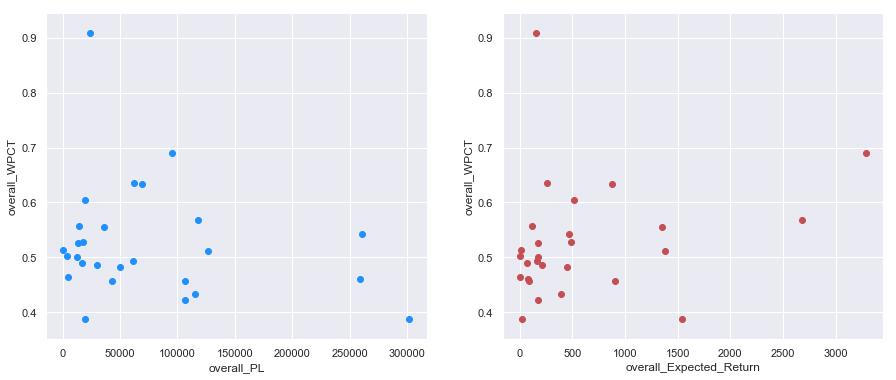

In [86]:
# plot - scatter plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15, 6))


# plot 1 - overall
ax1.scatter(overall_mem["overall_PL"], overall_mem["overall_WPCT"], marker="o", color="dodgerblue") # c
ax1.set(xlabel = 'overall_PL', ylabel = 'overall_WPCT')



# plot 2 - contrast
ax2.scatter(overall_mem["overall_Expected_Return"], overall_mem["overall_WPCT"], marker="o", color="r")
ax2.set(xlabel = 'overall_Expected_Return', ylabel = 'overall_WPCT')


# # legend
# ax1.legend(["Admitted"])
# ax2.legend(["Not-Admitted"])

plt.show()


In [87]:
# # 淨獲利＆期望回報
# def get_Expected_Return(df_test) :

#     def get_AvgProfit(df_preprocess, status) :
#         df = df_preprocess.loc[df_preprocess["Status"] == f"{status}", :]
#         df_sum = df.groupby(["Member"])["Member_Win_Loss"].sum().reset_index()
#         df_sum.columns = ["Member", f"sum_of_Member_{status}"]
#         df_count = df.groupby(["Member"])["Member_Win_Loss"].count().reset_index()
#         df_count.columns = ["Member", f"count_of_Member_{status}"]

#         df = pd.merge(df_sum, df_count, on = ["Member"])
#         df[f"Avg_{status}"] = df[f"sum_of_Member_{status}"] / df[f"count_of_Member_{status}"]
#         return df

#     won = get_AvgProfit(df_test, "WON")
#     lost = get_AvgProfit(df_test, "LOST")
# #     mem = pd.merge(won, lost, how = "inner", on = ["Member"])

#     dfs = [df_test[["Member"]].drop_duplicates(), won, lost]
#     mem = (reduce(lambda left,right: pd.merge(left, right, how = "outer", on = ["Member"]), dfs)).fillna(0)
    
#     mem[["sum_of_Member_WON", "count_of_Member_WON", "Avg_WON", "sum_of_Member_LOST", "count_of_Member_LOST", "Avg_LOST"]] = mem[["sum_of_Member_WON", "count_of_Member_WON", "Avg_WON", "sum_of_Member_LOST", "count_of_Member_LOST", "Avg_LOST"]].fillna(value=0)
#     mem["winning_percentage"] = mem["count_of_Member_WON"] / (mem["count_of_Member_WON"] + mem["count_of_Member_LOST"])
#     mem["Expected_Return"] = mem["Avg_WON"] * mem["winning_percentage"] + mem["Avg_LOST"] * (1-mem["winning_percentage"])

#     df_test_2 = df_test.groupby(["Member"])["Member_Win_Loss"].sum().reset_index()
#     df_test_2.columns = ["Member", "PL"]
#     mem = pd.merge(mem, df_test_2, how = "outer", on = ["Member"])

#     # 取前80%的下單次數（濾掉剛開始玩卻剛好運氣好的那種）
#     # mem = mem[(mem["count_of_Member_WON"] + mem["count_of_Member_LOST"]) > (30)]
#     mem = mem[(mem["count_of_Member_WON"] + mem["count_of_Member_LOST"]) > (np.percentile((mem["count_of_Member_WON"] + mem["count_of_Member_LOST"]), 20))]
    
#     # sort by  "淨獲利", "期望回報", "勝場數多的"
#     mem = mem.sort_values(by = ["PL", "Expected_Return", "count_of_Member_WON"], ascending = [False, False, False]).reset_index(drop = True)
#     # 取 "淨獲利", "期望回報" > 0
#     mem = mem[(mem["Expected_Return"] > 0) & (mem["PL"] > 0)].reset_index(drop = True)

#     df_test_2 = df_test[["Member", "AVG_bet_amount_per_person"]].drop_duplicates()
#     mem = pd.merge(mem, df_test_2, how = "left", on = ["Member"])

#     return mem

# mem = get_Expected_Return(df_test)
# RiskControll_mem = get_Expected_Return(df_test)["Member"].tolist()

# mem


-----------------

In [88]:
all_mem = df1["Member"].tolist()
sus_mem_overall = overall_mem["Member"].tolist()
sus_mem_Soccer = Soccer_mem["Member"].tolist()
sus_mem_Tennis = Tennis_mem["Member"].tolist()
sus_mem_Cricket = Cricket_mem["Member"].tolist()

## Member tendency in Market 

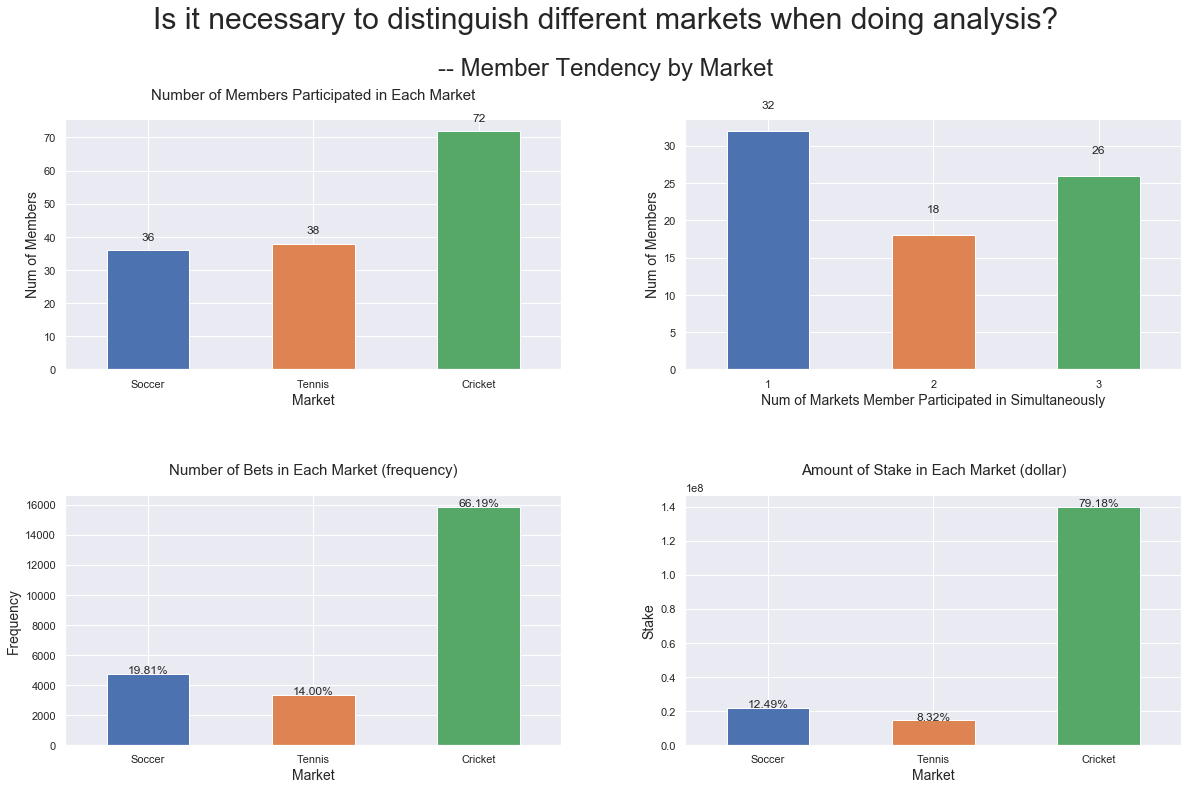

In [89]:
fig, (ax) = plt.subplots(2,2, figsize = (20, 12))


# plot 1


df = df_preprocess_eventall[["Member", "eventTypeName"]].drop_duplicates()
set_order = ["Soccer","Tennis","Cricket"] # order of x-axis
ax[0,0] = df['eventTypeName'].value_counts().loc[set_order].plot(kind='bar', ax = ax[0,0]) 
for p in ax[0,0].patches:
    height = p.get_height()
    ax[0,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}'.format(height),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0,0].set_title("Number of Members Participated in Each Market", size = 15, pad = 20)
ax[0,0].set_xlabel('Market',fontsize=14)
ax[0,0].set_ylabel('Num of Members',fontsize=14)   
#     ax[0,0].set_ylim([0, 30000])



# plot 2

df = df_preprocess_eventall[["Member", "eventTypeName"]].drop_duplicates()
df = df.groupby(["Member"])["eventTypeName"].count().reset_index()
# set_order = [1,2,3] # order of x-axis
ax[0,1] = df.groupby(["eventTypeName"])["Member"].count().loc[[1,2,3]].plot(kind='bar', ax = ax[0,1]) 
for p in ax[0,1].patches:
    height = p.get_height()
    ax[0,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}'.format(height),   # '{0:.2%}'.format(height/total),
            ha="center") 
ax[0,1].set_xlabel('Num of Markets Member Participated in Simultaneously',fontsize=14)
ax[0,1].set_ylabel('Num of Members',fontsize=14)   






# plot 3

set_order = ["Soccer","Tennis","Cricket"] # order of x-axis
ax[1,0] = df_preprocess_eventall['eventTypeName'].value_counts().loc[set_order].plot(kind='bar', ax = ax[1,0]) 
total = len(df_preprocess_eventall['eventTypeName'])
for p in ax[1,0].patches:
    height = p.get_height()
    ax[1,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total),   '{}'.format(height)
            ha="center") 
ax[1,0].set_title("Number of Bets in Each Market (frequency)", size = 15, pad = 20)
ax[1,0].set_xlabel('Market',fontsize=14)
ax[1,0].set_ylabel('Frequency',fontsize=14)   
#     ax[1,0].set_ylim([0, 30000])


# plot 4

set_order = ["Soccer","Tennis","Cricket"] # order of x-axis
ax[1,1] = df_preprocess_eventall.groupby(["eventTypeName"])["Stake"].sum().loc[set_order].plot(kind='bar', ax = ax[1,1]) 
total = df_preprocess_eventall['Stake'].sum()
for p in ax[1,1].patches:
    height = p.get_height()
    ax[1,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total),   '{}'.format(height)
            ha="center") 
ax[1,1].set_title("Amount of Stake in Each Market (dollar)", size = 15, pad = 20)
ax[1,1].set_xlabel('Market',fontsize=14)
ax[1,1].set_ylabel('Stake',fontsize=14)   
#     ax[1,0].set_ylim([0, 30000])


# control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
plt.style.use('ggplot')

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")

# x-axis 字體方向
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
        
plt.subplots_adjust(wspace = 0.25, hspace = 0.5)
# 總標題
fig.suptitle("""Is it necessary to distinguish different markets when doing analysis?""", fontsize=30)
plt.text(x=0.5, y=0.9, s= "-- Member Tendency by Market", fontsize=24, ha="center", transform=fig.transFigure)

plt.subplots_adjust(top=0.85)
plt.show()




In [352]:
df_preprocess_eventall.columns


Index(['Member', 'Placed', 'Selection', 'Bet_ID', 'In_Play', 'One_Click',
       'Type', 'Odds', 'Stake', 'Status', 'Member_Win_Loss', 'Agent_Win_Loss',
       'MA_Win_Loss', 'CUS_Win_Loss', 'http', 'Mem_Info_1', 'Mem_Info_2',
       'Placed_dt', 'Placed_Year', 'Placed_Month', 'Placed_Date',
       'Placed_Day_of_Week', 'Placed_Hour', 'Placed_Minute', 'Type_Back',
       'Type_Lay', 'Type_No', 'Type_Yes', 'Status_INVALID', 'Status_LOST',
       'Status_VOID', 'Status_WON', 'http_Info_1', 'http_Info_2',
       'http_Info_3', 'marketStartTime', 'totalMatched', 'eventTypeName',
       'Placed_ms_mST', 'Stake_d_totalMatched', 'win_loss_ratio'],
      dtype='object')

In [354]:
df1.columns

Index(['Member', 'overall_count', 'overall_PL', 'overall_WON_count',
       'overall_WON_sum', 'overall_LOST_count', 'overall_LOST_sum',
       'overall_WPCT', 'overall_Expected_Return', 'overall_AVG_win_loss_ratio',
       'overall_Std_win_loss_ratio', 'overall_AVG_Odds', 'overall_Std_Odds',
       'overall_AVG_Stake', 'overall_Std_Stake', 'Soccer_PL', 'Soccer_count',
       'Soccer_WON_count', 'Soccer_WON_sum', 'Soccer_LOST_count',
       'Soccer_LOST_sum', 'Soccer_WPCT', 'Soccer_Expected_Return',
       'Soccer_AVG_win_loss_ratio', 'Soccer_Std_win_loss_ratio',
       'Soccer_AVG_Odds', 'Soccer_Std_Odds', 'Soccer_AVG_Stake',
       'Soccer_Std_Stake', 'Tennis_PL', 'Tennis_count', 'Tennis_WON_count',
       'Tennis_WON_sum', 'Tennis_LOST_count', 'Tennis_LOST_sum', 'Tennis_WPCT',
       'Tennis_Expected_Return', 'Tennis_AVG_win_loss_ratio',
       'Tennis_Std_win_loss_ratio', 'Tennis_AVG_Odds', 'Tennis_Std_Odds',
       'Tennis_AVG_Stake', 'Tennis_Std_Stake', 'Cricket_PL', 'Cricket_cou

In [356]:
df1


,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake,continous_x,continous_y,continous_x,continous_y,continous,con_rate
0,7king,2,1500.000000,1,3.900000e+03,1,-2.400000e+03,0.500000,750.000000,0.135000,...,1.255000,0.190919,15000.000000,7071.067871,0,0,0,0,0,0.000000
1,9king,68,-24901.320312,32,7.721936e+04,36,-1.021207e+05,0.470588,-366.195887,-0.045947,...,23.077095,41.355728,3003.617676,2658.895508,34,34,34,34,34,0.500000
2,ace2,366,-18448.070312,177,2.719182e+05,189,-2.903662e+05,0.483607,-50.404628,-0.010303,...,16.770466,36.923843,2803.423584,2596.549072,75,75,75,75,75,0.204918
3,am113,398,-5087.720215,160,1.685844e+05,238,-1.736721e+05,0.402010,-12.783252,-0.009511,...,1.574165,0.276084,1594.873291,1278.946533,133,133,133,133,133,0.334171
4,am115,600,106632.179688,253,1.080947e+06,347,-9.743145e+05,0.421667,177.720417,-0.092647,...,25.915489,42.609200,6044.475098,7954.927246,206,206,206,206,206,0.343333
5,am121,1920,-109226.109375,851,2.071750e+06,1069,-2.180976e+06,0.443229,-56.888542,-0.020518,...,28.890480,44.939945,5174.627930,7577.041504,597,597,597,597,597,0.310937
6,am122,803,19123.041016,311,2.580587e+05,492,-2.389357e+05,0.387298,23.814485,0.012200,...,1.543917,0.287848,1071.649536,688.707397,274,274,274,274,274,0.341220
7,am333,584,-120608.445312,228,5.031589e+05,356,-6.237673e+05,0.390411,-206.521244,-0.172147,...,74.412964,43.864998,2285.073975,4410.814941,389,389,389,389,389,0.666096
8,am666,5,-9883.600586,4,1.511640e+04,1,-2.500000e+04,0.800000,-1976.719922,0.082600,...,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1,0.200000
9,am901,785,-9367.500000,363,1.852745e+05,422,-1.946420e+05,0.462420,-11.933141,-0.020210,...,14.811707,33.188171,822.311523,1117.424316,170,170,170,170,170,0.216561


In [90]:
all_mem
sus_mem_overall
sus_mem_Soccer
sus_mem_Tennis
sus_mem_Cricket

['bird26',
 'vikasg02',
 'vikas786',
 'am115',
 'phone06',
 'am906',
 'rajatg01',
 'jmdg01',
 'arung001',
 'anshk01',
 'am903',
 'bird00',
 'bird27',
 'am122']

In [91]:
df_preprocess_eventall.columns

Index(['Member', 'Placed', 'Selection', 'Bet_ID', 'In_Play', 'One_Click',
       'Type', 'Odds', 'Stake', 'Status', 'Member_Win_Loss', 'Agent_Win_Loss',
       'MA_Win_Loss', 'CUS_Win_Loss', 'http', 'Mem_Info_1', 'Mem_Info_2',
       'Placed_dt', 'Placed_Year', 'Placed_Month', 'Placed_Date',
       'Placed_Day_of_Week', 'Placed_Hour', 'Placed_Minute', 'Type_Back',
       'Type_Lay', 'Type_No', 'Type_Yes', 'Status_INVALID', 'Status_LOST',
       'Status_VOID', 'Status_WON', 'http_Info_1', 'http_Info_2',
       'http_Info_3', 'marketStartTime', 'totalMatched', 'eventTypeName',
       'Placed_ms_mST', 'Stake_d_totalMatched', 'win_loss_ratio'],
      dtype='object')

In [92]:
df1.columns

Index(['Member', 'overall_count', 'overall_PL', 'overall_WON_count',
       'overall_WON_sum', 'overall_LOST_count', 'overall_LOST_sum',
       'overall_WPCT', 'overall_Expected_Return', 'overall_AVG_win_loss_ratio',
       'overall_Std_win_loss_ratio', 'overall_AVG_Odds', 'overall_Std_Odds',
       'overall_AVG_Stake', 'overall_Std_Stake', 'Soccer_PL', 'Soccer_count',
       'Soccer_WON_count', 'Soccer_WON_sum', 'Soccer_LOST_count',
       'Soccer_LOST_sum', 'Soccer_WPCT', 'Soccer_Expected_Return',
       'Soccer_AVG_win_loss_ratio', 'Soccer_Std_win_loss_ratio',
       'Soccer_AVG_Odds', 'Soccer_Std_Odds', 'Soccer_AVG_Stake',
       'Soccer_Std_Stake', 'Tennis_PL', 'Tennis_count', 'Tennis_WON_count',
       'Tennis_WON_sum', 'Tennis_LOST_count', 'Tennis_LOST_sum', 'Tennis_WPCT',
       'Tennis_Expected_Return', 'Tennis_AVG_win_loss_ratio',
       'Tennis_Std_win_loss_ratio', 'Tennis_AVG_Odds', 'Tennis_Std_Odds',
       'Tennis_AVG_Stake', 'Tennis_Std_Stake', 'Cricket_PL', 'Cricket_cou

## Type

/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-d

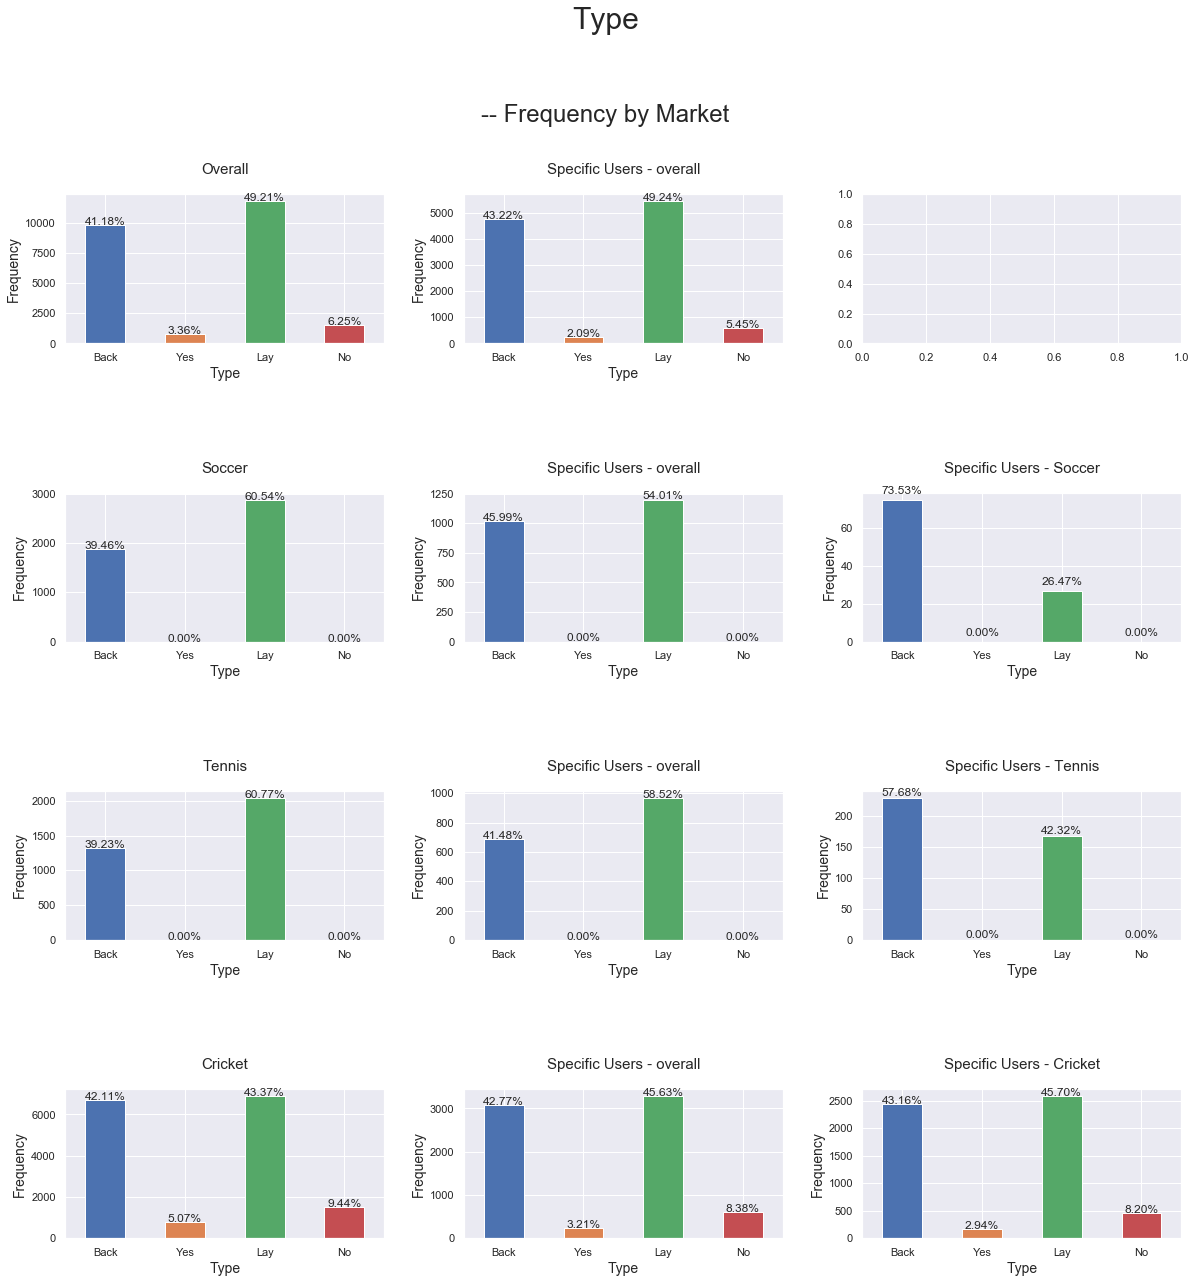

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [93]:
fig, (ax) = plt.subplots(4,3, figsize = (20, 20))


# plot 1-1


set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[0,0] = df_preprocess_eventall.groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[0,0]) 
total = float(len(df_preprocess_eventall)) 
for p in ax[0,0].patches:
    height = p.get_height()
    ax[0,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0,0].set_title("Overall", size = 15, pad = 20)
ax[0,0].set_xlabel('Type',fontsize=14)
ax[0,0].set_ylabel('Frequency',fontsize=14)   
#     ax[0,0].set_ylim([0, 30000])



# plot 1-2

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[0,1] = df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[0,1]) 
total = float(len(df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)])) 
for p in ax[0,1].patches:
    height = p.get_height()
    ax[0,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[0,1].set_xlabel('Type',fontsize=14)
ax[0,1].set_ylabel('Frequency',fontsize=14)   
#     ax[0,1].set_ylim([0, 30000])



# plot 2-1

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[1,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Soccer"].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[1,0]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")])) 
for p in ax[1,0].patches:
    height = p.get_height()
    ax[1,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,0].set_title("Soccer", size = 15, pad = 20)
ax[1,0].set_xlabel('Type',fontsize=14)
ax[1,0].set_ylabel('Frequency',fontsize=14)   
#     ax[1,0].set_ylim([0, 30000])



# plot 2-2

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[1,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[1,1]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))])) 
for p in ax[1,1].patches:
    height = p.get_height()
    ax[1,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[1,1].set_xlabel('Type',fontsize=14)
ax[1,1].set_ylabel('Frequency',fontsize=14)   
#     ax[1,1].set_ylim([0, 30000])



# plot 2-3

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[1,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[1,2]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))])) 
for p in ax[1,2].patches:
    height = p.get_height()
    ax[1,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,2].set_title("Specific Users - Soccer", size = 15, pad = 20)
ax[1,2].set_xlabel('Type',fontsize=14)
ax[1,2].set_ylabel('Frequency',fontsize=14)   
#     ax[1,2].set_ylim([0, 30000])







# plot 3-1

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[2,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Tennis"].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[2,0]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")])) 
for p in ax[2,0].patches:
    height = p.get_height()
    ax[2,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,0].set_title("Tennis", size = 15, pad = 20)
ax[2,0].set_xlabel('Type',fontsize=14)
ax[2,0].set_ylabel('Frequency',fontsize=14)   
#     ax[2,0].set_ylim([0, 30000])



# plot 3-2

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[2,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[2,1]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))])) 
for p in ax[2,1].patches:
    height = p.get_height()
    ax[2,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[2,1].set_xlabel('Type',fontsize=14)
ax[2,1].set_ylabel('Frequency',fontsize=14)   
#     ax[2,1].set_ylim([0, 30000])



# plot 3-3

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[2,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[2,2]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))])) 
for p in ax[2,2].patches:
    height = p.get_height()
    ax[2,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,2].set_title("Specific Users - Tennis", size = 15, pad = 20)
ax[2,2].set_xlabel('Type',fontsize=14)
ax[2,2].set_ylabel('Frequency',fontsize=14)   
#     ax[2,2].set_ylim([0, 30000])





# plot 4-1

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[3,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Cricket"].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[3,0]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")])) 
for p in ax[3,0].patches:
    height = p.get_height()
    ax[3,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,0].set_title("Cricket", size = 15, pad = 20)
ax[3,0].set_xlabel('Type',fontsize=14)
ax[3,0].set_ylabel('Frequency',fontsize=14)   
#     ax[3,0].set_ylim([0, 30000])



# plot 4-2

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[3,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[3,1]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))])) 
for p in ax[3,1].patches:
    height = p.get_height()
    ax[3,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[3,1].set_xlabel('Type',fontsize=14)
ax[3,1].set_ylabel('Frequency',fontsize=14)   
#     ax[3,1].set_ylim([0, 30000])



# plot 4-3

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[3,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))].groupby(["Type"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[3,2]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))])) 
for p in ax[3,2].patches:
    height = p.get_height()
    ax[3,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,2].set_title("Specific Users - Cricket", size = 15, pad = 20)
ax[3,2].set_xlabel('Type',fontsize=14)
ax[3,2].set_ylabel('Frequency',fontsize=14)   
#     ax[3,2].set_ylim([0, 30000])




# control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
plt.style.use('ggplot')

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")

# x-axis 字體方向
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
        
plt.subplots_adjust(wspace = 0.25, hspace = 1)
# 總標題
fig.suptitle("""Type""", fontsize=30)
plt.text(x=0.5, y=0.9, s= "-- Frequency by Market", fontsize=24, ha="center", transform=fig.transFigure)

plt.subplots_adjust(top=0.85)
plt.show()

print("Specific Users - overall : \n%s" % sus_mem_overall)
print("--")
print("Specific Users - Soccer : \n%s" % sus_mem_Soccer)
print("--")
print("Specific Users - Tennis : \n%s" % sus_mem_Tennis)
print("--")
print("Specific Users - Cricket : \n%s" % sus_mem_Cricket)
print("--")



/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-d

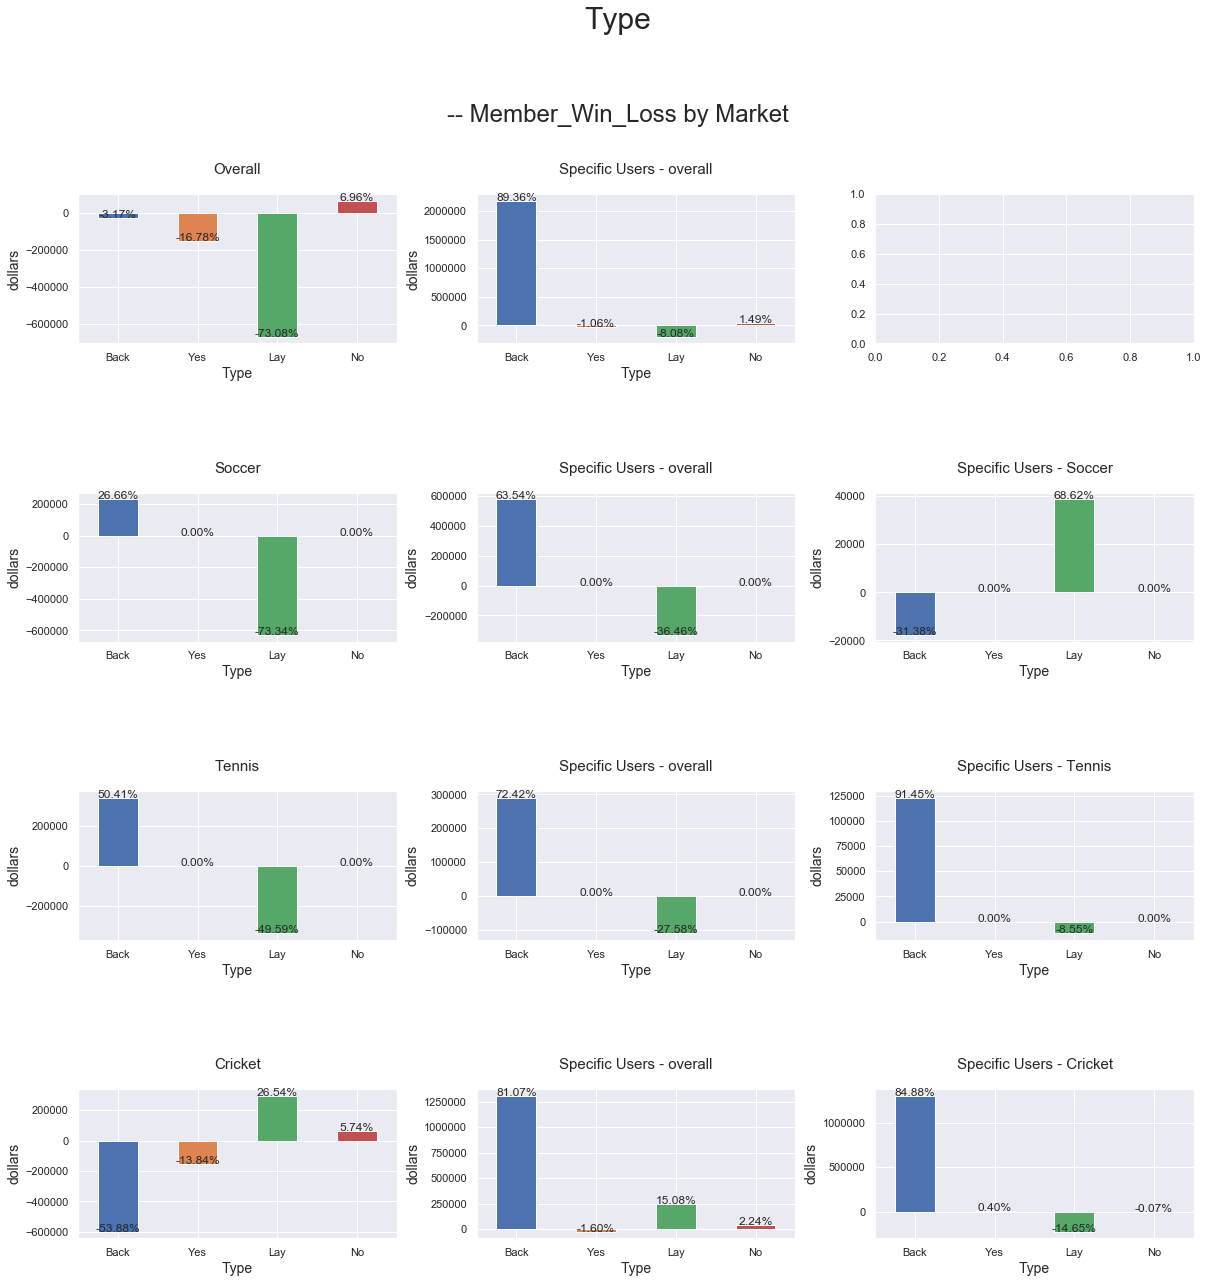

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [94]:
fig, (ax) = plt.subplots(4,3, figsize = (20, 20))


# plot 1-1


set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[0,0] = df_preprocess_eventall.groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[0,0]) 
total = float((df_preprocess_eventall.groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[0,0].patches:
    height = p.get_height()
    ax[0,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0,0].set_title("Overall", size = 15, pad = 20)
ax[0,0].set_xlabel('Type',fontsize=14)
ax[0,0].set_ylabel('dollars',fontsize=14)   
#     ax[0,0].set_ylim([0, 30000])



# plot 1-2

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[0,1] = df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[0,1]) 
total = float((df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)].groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[0,1].patches:
    height = p.get_height()
    ax[0,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[0,1].set_xlabel('Type',fontsize=14)
ax[0,1].set_ylabel('dollars',fontsize=14)   
#     ax[0,1].set_ylim([0, 30000])



# plot 2-1

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[1,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Soccer"].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[1,0]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")].groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[1,0].patches:
    height = p.get_height()
    ax[1,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,0].set_title("Soccer", size = 15, pad = 20)
ax[1,0].set_xlabel('Type',fontsize=14)
ax[1,0].set_ylabel('dollars',fontsize=14)   
#     ax[1,0].set_ylim([0, 30000])



# plot 2-2

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[1,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[1,1]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[1,1].patches:
    height = p.get_height()
    ax[1,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[1,1].set_xlabel('Type',fontsize=14)
ax[1,1].set_ylabel('dollars',fontsize=14)   
#     ax[1,1].set_ylim([0, 30000])



# plot 2-3

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[1,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[1,2]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))].groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[1,2].patches:
    height = p.get_height()
    ax[1,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,2].set_title("Specific Users - Soccer", size = 15, pad = 20)
ax[1,2].set_xlabel('Type',fontsize=14)
ax[1,2].set_ylabel('dollars',fontsize=14)   
#     ax[1,2].set_ylim([0, 30000])







# plot 3-1

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[2,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Tennis"].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[2,0]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")].groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[2,0].patches:
    height = p.get_height()
    ax[2,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,0].set_title("Tennis", size = 15, pad = 20)
ax[2,0].set_xlabel('Type',fontsize=14)
ax[2,0].set_ylabel('dollars',fontsize=14)   
#     ax[2,0].set_ylim([0, 30000])



# plot 3-2

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[2,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[2,1]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[2,1].patches:
    height = p.get_height()
    ax[2,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[2,1].set_xlabel('Type',fontsize=14)
ax[2,1].set_ylabel('dollars',fontsize=14)   
#     ax[2,1].set_ylim([0, 30000])



# plot 3-3

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[2,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[2,2]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))]).groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum()) 
for p in ax[2,2].patches:
    height = p.get_height()
    ax[2,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,2].set_title("Specific Users - Tennis", size = 15, pad = 20)
ax[2,2].set_xlabel('Type',fontsize=14)
ax[2,2].set_ylabel('dollars',fontsize=14)   
#     ax[2,2].set_ylim([0, 30000])





# plot 4-1

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[3,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Cricket"].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[3,0]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")].groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[3,0].patches:
    height = p.get_height()
    ax[3,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,0].set_title("Cricket", size = 15, pad = 20)
ax[3,0].set_xlabel('Type',fontsize=14)
ax[3,0].set_ylabel('dollars',fontsize=14)   
#     ax[3,0].set_ylim([0, 30000])



# plot 4-2

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[3,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[3,1]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[3,1].patches:
    height = p.get_height()
    ax[3,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[3,1].set_xlabel('Type',fontsize=14)
ax[3,1].set_ylabel('dollars',fontsize=14)   
#     ax[3,1].set_ylim([0, 30000])



# plot 4-3

set_order = ["Back", "Yes", "Lay", "No"] # order of x-axis
ax[3,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))].groupby(["Type"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[3,2]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))].groupby(["Type"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[3,2].patches:
    height = p.get_height()
    ax[3,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,2].set_title("Specific Users - Cricket", size = 15, pad = 20)
ax[3,2].set_xlabel('Type',fontsize=14)
ax[3,2].set_ylabel('dollars',fontsize=14)   
#     ax[3,2].set_ylim([0, 30000])




# control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
plt.style.use('ggplot')

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")

# x-axis 字體方向
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
        
plt.subplots_adjust(wspace = 0.25, hspace = 1)
# 總標題
fig.suptitle("""Type""", fontsize=30)
plt.text(x=0.5, y=0.9, s= "-- Member_Win_Loss by Market", fontsize=24, ha="center", transform=fig.transFigure)

plt.subplots_adjust(top=0.85)
plt.show()

print("Specific Users - overall : \n%s" % sus_mem_overall)
print("--")
print("Specific Users - Soccer : \n%s" % sus_mem_Soccer)
print("--")
print("Specific Users - Tennis : \n%s" % sus_mem_Tennis)
print("--")
print("Specific Users - Cricket : \n%s" % sus_mem_Cricket)
print("--")



## Placed Year, Month

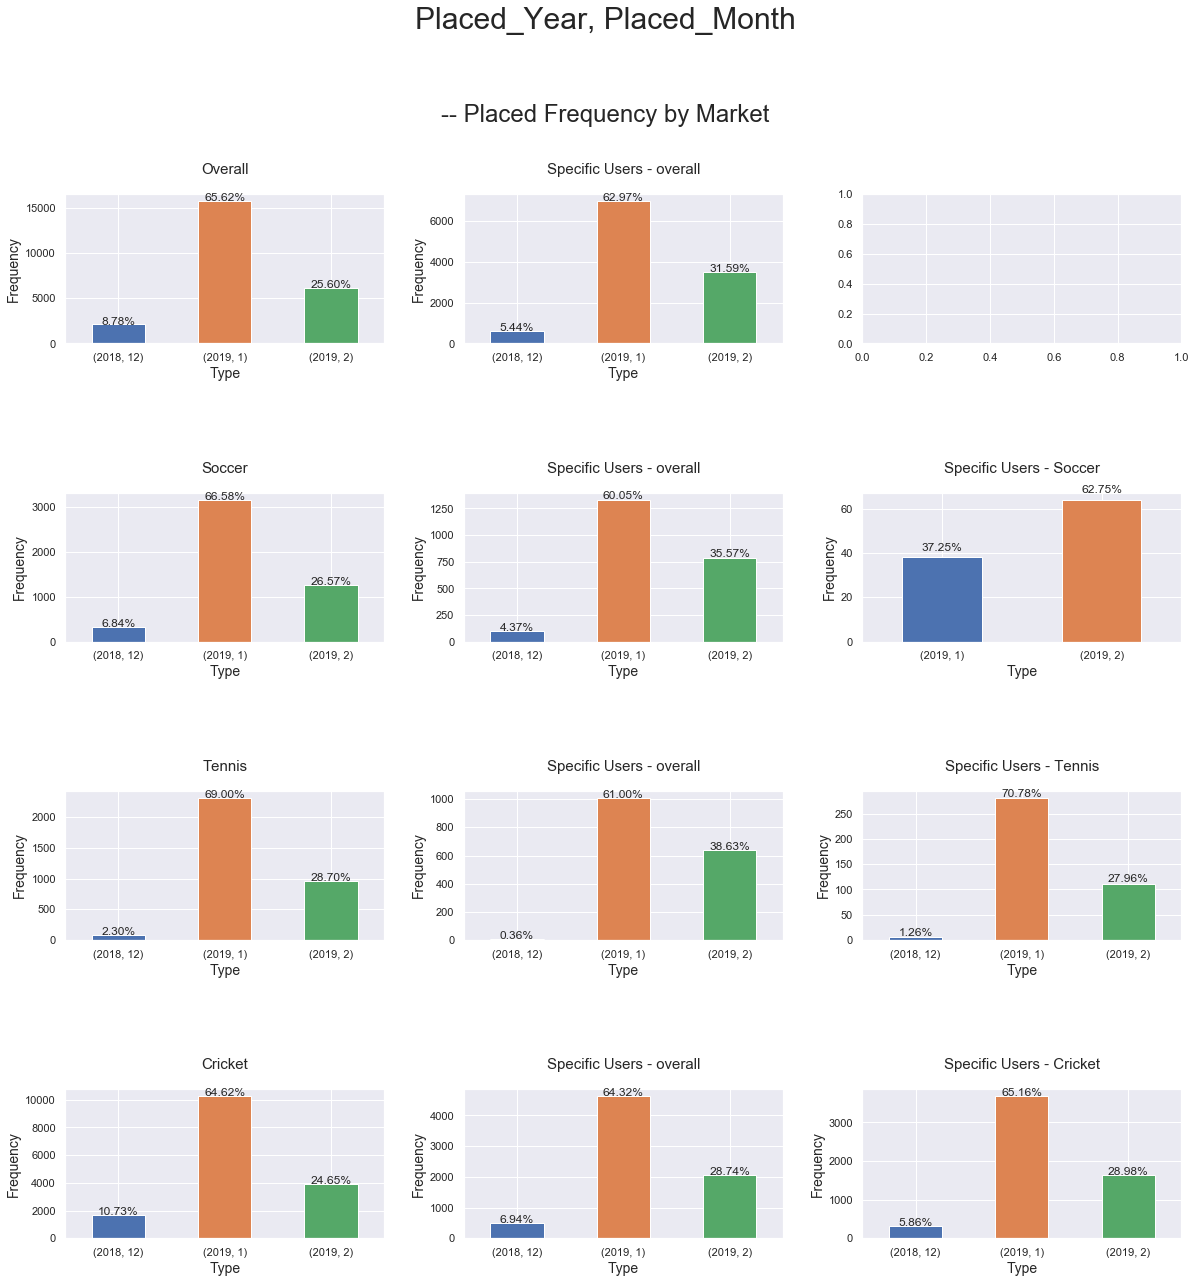

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [95]:
fig, (ax) = plt.subplots(4,3, figsize = (20, 20))


# plot 1-1


ax[0,0] = df_preprocess_eventall.groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[0,0]) 
total = float(len(df_preprocess_eventall)) 
for p in ax[0,0].patches:
    height = p.get_height()
    ax[0,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[0,0].set_title("Overall", size = 15, pad = 20)
ax[0,0].set_xlabel("Type",fontsize=14)
ax[0,0].set_ylabel("Frequency",fontsize=14)   
#     ax[0,0].set_ylim([0, 30000])



# plot 1-2

ax[0,1] = df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[0,1]) 
total = float(len(df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)])) 
for p in ax[0,1].patches:
    height = p.get_height()
    ax[0,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[0,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[0,1].set_xlabel("Type",fontsize=14)
ax[0,1].set_ylabel("Frequency",fontsize=14)   
#     ax[0,1].set_ylim([0, 30000])



# plot 2-1

ax[1,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Soccer"].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[1,0]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")])) 
for p in ax[1,0].patches:
    height = p.get_height()
    ax[1,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[1,0].set_title("Soccer", size = 15, pad = 20)
ax[1,0].set_xlabel("Type",fontsize=14)
ax[1,0].set_ylabel("Frequency",fontsize=14)   
#     ax[1,0].set_ylim([0, 30000])



# plot 2-2

ax[1,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[1,1]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))])) 
for p in ax[1,1].patches:
    height = p.get_height()
    ax[1,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[1,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[1,1].set_xlabel("Type",fontsize=14)
ax[1,1].set_ylabel("Frequency",fontsize=14)   
#     ax[1,1].set_ylim([0, 30000])



# plot 2-3

ax[1,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[1,2]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))])) 
for p in ax[1,2].patches:
    height = p.get_height()
    ax[1,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[1,2].set_title("Specific Users - Soccer", size = 15, pad = 20)
ax[1,2].set_xlabel("Type",fontsize=14)
ax[1,2].set_ylabel("Frequency",fontsize=14)   
#     ax[1,2].set_ylim([0, 30000])







# plot 3-1

ax[2,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Tennis"].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[2,0]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")])) 
for p in ax[2,0].patches:
    height = p.get_height()
    ax[2,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[2,0].set_title("Tennis", size = 15, pad = 20)
ax[2,0].set_xlabel("Type",fontsize=14)
ax[2,0].set_ylabel("Frequency",fontsize=14)   
#     ax[2,0].set_ylim([0, 30000])



# plot 3-2

ax[2,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[2,1]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))])) 
for p in ax[2,1].patches:
    height = p.get_height()
    ax[2,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[2,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[2,1].set_xlabel("Type",fontsize=14)
ax[2,1].set_ylabel("Frequency",fontsize=14)   
#     ax[2,1].set_ylim([0, 30000])



# plot 3-3

ax[2,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[2,2]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))])) 
for p in ax[2,2].patches:
    height = p.get_height()
    ax[2,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[2,2].set_title("Specific Users - Tennis", size = 15, pad = 20)
ax[2,2].set_xlabel("Type",fontsize=14)
ax[2,2].set_ylabel("Frequency",fontsize=14)   
#     ax[2,2].set_ylim([0, 30000])





# plot 4-1

ax[3,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Cricket"].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[3,0]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")])) 
for p in ax[3,0].patches:
    height = p.get_height()
    ax[3,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[3,0].set_title("Cricket", size = 15, pad = 20)
ax[3,0].set_xlabel("Type",fontsize=14)
ax[3,0].set_ylabel("Frequency",fontsize=14)   
#     ax[3,0].set_ylim([0, 30000])



# plot 4-2

ax[3,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[3,1]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))])) 
for p in ax[3,1].patches:
    height = p.get_height()
    ax[3,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[3,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[3,1].set_xlabel("Type",fontsize=14)
ax[3,1].set_ylabel("Frequency",fontsize=14)   
#     ax[3,1].set_ylim([0, 30000])



# plot 4-3

ax[3,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))].groupby(["Placed_Year", "Placed_Month"])["Status"].count().plot(kind="bar", ax = ax[3,2]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))])) 
for p in ax[3,2].patches:
    height = p.get_height()
    ax[3,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[3,2].set_title("Specific Users - Cricket", size = 15, pad = 20)
ax[3,2].set_xlabel("Type",fontsize=14)
ax[3,2].set_ylabel("Frequency",fontsize=14)   
#     ax[3,2].set_ylim([0, 30000])




# control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
plt.style.use("ggplot")

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")

# x-axis 字體方向
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
        
plt.subplots_adjust(wspace = 0.25, hspace = 1)
# 總標題
fig.suptitle("Placed_Year, Placed_Month", fontsize=30)
plt.text(x=0.5, y=0.9, s= "-- Placed Frequency by Market", fontsize=24, ha="center", transform=fig.transFigure)

plt.subplots_adjust(top=0.85)
plt.show()

print("Specific Users - overall : \n%s" % sus_mem_overall)
print("--")
print("Specific Users - Soccer : \n%s" % sus_mem_Soccer)
print("--")
print("Specific Users - Tennis : \n%s" % sus_mem_Tennis)
print("--")
print("Specific Users - Cricket : \n%s" % sus_mem_Cricket)
print("--")



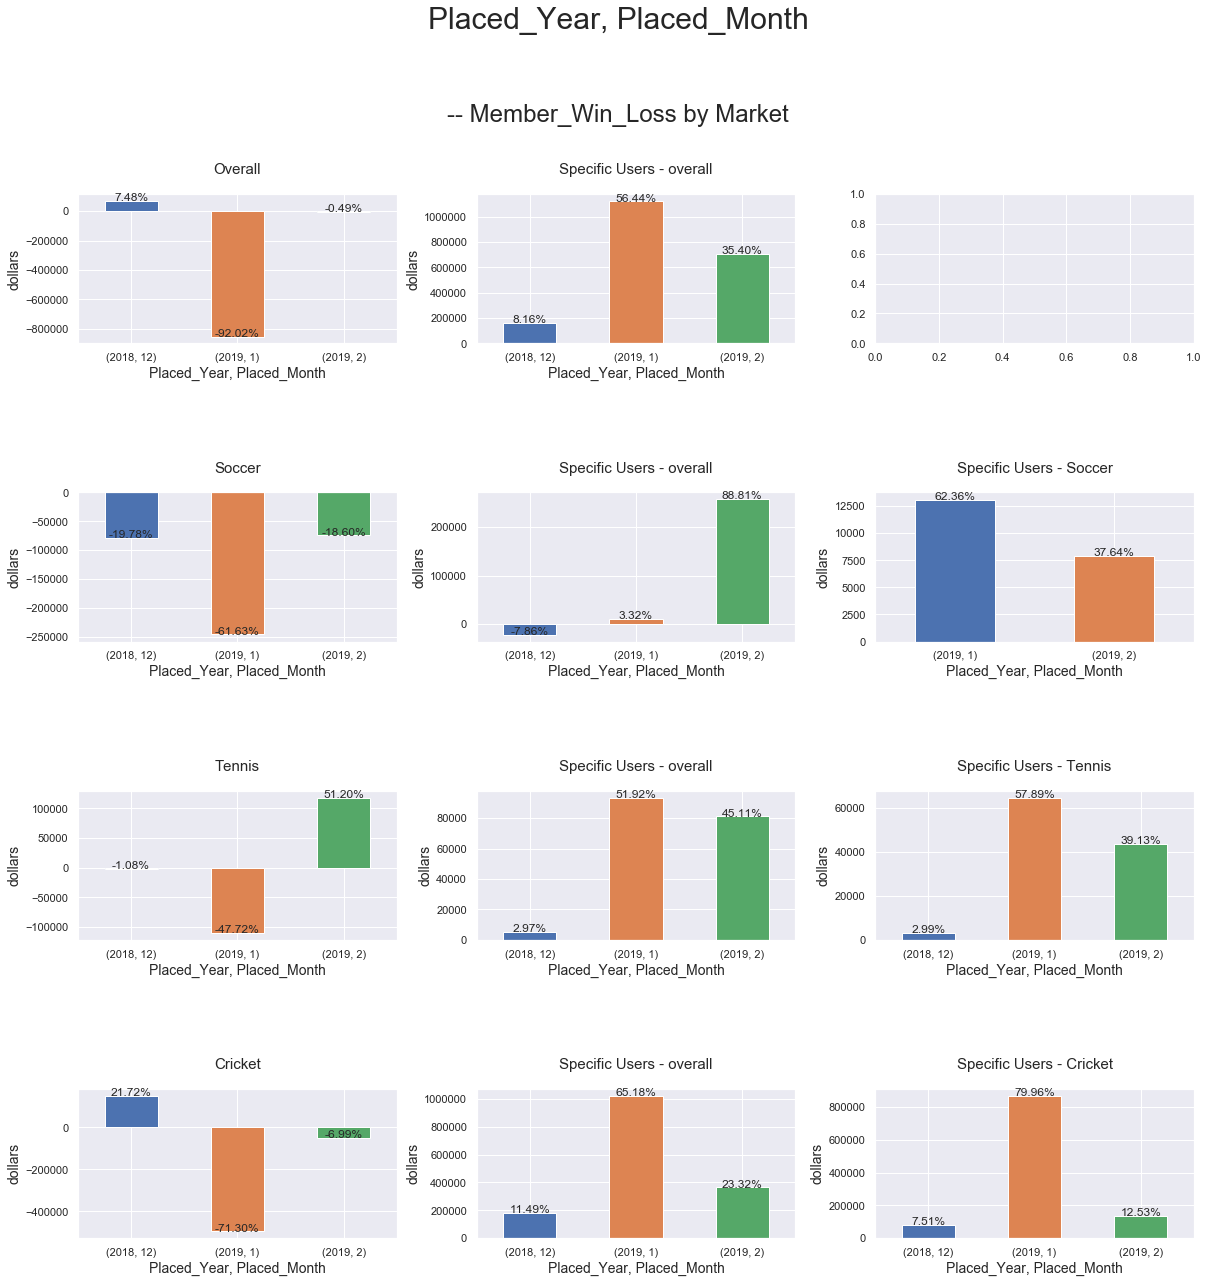

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [96]:
fig, (ax) = plt.subplots(4,3, figsize = (20, 20))


# plot 1-1


ax[0,0] = df_preprocess_eventall.groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[0,0]) 
total = float((df_preprocess_eventall.groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[0,0].patches:
    height = p.get_height()
    ax[0,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[0,0].set_title("Overall", size = 15, pad = 20)
ax[0,0].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[0,0].set_ylabel("dollars",fontsize=14)   
#     ax[0,0].set_ylim([0, 30000])



# plot 1-2

ax[0,1] = df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[0,1]) 
total = float((df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[0,1].patches:
    height = p.get_height()
    ax[0,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[0,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[0,1].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[0,1].set_ylabel("dollars",fontsize=14)   
#     ax[0,1].set_ylim([0, 30000])



# plot 2-1

ax[1,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Soccer"].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[1,0]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[1,0].patches:
    height = p.get_height()
    ax[1,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[1,0].set_title("Soccer", size = 15, pad = 20)
ax[1,0].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[1,0].set_ylabel("dollars",fontsize=14)   
#     ax[1,0].set_ylim([0, 30000])



# plot 2-2

ax[1,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[1,1]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[1,1].patches:
    height = p.get_height()
    ax[1,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[1,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[1,1].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[1,1].set_ylabel("dollars",fontsize=14)   
#     ax[1,1].set_ylim([0, 30000])



# plot 2-3

ax[1,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[1,2]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[1,2].patches:
    height = p.get_height()
    ax[1,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[1,2].set_title("Specific Users - Soccer", size = 15, pad = 20)
ax[1,2].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[1,2].set_ylabel("dollars",fontsize=14)   
#     ax[1,2].set_ylim([0, 30000])







# plot 3-1

ax[2,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Tennis"].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[2,0]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[2,0].patches:
    height = p.get_height()
    ax[2,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[2,0].set_title("Tennis", size = 15, pad = 20)
ax[2,0].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[2,0].set_ylabel("dollars",fontsize=14)   
#     ax[2,0].set_ylim([0, 30000])



# plot 3-2

ax[2,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[2,1]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[2,1].patches:
    height = p.get_height()
    ax[2,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[2,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[2,1].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[2,1].set_ylabel("dollars",fontsize=14)   
#     ax[2,1].set_ylim([0, 30000])



# plot 3-3

ax[2,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[2,2]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))]).groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum()) 
for p in ax[2,2].patches:
    height = p.get_height()
    ax[2,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[2,2].set_title("Specific Users - Tennis", size = 15, pad = 20)
ax[2,2].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[2,2].set_ylabel("dollars",fontsize=14)   
#     ax[2,2].set_ylim([0, 30000])





# plot 4-1

ax[3,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Cricket"].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[3,0]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[3,0].patches:
    height = p.get_height()
    ax[3,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[3,0].set_title("Cricket", size = 15, pad = 20)
ax[3,0].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[3,0].set_ylabel("dollars",fontsize=14)   
#     ax[3,0].set_ylim([0, 30000])



# plot 4-2

ax[3,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[3,1]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[3,1].patches:
    height = p.get_height()
    ax[3,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[3,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[3,1].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[3,1].set_ylabel("dollars",fontsize=14)   
#     ax[3,1].set_ylim([0, 30000])



# plot 4-3

ax[3,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().plot(kind="bar", ax = ax[3,2]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))].groupby(["Placed_Year", "Placed_Month"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[3,2].patches:
    height = p.get_height()
    ax[3,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            "{0:.2%}".format(height/total),   # "{0:.2%}".format(height/total), "{}".format(height),
            ha="center") 
ax[3,2].set_title("Specific Users - Cricket", size = 15, pad = 20)
ax[3,2].set_xlabel("Placed_Year, Placed_Month",fontsize=14)
ax[3,2].set_ylabel("dollars",fontsize=14)   
#     ax[3,2].set_ylim([0, 30000])




# control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
plt.style.use("ggplot")

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")

# x-axis 字體方向
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
        
plt.subplots_adjust(wspace = 0.25, hspace = 1)
# 總標題
fig.suptitle("Placed_Year, Placed_Month", fontsize=30)
plt.text(x=0.5, y=0.9, s= "-- Member_Win_Loss by Market", fontsize=24, ha="center", transform=fig.transFigure)

plt.subplots_adjust(top=0.85)
plt.show()

print("Specific Users - overall : \n%s" % sus_mem_overall)
print("--")
print("Specific Users - Soccer : \n%s" % sus_mem_Soccer)
print("--")
print("Specific Users - Tennis : \n%s" % sus_mem_Tennis)
print("--")
print("Specific Users - Cricket : \n%s" % sus_mem_Cricket)
print("--")



## Status

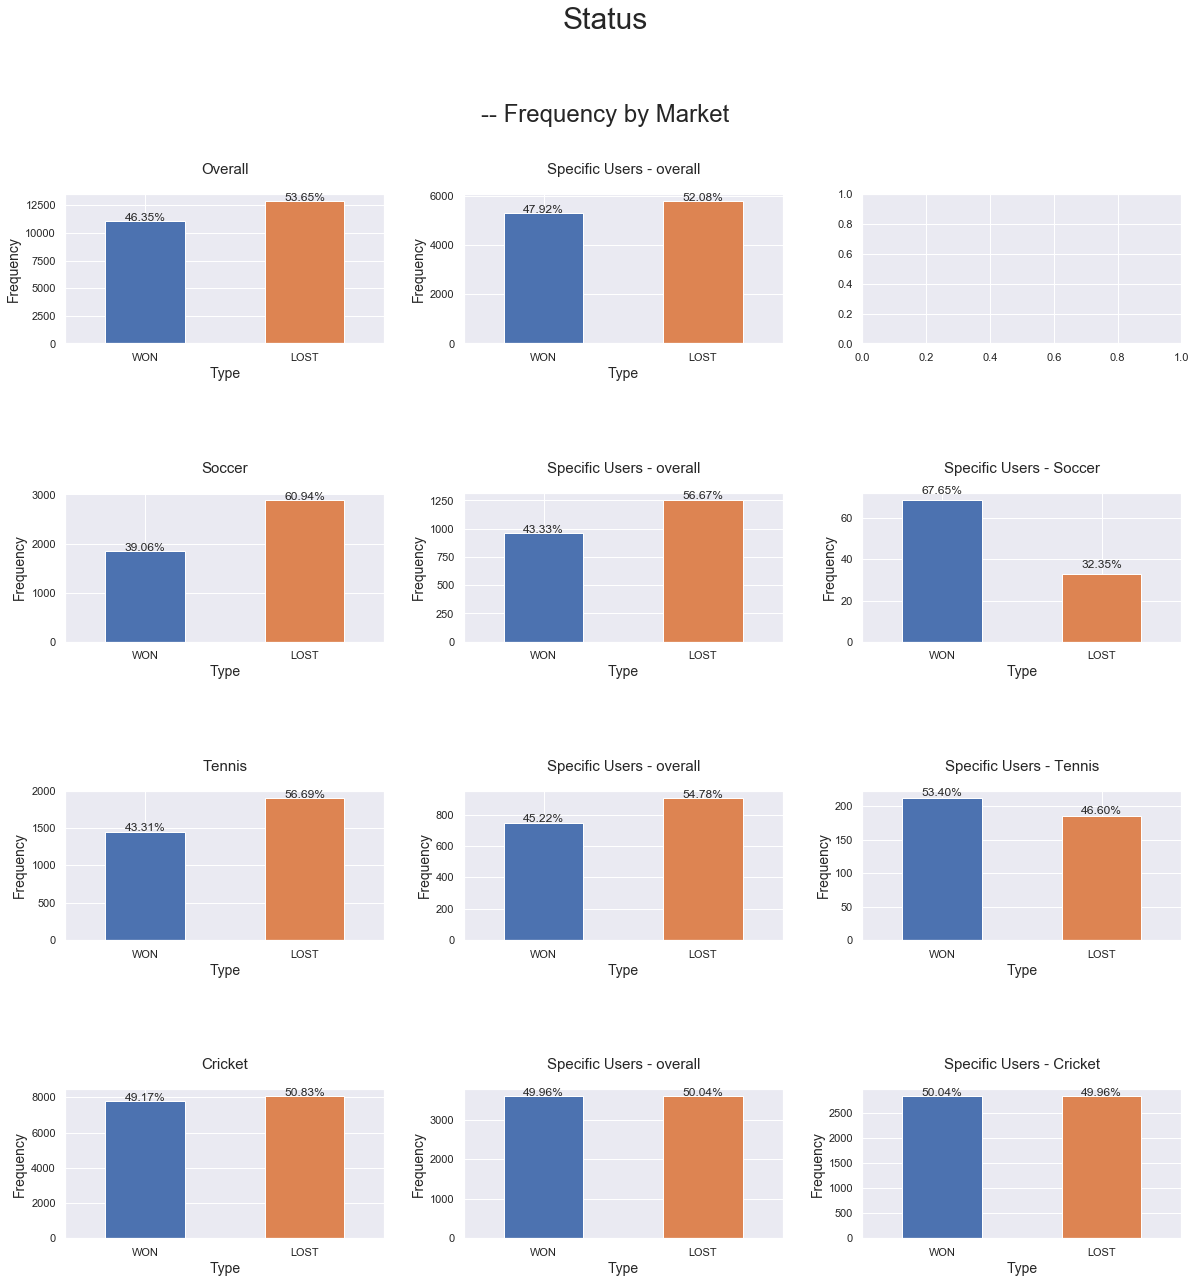

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [97]:
fig, (ax) = plt.subplots(4,3, figsize = (20, 20))


# plot 1-1


# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[0,0] = df_preprocess_eventall.groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[0,0]) 
total = float(len(df_preprocess_eventall)) 
for p in ax[0,0].patches:
    height = p.get_height()
    ax[0,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0,0].set_title("Overall", size = 15, pad = 20)
ax[0,0].set_xlabel('Type',fontsize=14)
ax[0,0].set_ylabel('Frequency',fontsize=14)   
#     ax[0,0].set_ylim([0, 30000])



# plot 1-2

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[0,1] = df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[0,1]) 
total = float(len(df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)])) 
for p in ax[0,1].patches:
    height = p.get_height()
    ax[0,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[0,1].set_xlabel('Type',fontsize=14)
ax[0,1].set_ylabel('Frequency',fontsize=14)   
#     ax[0,1].set_ylim([0, 30000])



# plot 2-1

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[1,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Soccer"].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[1,0]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")])) 
for p in ax[1,0].patches:
    height = p.get_height()
    ax[1,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,0].set_title("Soccer", size = 15, pad = 20)
ax[1,0].set_xlabel('Type',fontsize=14)
ax[1,0].set_ylabel('Frequency',fontsize=14)   
#     ax[1,0].set_ylim([0, 30000])



# plot 2-2

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[1,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[1,1]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))])) 
for p in ax[1,1].patches:
    height = p.get_height()
    ax[1,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[1,1].set_xlabel('Type',fontsize=14)
ax[1,1].set_ylabel('Frequency',fontsize=14)   
#     ax[1,1].set_ylim([0, 30000])



# plot 2-3

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[1,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[1,2]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))])) 
for p in ax[1,2].patches:
    height = p.get_height()
    ax[1,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,2].set_title("Specific Users - Soccer", size = 15, pad = 20)
ax[1,2].set_xlabel('Type',fontsize=14)
ax[1,2].set_ylabel('Frequency',fontsize=14)   
#     ax[1,2].set_ylim([0, 30000])







# plot 3-1

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[2,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Tennis"].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[2,0]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")])) 
for p in ax[2,0].patches:
    height = p.get_height()
    ax[2,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,0].set_title("Tennis", size = 15, pad = 20)
ax[2,0].set_xlabel('Type',fontsize=14)
ax[2,0].set_ylabel('Frequency',fontsize=14)   
#     ax[2,0].set_ylim([0, 30000])



# plot 3-2

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[2,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[2,1]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))])) 
for p in ax[2,1].patches:
    height = p.get_height()
    ax[2,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[2,1].set_xlabel('Type',fontsize=14)
ax[2,1].set_ylabel('Frequency',fontsize=14)   
#     ax[2,1].set_ylim([0, 30000])



# plot 3-3

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[2,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[2,2]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))])) 
for p in ax[2,2].patches:
    height = p.get_height()
    ax[2,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,2].set_title("Specific Users - Tennis", size = 15, pad = 20)
ax[2,2].set_xlabel('Type',fontsize=14)
ax[2,2].set_ylabel('Frequency',fontsize=14)   
#     ax[2,2].set_ylim([0, 30000])





# plot 4-1

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[3,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Cricket"].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[3,0]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")])) 
for p in ax[3,0].patches:
    height = p.get_height()
    ax[3,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,0].set_title("Cricket", size = 15, pad = 20)
ax[3,0].set_xlabel('Type',fontsize=14)
ax[3,0].set_ylabel('Frequency',fontsize=14)   
#     ax[3,0].set_ylim([0, 30000])



# plot 4-2

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[3,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[3,1]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))])) 
for p in ax[3,1].patches:
    height = p.get_height()
    ax[3,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[3,1].set_xlabel('Type',fontsize=14)
ax[3,1].set_ylabel('Frequency',fontsize=14)   
#     ax[3,1].set_ylim([0, 30000])



# plot 4-3

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[3,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))].groupby(["Status"])["Status"].count().loc[set_order].plot(kind='bar', ax = ax[3,2]) 
total = float(len(df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))])) 
for p in ax[3,2].patches:
    height = p.get_height()
    ax[3,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,2].set_title("Specific Users - Cricket", size = 15, pad = 20)
ax[3,2].set_xlabel('Type',fontsize=14)
ax[3,2].set_ylabel('Frequency',fontsize=14)   
#     ax[3,2].set_ylim([0, 30000])




# control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
plt.style.use('ggplot')

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")

# x-axis 字體方向
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
        
plt.subplots_adjust(wspace = 0.25, hspace = 1)
# 總標題
fig.suptitle("Status", fontsize=30)
plt.text(x=0.5, y=0.9, s= "-- Frequency by Market", fontsize=24, ha="center", transform=fig.transFigure)

plt.subplots_adjust(top=0.85)
plt.show()

print("Specific Users - overall : \n%s" % sus_mem_overall)
print("--")
print("Specific Users - Soccer : \n%s" % sus_mem_Soccer)
print("--")
print("Specific Users - Tennis : \n%s" % sus_mem_Tennis)
print("--")
print("Specific Users - Cricket : \n%s" % sus_mem_Cricket)
print("--")



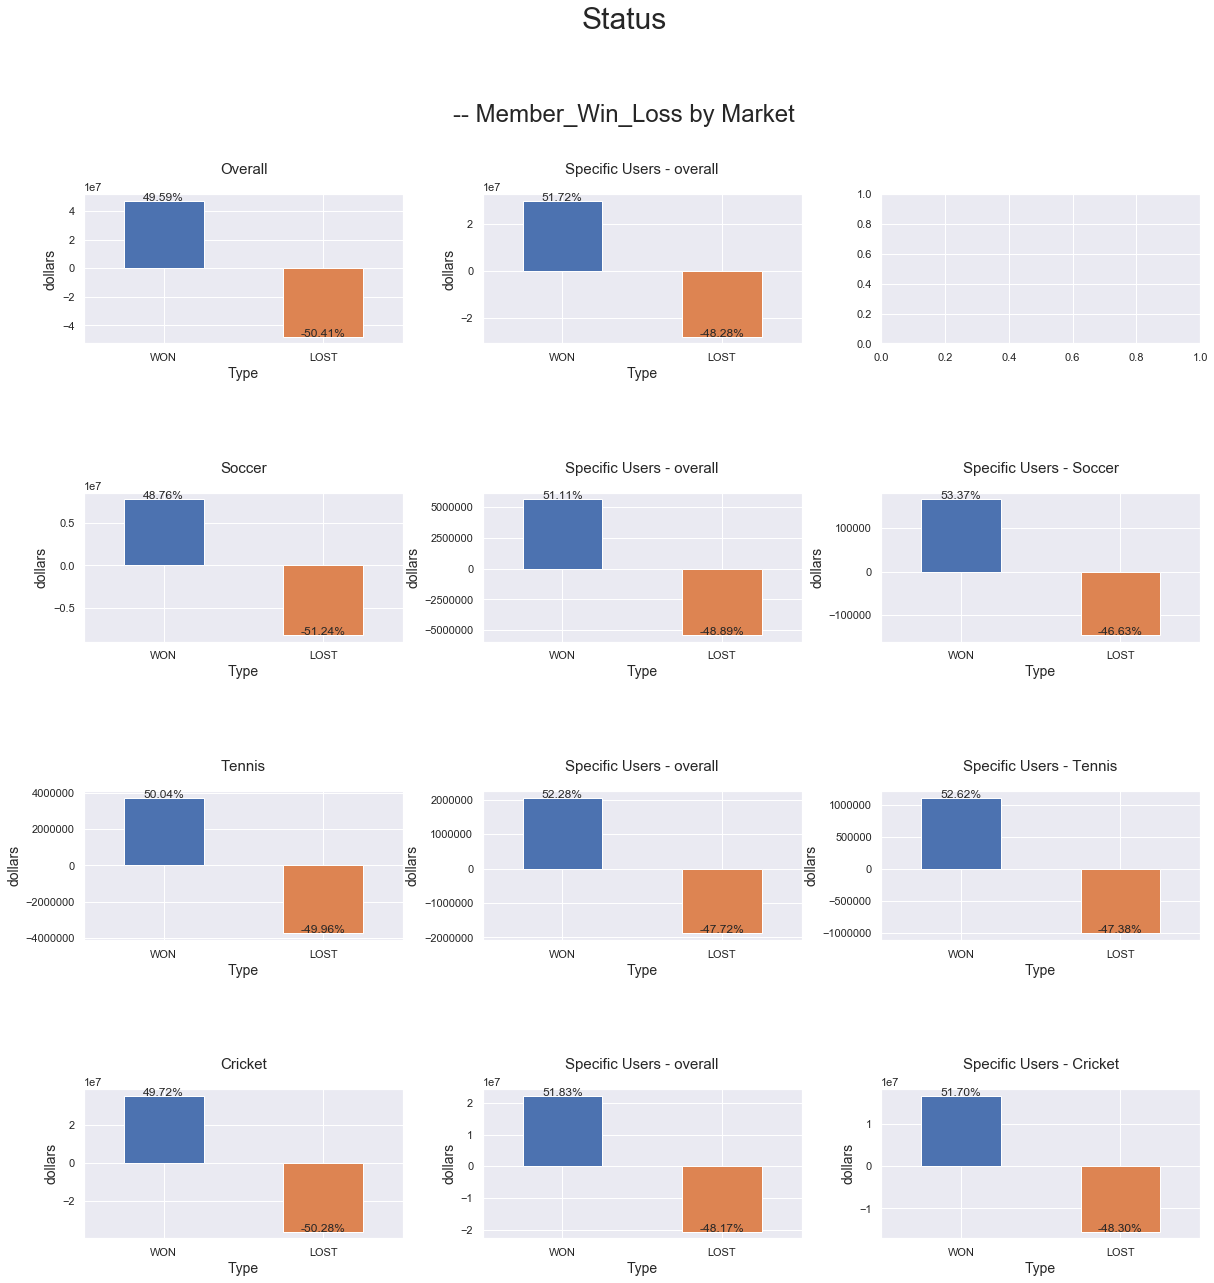

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [98]:
fig, (ax) = plt.subplots(4,3, figsize = (20, 20))


# plot 1-1


# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[0,0] = df_preprocess_eventall.groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[0,0]) 
total = float((df_preprocess_eventall.groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[0,0].patches:
    height = p.get_height()
    ax[0,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0,0].set_title("Overall", size = 15, pad = 20)
ax[0,0].set_xlabel('Type',fontsize=14)
ax[0,0].set_ylabel('dollars',fontsize=14)   
#     ax[0,0].set_ylim([0, 30000])



# plot 1-2

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[0,1] = df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[0,1]) 
total = float((df_preprocess_eventall[df_preprocess_eventall["Member"].isin(sus_mem_overall)].groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[0,1].patches:
    height = p.get_height()
    ax[0,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[0,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[0,1].set_xlabel('Type',fontsize=14)
ax[0,1].set_ylabel('dollars',fontsize=14)   
#     ax[0,1].set_ylim([0, 30000])



# plot 2-1

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[1,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Soccer"].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[1,0]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")].groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[1,0].patches:
    height = p.get_height()
    ax[1,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,0].set_title("Soccer", size = 15, pad = 20)
ax[1,0].set_xlabel('Type',fontsize=14)
ax[1,0].set_ylabel('dollars',fontsize=14)   
#     ax[1,0].set_ylim([0, 30000])



# plot 2-2

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[1,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[1,1]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[1,1].patches:
    height = p.get_height()
    ax[1,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[1,1].set_xlabel('Type',fontsize=14)
ax[1,1].set_ylabel('dollars',fontsize=14)   
#     ax[1,1].set_ylim([0, 30000])



# plot 2-3

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[1,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[1,2]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Soccer")&(df_preprocess_eventall["Member"].isin(sus_mem_Soccer))].groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[1,2].patches:
    height = p.get_height()
    ax[1,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[1,2].set_title("Specific Users - Soccer", size = 15, pad = 20)
ax[1,2].set_xlabel('Type',fontsize=14)
ax[1,2].set_ylabel('dollars',fontsize=14)   
#     ax[1,2].set_ylim([0, 30000])







# plot 3-1

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[2,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Tennis"].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[2,0]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")].groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[2,0].patches:
    height = p.get_height()
    ax[2,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,0].set_title("Tennis", size = 15, pad = 20)
ax[2,0].set_xlabel('Type',fontsize=14)
ax[2,0].set_ylabel('dollars',fontsize=14)   
#     ax[2,0].set_ylim([0, 30000])



# plot 3-2

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[2,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[2,1]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[2,1].patches:
    height = p.get_height()
    ax[2,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[2,1].set_xlabel('Type',fontsize=14)
ax[2,1].set_ylabel('dollars',fontsize=14)   
#     ax[2,1].set_ylim([0, 30000])



# plot 3-3

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[2,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[2,2]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Tennis")&(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))]).groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum()) 
for p in ax[2,2].patches:
    height = p.get_height()
    ax[2,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[2,2].set_title("Specific Users - Tennis", size = 15, pad = 20)
ax[2,2].set_xlabel('Type',fontsize=14)
ax[2,2].set_ylabel('dollars',fontsize=14)   
#     ax[2,2].set_ylim([0, 30000])





# plot 4-1

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[3,0] = df_preprocess_eventall[df_preprocess_eventall["eventTypeName"]=="Cricket"].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[3,0]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")].groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[3,0].patches:
    height = p.get_height()
    ax[3,0].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,0].set_title("Cricket", size = 15, pad = 20)
ax[3,0].set_xlabel('Type',fontsize=14)
ax[3,0].set_ylabel('dollars',fontsize=14)   
#     ax[3,0].set_ylim([0, 30000])



# plot 4-2

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[3,1] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[3,1]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_overall))].groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[3,1].patches:
    height = p.get_height()
    ax[3,1].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,1].set_title("Specific Users - overall", size = 15, pad = 20)
ax[3,1].set_xlabel('Type',fontsize=14)
ax[3,1].set_ylabel('dollars',fontsize=14)   
#     ax[3,1].set_ylim([0, 30000])



# plot 4-3

# set_order = ["WON", "LOST", "VOID", "INVALID"] # order of x-axis
set_order = ["WON", "LOST"]
ax[3,2] = df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))].groupby(["Status"])["Member_Win_Loss"].sum().loc[set_order].plot(kind='bar', ax = ax[3,2]) 
total = float((df_preprocess_eventall[(df_preprocess_eventall["eventTypeName"]=="Cricket")&(df_preprocess_eventall["Member"].isin(sus_mem_Cricket))].groupby(["Status"])["Member_Win_Loss"].sum().apply(lambda x: abs(x)).sum())) 
for p in ax[3,2].patches:
    height = p.get_height()
    ax[3,2].text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),   # '{0:.2%}'.format(height/total), '{}'.format(height),
            ha="center") 
ax[3,2].set_title("Specific Users - Cricket", size = 15, pad = 20)
ax[3,2].set_xlabel('Type',fontsize=14)
ax[3,2].set_ylabel('dollars',fontsize=14)   
#     ax[3,2].set_ylim([0, 30000])




# control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
plt.style.use('ggplot')

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")

# x-axis 字體方向
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0)
        
plt.subplots_adjust(wspace = 0.25, hspace = 1)
# 總標題
fig.suptitle("Status", fontsize=30)
plt.text(x=0.5, y=0.9, s= "-- Member_Win_Loss by Market", fontsize=24, ha="center", transform=fig.transFigure)

plt.subplots_adjust(top=0.85)
plt.show()

print("Specific Users - overall : \n%s" % sus_mem_overall)
print("--")
print("Specific Users - Soccer : \n%s" % sus_mem_Soccer)
print("--")
print("Specific Users - Tennis : \n%s" % sus_mem_Tennis)
print("--")
print("Specific Users - Cricket : \n%s" % sus_mem_Cricket)
print("--")



In [99]:
# df=df_preprocess_eventall[(df_preprocess_eventall["Member"].isin(sus_mem_Tennis))&(df_preprocess_eventall["Status"]=="WON")]
# df[df["Type"]=="Lay"]["Member_Win_Loss"].sum()



## Scatter plot

In [100]:
df_preprocess_eventall.columns

Index(['Member', 'Placed', 'Selection', 'Bet_ID', 'In_Play', 'One_Click',
       'Type', 'Odds', 'Stake', 'Status', 'Member_Win_Loss', 'Agent_Win_Loss',
       'MA_Win_Loss', 'CUS_Win_Loss', 'http', 'Mem_Info_1', 'Mem_Info_2',
       'Placed_dt', 'Placed_Year', 'Placed_Month', 'Placed_Date',
       'Placed_Day_of_Week', 'Placed_Hour', 'Placed_Minute', 'Type_Back',
       'Type_Lay', 'Type_No', 'Type_Yes', 'Status_INVALID', 'Status_LOST',
       'Status_VOID', 'Status_WON', 'http_Info_1', 'http_Info_2',
       'http_Info_3', 'marketStartTime', 'totalMatched', 'eventTypeName',
       'Placed_ms_mST', 'Stake_d_totalMatched', 'win_loss_ratio'],
      dtype='object')

In [101]:
df1.columns

Index(['Member', 'overall_count', 'overall_PL', 'overall_WON_count',
       'overall_WON_sum', 'overall_LOST_count', 'overall_LOST_sum',
       'overall_WPCT', 'overall_Expected_Return', 'overall_AVG_win_loss_ratio',
       'overall_Std_win_loss_ratio', 'overall_AVG_Odds', 'overall_Std_Odds',
       'overall_AVG_Stake', 'overall_Std_Stake', 'Soccer_PL', 'Soccer_count',
       'Soccer_WON_count', 'Soccer_WON_sum', 'Soccer_LOST_count',
       'Soccer_LOST_sum', 'Soccer_WPCT', 'Soccer_Expected_Return',
       'Soccer_AVG_win_loss_ratio', 'Soccer_Std_win_loss_ratio',
       'Soccer_AVG_Odds', 'Soccer_Std_Odds', 'Soccer_AVG_Stake',
       'Soccer_Std_Stake', 'Tennis_PL', 'Tennis_count', 'Tennis_WON_count',
       'Tennis_WON_sum', 'Tennis_LOST_count', 'Tennis_LOST_sum', 'Tennis_WPCT',
       'Tennis_Expected_Return', 'Tennis_AVG_win_loss_ratio',
       'Tennis_Std_win_loss_ratio', 'Tennis_AVG_Odds', 'Tennis_Std_Odds',
       'Tennis_AVG_Stake', 'Tennis_Std_Stake', 'Cricket_PL', 'Cricket_cou

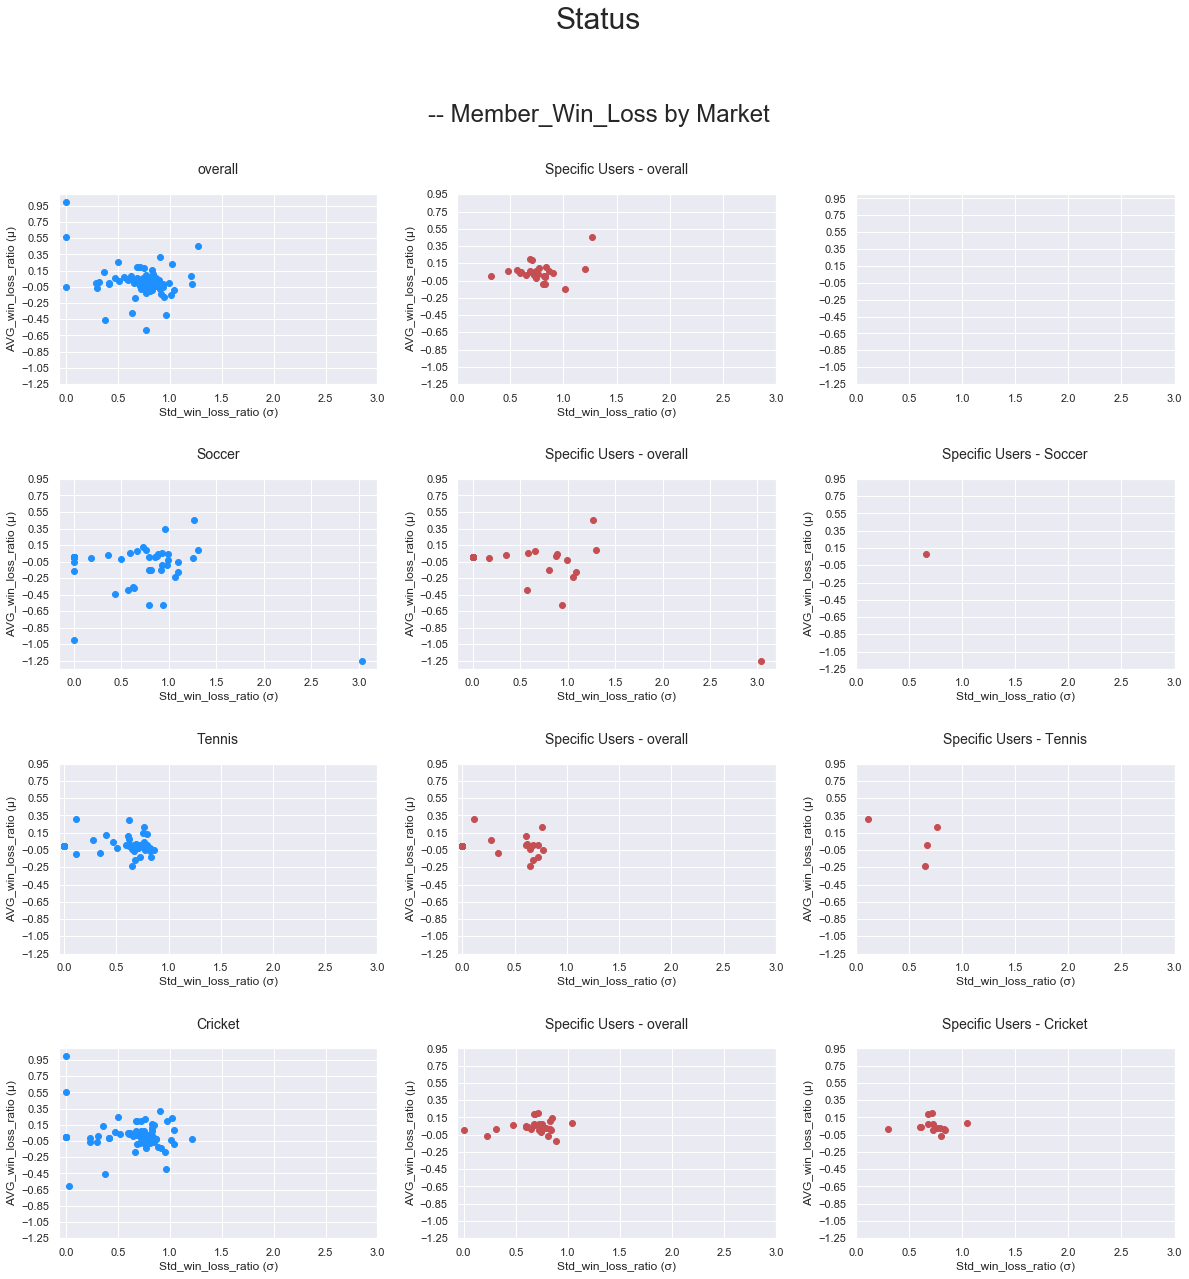

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [102]:
fig, (ax) = plt.subplots(4,3, figsize = (20, 20))


# plot 1-1
ax[0,0].scatter(df1["overall_Std_win_loss_ratio"], df1["overall_AVG_win_loss_ratio"], marker="o", color="dodgerblue") # c
ax[0,0].set_title("overall", size = 14, pad = 20)
ax[0,0].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[0,0].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# plot 1-2
ax[0,1].scatter(df1[df1["Member"].isin(sus_mem_overall)]["overall_Std_win_loss_ratio"], df1[df1["Member"].isin(sus_mem_overall)]["overall_AVG_win_loss_ratio"], marker="o", color="r")
ax[0,1].set_title("Specific Users - overall", size = 14, pad = 20)
ax[0,1].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[0,1].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# plot 2-1
ax[1,0].scatter(df1["Soccer_Std_win_loss_ratio"], df1["Soccer_AVG_win_loss_ratio"], marker="o", color="dodgerblue")
ax[1,0].set_title("Soccer", size = 14, pad = 20)
ax[1,0].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[1,0].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# plot 2-2
ax[1,1].scatter(df1[df1["Member"].isin(sus_mem_overall)]["Soccer_Std_win_loss_ratio"], df1[df1["Member"].isin(sus_mem_overall)]["Soccer_AVG_win_loss_ratio"], marker="o", color="r")
ax[1,1].set_title("Specific Users - overall", size = 14, pad = 20)
ax[1,1].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[1,1].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# plot 2-3
ax[1,2].scatter(df1[df1["Member"].isin(sus_mem_Soccer)]["Soccer_Std_win_loss_ratio"], df1[df1["Member"].isin(sus_mem_Soccer)]["Soccer_AVG_win_loss_ratio"], marker="o", color="r")
ax[1,2].set_title("Specific Users - Soccer", size = 14, pad = 20)
ax[1,2].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[1,2].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   

# plot 3-1
ax[2,0].scatter(df1["Tennis_Std_win_loss_ratio"], df1["Tennis_AVG_win_loss_ratio"], marker="o", color="dodgerblue")
ax[2,0].set_title("Tennis", size = 14, pad = 20)
ax[2,0].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[2,0].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# plot 3-2
ax[2,1].scatter(df1[df1["Member"].isin(sus_mem_overall)]["Tennis_Std_win_loss_ratio"], df1[df1["Member"].isin(sus_mem_overall)]["Tennis_AVG_win_loss_ratio"], marker="o", color="r")
ax[2,1].set_title("Specific Users - overall", size = 14, pad = 20)
ax[2,1].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[2,1].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# plot 3-3
ax[2,2].scatter(df1[df1["Member"].isin(sus_mem_Tennis)]["Tennis_Std_win_loss_ratio"], df1[df1["Member"].isin(sus_mem_Tennis)]["Tennis_AVG_win_loss_ratio"], marker="o", color="r")
ax[2,2].set_title("Specific Users - Tennis", size = 14, pad = 20)
ax[2,2].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[2,2].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# plot 4-1
ax[3,0].scatter(df1["Cricket_Std_win_loss_ratio"], df1["Cricket_AVG_win_loss_ratio"], marker="o", color="dodgerblue")
ax[3,0].set_title("Cricket", size = 14, pad = 20)
ax[3,0].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[3,0].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# plot 4-2
ax[3,1].scatter(df1[df1["Member"].isin(sus_mem_overall)]["Cricket_Std_win_loss_ratio"], df1[df1["Member"].isin(sus_mem_overall)]["Cricket_AVG_win_loss_ratio"], marker="o", color="r")
ax[3,1].set_title("Specific Users - overall", size = 14, pad = 20)
ax[3,1].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[3,1].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# plot 4-3
ax[3,2].scatter(df1[df1["Member"].isin(sus_mem_Cricket)]["Cricket_Std_win_loss_ratio"], df1[df1["Member"].isin(sus_mem_Cricket)]["Cricket_AVG_win_loss_ratio"], marker="o", color="r")
ax[3,2].set_title("Specific Users - Cricket", size = 14, pad = 20)
ax[3,2].set_xlabel('Std_win_loss_ratio (σ)',fontsize=12)
ax[3,2].set_ylabel('AVG_win_loss_ratio (μ)',fontsize=12)   


# control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
plt.style.use('ggplot')

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")


for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=0) # x-axis 字體方向
    plt.xticks(np.arange(min(df1[["overall_Std_win_loss_ratio", "Soccer_Std_win_loss_ratio", "Tennis_Std_win_loss_ratio", "Cricket_Std_win_loss_ratio"]].min()), \
                         max(df1[["overall_Std_win_loss_ratio", "Soccer_Std_win_loss_ratio", "Tennis_Std_win_loss_ratio", "Cricket_Std_win_loss_ratio"]].max()), 0.5)) # x-axis 數字範圍
#     ax.set_ticks_position('left')
#     ax.tick_params(labelbottom='on')
    plt.yticks(np.arange(min(df1[["overall_AVG_win_loss_ratio", "Soccer_AVG_win_loss_ratio", "Tennis_AVG_win_loss_ratio", "Cricket_AVG_win_loss_ratio"]].min()), \
                         max(df1[["overall_AVG_win_loss_ratio", "Soccer_AVG_win_loss_ratio", "Tennis_AVG_win_loss_ratio", "Cricket_AVG_win_loss_ratio"]].max()), 0.2)) # y-axis 數字範圍
#     plt.gca().spines['bottom'].set_position(('data',0))
#     plt.gca().spines['bottom'].set_color('coral')
#     plt.gca().spines['bottom'].set_linestyle("--")
#     plt.gca().spines['left'].set_position(('data',0))
#     plt.gca().spines['left'].set_color('coral')
#     plt.gca().spines['left'].set_linestyle("--")

        
plt.subplots_adjust(wspace = 0.25, hspace = 0.5)
# 總標題
fig.suptitle("Status", fontsize=30)
plt.text(x=0.5, y=0.9, s= "-- Member_Win_Loss by Market", fontsize=24, ha="center", transform=fig.transFigure)

plt.subplots_adjust(top=0.85)
plt.show()

print("Specific Users - overall : \n%s" % sus_mem_overall)
print("--")
print("Specific Users - Soccer : \n%s" % sus_mem_Soccer)
print("--")
print("Specific Users - Tennis : \n%s" % sus_mem_Tennis)
print("--")
print("Specific Users - Cricket : \n%s" % sus_mem_Cricket)
print("--")



In [103]:
x_feature = ""
y_feature = ""
xticks_range = ""
yticks_range = ""
suptitle = ""
text = ""

def scatter(x_feature, y_feature, xticks_range, yticks_range, suptitle, text) :
    fig, (ax) = plt.subplots(4,3, figsize = (20, 20))


    # plot 1-1
    ax[0,0].scatter(df1[f"overall_{x_feature}"], df1[f"overall_{y_feature}"], marker="o", color="dodgerblue") # c
    ax[0,0].set_title("overall", size = 14, pad = 20)
    ax[0,0].set_xlabel(f'{x_feature}',fontsize=12)
    ax[0,0].set_ylabel(f'{y_feature}',fontsize=12)   


    # plot 1-2
    ax[0,1].scatter(df1[df1["Member"].isin(sus_mem_overall)][f"overall_{x_feature}"], df1[df1["Member"].isin(sus_mem_overall)][f"overall_{y_feature}"], marker="o", color="r")
    ax[0,1].set_title("Specific Users - overall", size = 14, pad = 20)
    ax[0,1].set_xlabel(f'{x_feature}',fontsize=12)
    ax[0,1].set_ylabel(f'{y_feature}',fontsize=12)   


    # plot 2-1
    ax[1,0].scatter(df1[f"Soccer_{x_feature}"], df1[f"Soccer_{y_feature}"], marker="o", color="dodgerblue")
    ax[1,0].set_title("Soccer", size = 14, pad = 20)
    ax[1,0].set_xlabel(f'{x_feature}',fontsize=12)
    ax[1,0].set_ylabel(f'{y_feature}',fontsize=12)   


    # plot 2-2
    ax[1,1].scatter(df1[df1["Member"].isin(sus_mem_overall)][f"Soccer_{x_feature}"], df1[df1["Member"].isin(sus_mem_overall)][f"Soccer_{y_feature}"], marker="o", color="r")
    ax[1,1].set_title("Specific Users - overall", size = 14, pad = 20)
    ax[1,1].set_xlabel(f'{x_feature}',fontsize=12)
    ax[1,1].set_ylabel(f'{y_feature}',fontsize=12)   


    # plot 2-3
    ax[1,2].scatter(df1[df1["Member"].isin(sus_mem_Soccer)][f"Soccer_{x_feature}"], df1[df1["Member"].isin(sus_mem_Soccer)][f"Soccer_{y_feature}"], marker="o", color="r")
    ax[1,2].set_title("Specific Users - Soccer", size = 14, pad = 20)
    ax[1,2].set_xlabel(f'{x_feature}',fontsize=12)
    ax[1,2].set_ylabel(f'{y_feature}',fontsize=12)   

    # plot 3-1
    ax[2,0].scatter(df1[f"Tennis_{x_feature}"], df1[f"Tennis_{y_feature}"], marker="o", color="dodgerblue")
    ax[2,0].set_title("Tennis", size = 14, pad = 20)
    ax[2,0].set_xlabel(f'{x_feature}',fontsize=12)
    ax[2,0].set_ylabel(f'{y_feature}',fontsize=12)   


    # plot 3-2
    ax[2,1].scatter(df1[df1["Member"].isin(sus_mem_overall)][f"Tennis_{x_feature}"], df1[df1["Member"].isin(sus_mem_overall)][f"Tennis_{y_feature}"], marker="o", color="r")
    ax[2,1].set_title("Specific Users - overall", size = 14, pad = 20)
    ax[2,1].set_xlabel(f'{x_feature}',fontsize=12)
    ax[2,1].set_ylabel(f'{y_feature}',fontsize=12)   


    # plot 3-3
    ax[2,2].scatter(df1[df1["Member"].isin(sus_mem_Tennis)][f"Tennis_{x_feature}"], df1[df1["Member"].isin(sus_mem_Tennis)][f"Tennis_{y_feature}"], marker="o", color="r")
    ax[2,2].set_title("Specific Users - Tennis", size = 14, pad = 20)
    ax[2,2].set_xlabel(f'{x_feature}',fontsize=12)
    ax[2,2].set_ylabel(f'{y_feature}',fontsize=12)   


    # plot 4-1
    ax[3,0].scatter(df1[f"Cricket_{x_feature}"], df1[f"Cricket_{y_feature}"], marker="o", color="dodgerblue")
    ax[3,0].set_title("Cricket", size = 14, pad = 20)
    ax[3,0].set_xlabel(f'{x_feature}',fontsize=12)
    ax[3,0].set_ylabel(f'{y_feature}',fontsize=12)   


    # plot 4-2
    ax[3,1].scatter(df1[df1["Member"].isin(sus_mem_overall)][f"Cricket_{x_feature}"], df1[df1["Member"].isin(sus_mem_overall)][f"Cricket_{y_feature}"], marker="o", color="r")
    ax[3,1].set_title("Specific Users - overall", size = 14, pad = 20)
    ax[3,1].set_xlabel(f'{x_feature}',fontsize=12)
    ax[3,1].set_ylabel(f'{y_feature}',fontsize=12)   


    # plot 4-3
    ax[3,2].scatter(df1[df1["Member"].isin(sus_mem_Cricket)][f"Cricket_{x_feature}"], df1[df1["Member"].isin(sus_mem_Cricket)][f"Cricket_{y_feature}"], marker="o", color="r")
    ax[3,2].set_title("Specific Users - Cricket", size = 14, pad = 20)
    ax[3,2].set_xlabel(f'{x_feature}',fontsize=12)
    ax[3,2].set_ylabel(f'{y_feature}',fontsize=12)   


    # control all plots
    #     plt.title("Specific Users")
    #     plt.xlim(-0.1, 5)
    #     plt.ylim(-0.76, 1.05)
    plt.style.use('ggplot')

    sns.set(font_scale=3) # font size
    sns.set(style="darkgrid")


    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=0) # x-axis 字體方向
        plt.xticks(np.arange(min(df1[[f"overall_{x_feature}", f"Soccer_{x_feature}", f"Tennis_{x_feature}", f"Cricket_{x_feature}"]].min()), \
                             max(df1[[f"overall_{x_feature}", f"Soccer_{x_feature}", f"Tennis_{x_feature}", f"Cricket_{x_feature}"]].max()), xticks_range)) # x-axis 數字範圍
        plt.yticks(np.arange(min(df1[[f"overall_{y_feature}", f"Soccer_{y_feature}", f"Tennis_{y_feature}", f"Cricket_{y_feature}"]].min()), \
                             max(df1[[f"overall_{y_feature}", f"Soccer_{y_feature}", f"Tennis_{y_feature}", f"Cricket_{y_feature}"]].max()), yticks_range)) # y-axis 數字範圍
    #     plt.gca().spines['bottom'].set_position(('data',0))
    #     plt.gca().spines['bottom'].set_color('coral')
    #     plt.gca().spines['bottom'].set_linestyle("--")
    #     plt.gca().spines['left'].set_position(('data',0))
    #     plt.gca().spines['left'].set_color('coral')
    #     plt.gca().spines['left'].set_linestyle("--")


    plt.subplots_adjust(wspace = 0.25, hspace = 0.5)
    # 總標題
    fig.suptitle(f"{suptitle}", fontsize=30)
    plt.text(x=0.5, y=0.9, s= f"-- {text}", fontsize=24, ha="center", transform=fig.transFigure)

    plt.subplots_adjust(top=0.85)
    plt.show()

    print("Specific Users - overall : \n%s" % sus_mem_overall)
    print("--")
    print("Specific Users - Soccer : \n%s" % sus_mem_Soccer)
    print("--")
    print("Specific Users - Tennis : \n%s" % sus_mem_Tennis)
    print("--")
    print("Specific Users - Cricket : \n%s" % sus_mem_Cricket)
    print("--")



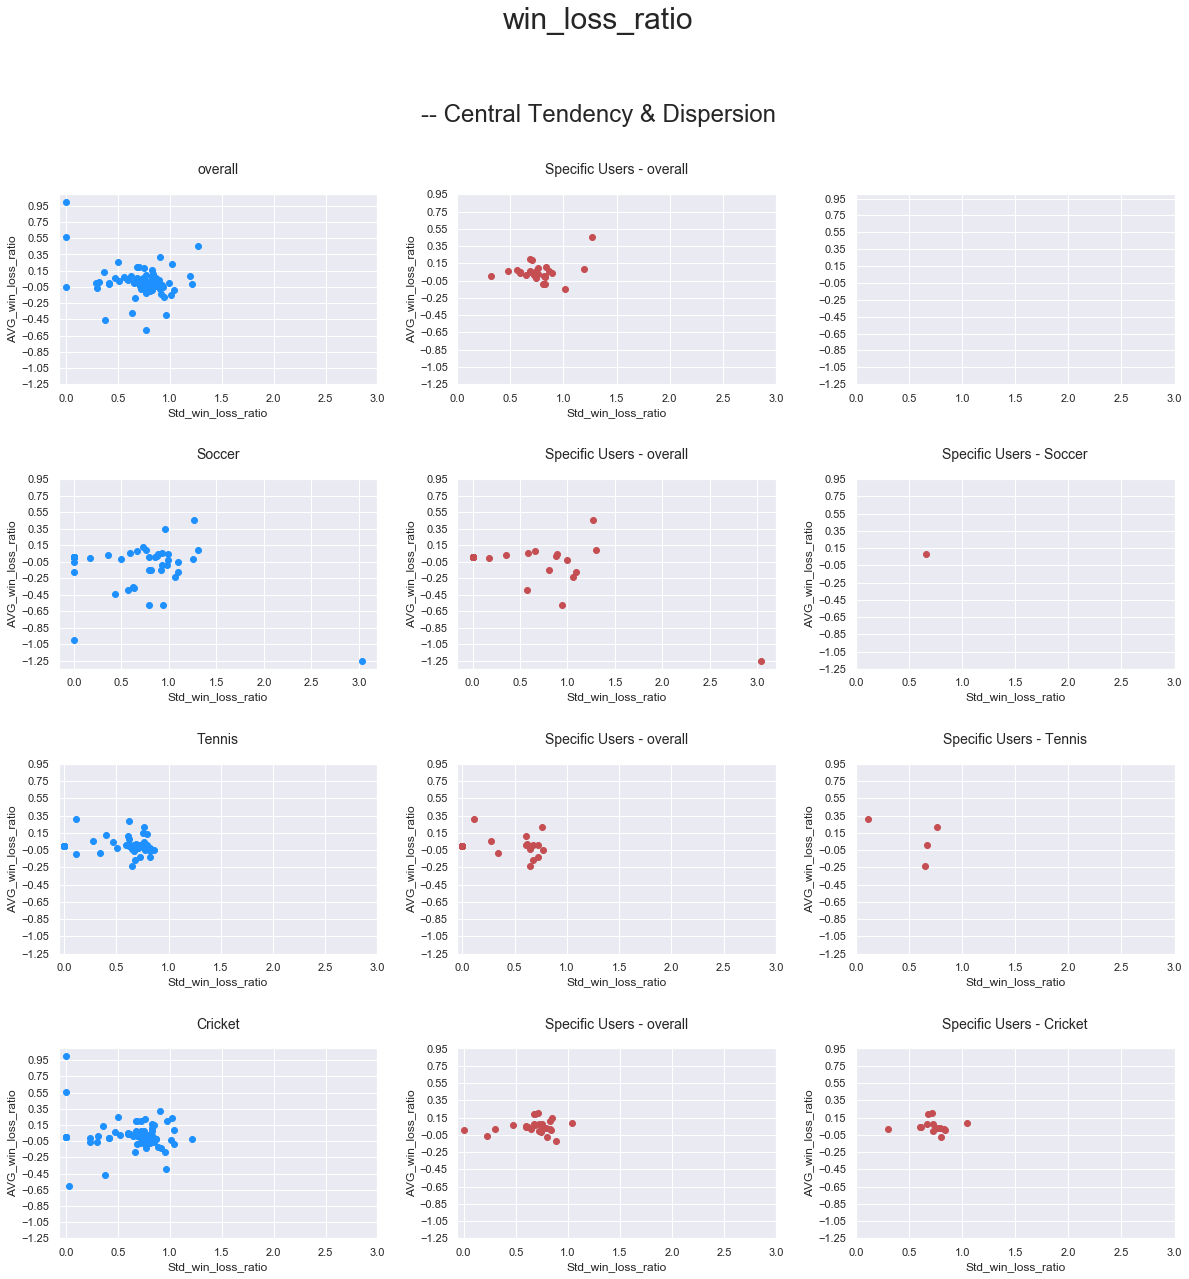

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [104]:
x_feature = "Std_win_loss_ratio"
y_feature = "AVG_win_loss_ratio"
xticks_range = 0.5
yticks_range = 0.2
suptitle = "win_loss_ratio"
text = "Central Tendency & Dispersion"

scatter(x_feature, y_feature, xticks_range, yticks_range, suptitle, text) 

In [105]:
df1.columns

Index(['Member', 'overall_count', 'overall_PL', 'overall_WON_count',
       'overall_WON_sum', 'overall_LOST_count', 'overall_LOST_sum',
       'overall_WPCT', 'overall_Expected_Return', 'overall_AVG_win_loss_ratio',
       'overall_Std_win_loss_ratio', 'overall_AVG_Odds', 'overall_Std_Odds',
       'overall_AVG_Stake', 'overall_Std_Stake', 'Soccer_PL', 'Soccer_count',
       'Soccer_WON_count', 'Soccer_WON_sum', 'Soccer_LOST_count',
       'Soccer_LOST_sum', 'Soccer_WPCT', 'Soccer_Expected_Return',
       'Soccer_AVG_win_loss_ratio', 'Soccer_Std_win_loss_ratio',
       'Soccer_AVG_Odds', 'Soccer_Std_Odds', 'Soccer_AVG_Stake',
       'Soccer_Std_Stake', 'Tennis_PL', 'Tennis_count', 'Tennis_WON_count',
       'Tennis_WON_sum', 'Tennis_LOST_count', 'Tennis_LOST_sum', 'Tennis_WPCT',
       'Tennis_Expected_Return', 'Tennis_AVG_win_loss_ratio',
       'Tennis_Std_win_loss_ratio', 'Tennis_AVG_Odds', 'Tennis_Std_Odds',
       'Tennis_AVG_Stake', 'Tennis_Std_Stake', 'Cricket_PL', 'Cricket_cou

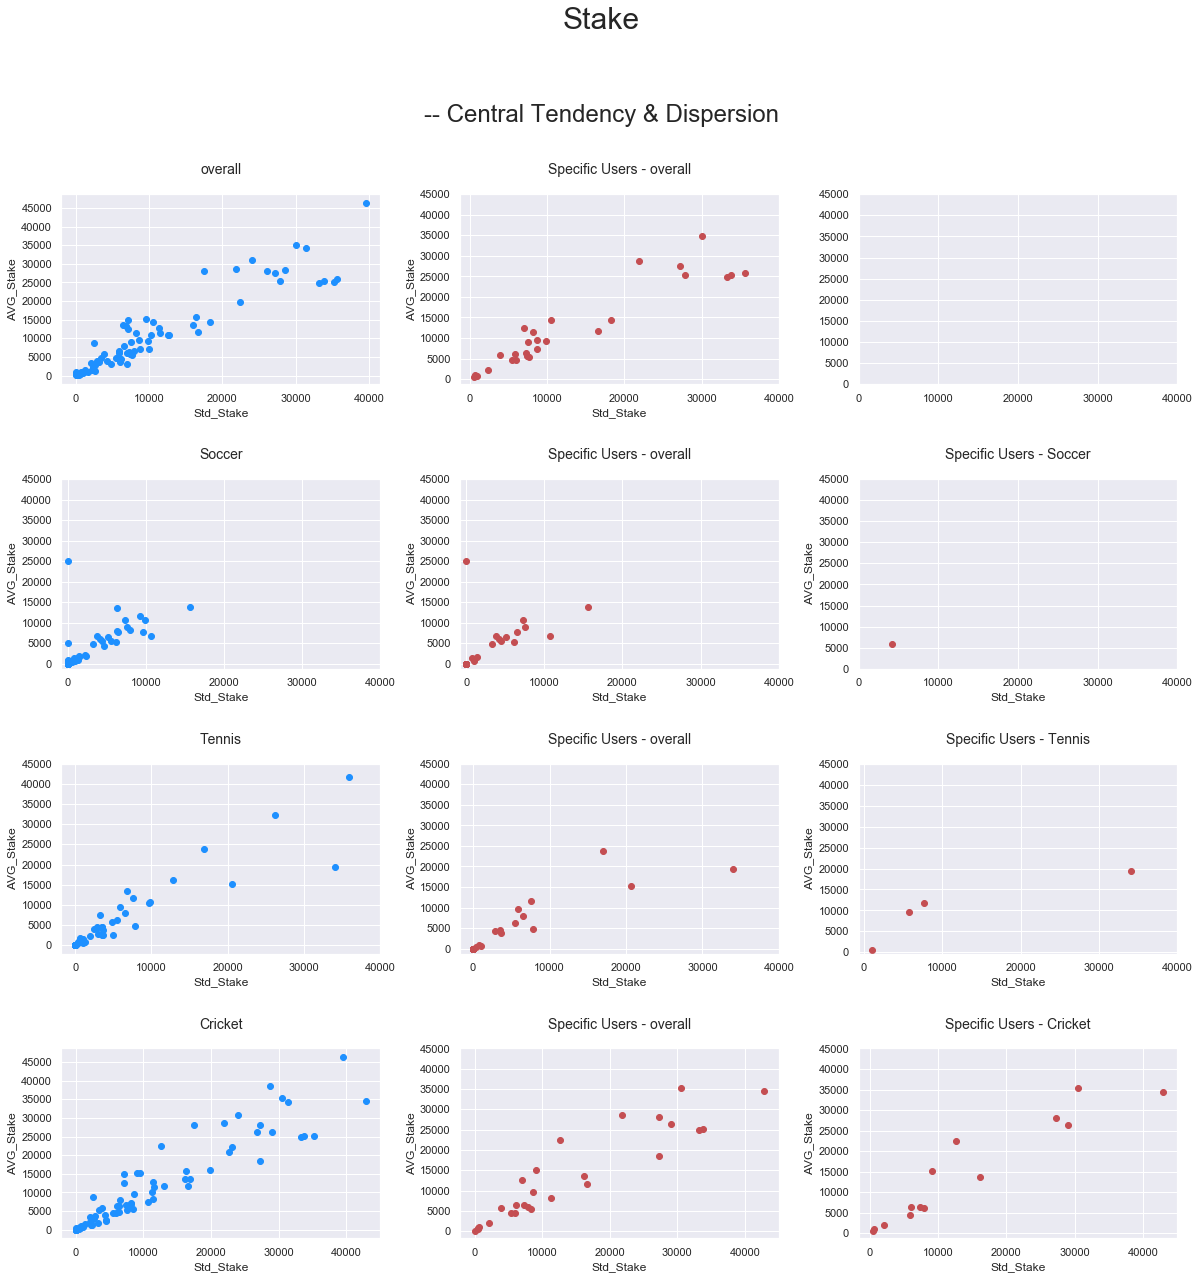

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [106]:
x_feature = "Std_Stake"
y_feature = "AVG_Stake"
xticks_range = 10000
yticks_range = 5000
suptitle = "Stake"
text = "Central Tendency & Dispersion"

scatter(x_feature, y_feature, xticks_range, yticks_range, suptitle, text) 

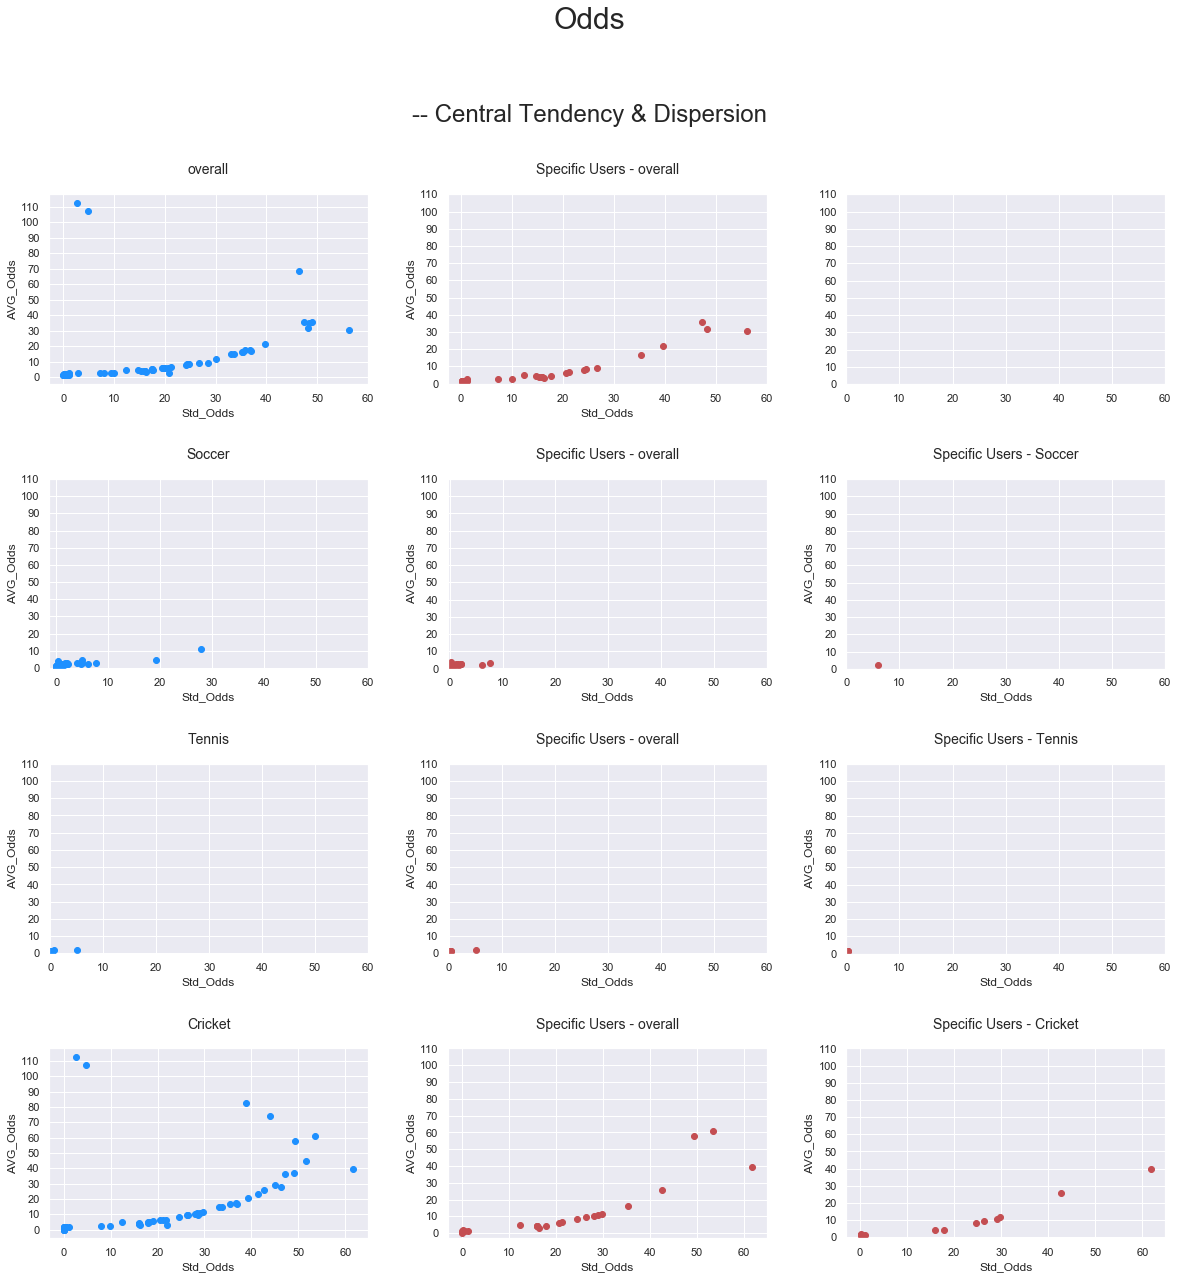

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [107]:
x_feature = "Std_Odds"
y_feature = "AVG_Odds"
xticks_range = 10
yticks_range = 10
suptitle = "Odds"
text = "Central Tendency & Dispersion"

scatter(x_feature, y_feature, xticks_range, yticks_range, suptitle, text) 

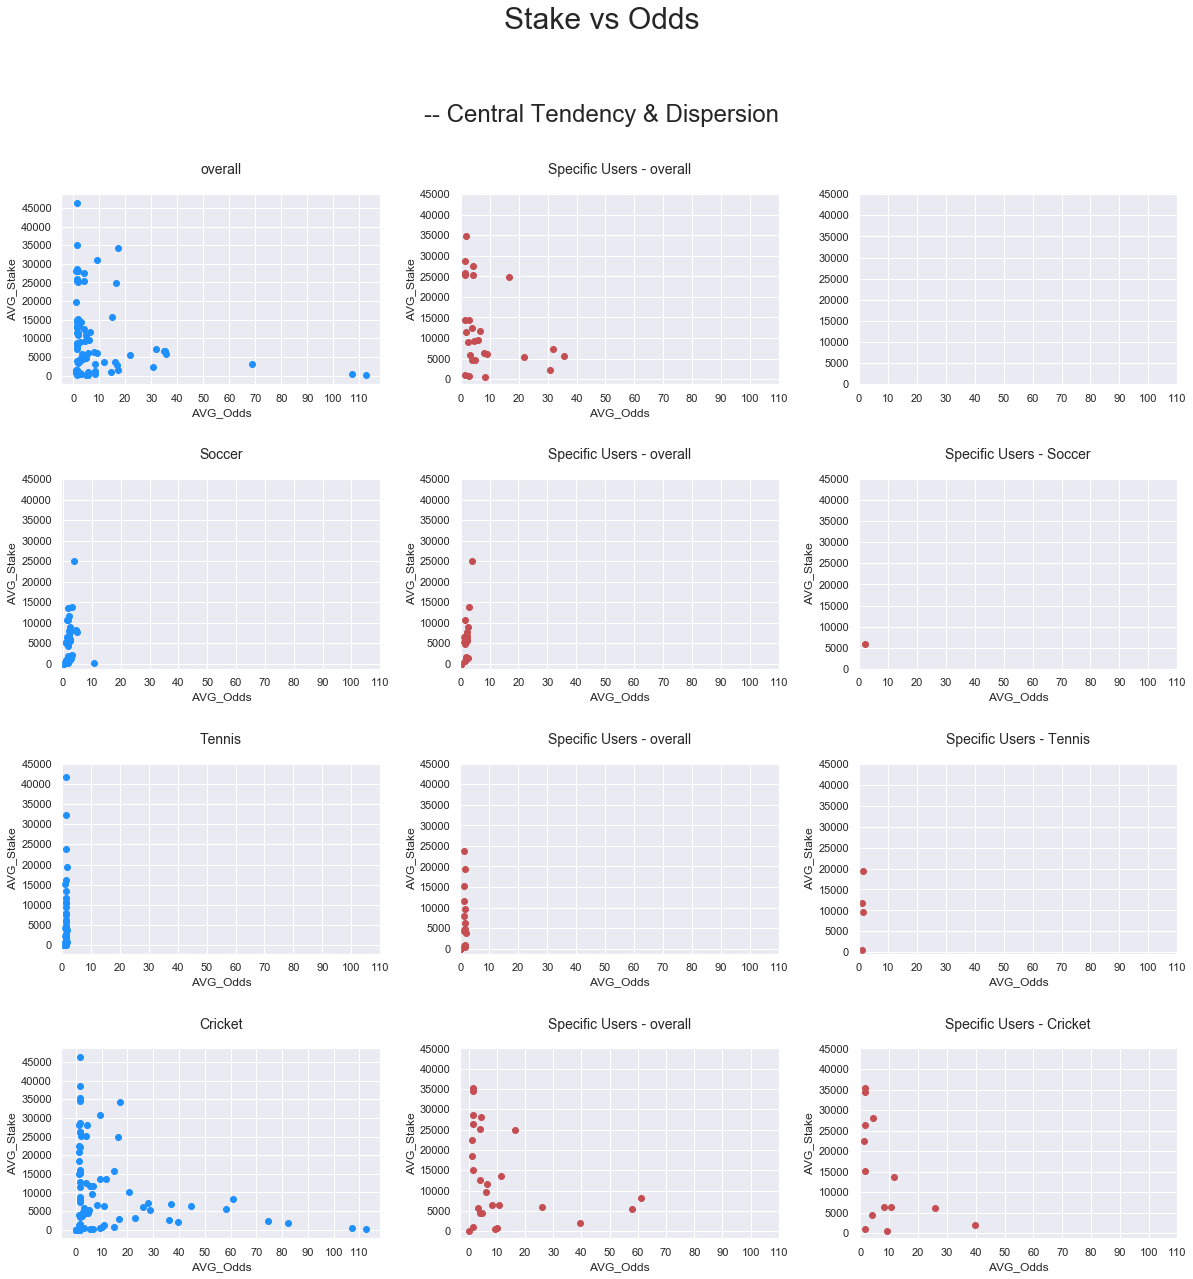

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [109]:
x_feature = "AVG_Odds"
y_feature = "AVG_Stake"
xticks_range = 10
yticks_range = 5000
suptitle = "Stake vs Odds"
text = "Central Tendency & Dispersion"

scatter(x_feature, y_feature, xticks_range, yticks_range, suptitle, text) 

In [112]:
df1.loc[(df1["Cricket_AVG_Odds"]>20)&(df1["Cricket_AVG_Odds"]<30), :]

,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_LOST_count,Cricket_LOST_sum,Cricket_WPCT,Cricket_Expected_Return,Cricket_AVG_win_loss_ratio,Cricket_Std_win_loss_ratio,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake
1,9king,68,-24901.320312,32,7.721936e+04,36,-1.021207e+05,0.470588,-366.195887,-0.045947,...,17,-3.972000e+04,0.468750,-183.615601,-0.061657,0.852166,23.077095,41.355728,3003.617676,2658.895508
4,am115,600,106632.179688,253,1.080947e+06,347,-9.743145e+05,0.421667,177.720417,-0.092647,...,280,-8.789752e+05,0.432049,250.151116,-0.070463,0.805172,25.915489,42.609200,6044.475098,7954.927246
5,am121,1920,-109226.109375,851,2.071750e+06,1069,-2.180976e+06,0.443229,-56.888542,-0.020518,...,523,-1.541041e+06,0.482178,-28.295421,-0.020369,0.855415,28.890480,44.939945,5174.627930,7577.041504
24,bird05,264,-33585.320312,99,2.327833e+05,165,-2.663686e+05,0.375000,-127.217152,-0.052337,...,28,-1.312900e+05,0.533333,-347.983984,-0.029717,0.866354,27.905674,46.196465,7035.349609,8121.735840
68,stamp02,688,-242010.296875,278,9.966189e+05,410,-1.238629e+06,0.404070,-351.759084,0.040397,...,83,-4.894409e+05,0.427586,-1185.993534,-0.024317,0.771018,20.526567,39.198994,10075.731445,11200.875000


In [115]:
df_preprocess_eventall.loc[(df_preprocess_eventall["Member"]=="am115"), :]

,Member,Placed,Selection,Bet_ID,In_Play,One_Click,Type,Odds,Stake,Status,...,Status_WON,http_Info_1,http_Info_2,http_Info_3,marketStartTime,totalMatched,eventTypeName,Placed_ms_mST,Stake_d_totalMatched,win_loss_ratio
184,am115,16/02/2019 01:19:36,Angelique Kerber,1902151719366263,1,0,Back,1.560,5400.000000,LOST,...,0,MTDR02,29131157,MTDR,2019-02-15 15:30:00,3357.13,Tennis,01:49:36,1.608517,-1.000
192,am115,16/02/2019 01:48:19,Elise Mertens,1902151748192636,1,0,Lay,1.200,5000.000000,LOST,...,0,MTDR02,29131157,MTDR,2019-02-15 15:30:00,3357.13,Tennis,02:18:19,1.489367,-0.200
307,am115,16/02/2019 00:39:35,Peshawar Zalmi,1902151639359049,1,0,Lay,1.692,30000.000000,WON,...,1,MTDR02,29119694,MTDR,2019-02-15 16:00:00,6792.69,Cricket,00:39:35,4.416512,1.000
308,am115,16/02/2019 00:50:47,Peshawar Zalmi,1902151650478418,1,0,Back,1.984,25000.000000,LOST,...,0,MTDR02,29119694,MTDR,2019-02-15 16:00:00,6792.69,Cricket,00:50:47,3.680427,-1.000
655,am115,15/02/2019 22:43:54,Simona Halep,1902151443532174,1,0,Back,1.560,5000.000000,WON,...,1,MTDR02,29131007,MTDR,2019-02-15 13:30:00,29410.17,Tennis,01:13:54,0.170009,0.560
748,am115,15/02/2019 03:36:33,172 Runs,1902141936326803,1,0,No,110.000,1000.000000,WON,...,1,MTDR02,29113888,MTDR,2019-02-14 17:45:00,34216681.01,Cricket,01:51:33,0.000029,1.000
796,am115,15/02/2019 03:42:19,Denis Istomin,1902141942189921,1,0,Lay,1.300,1000.000000,WON,...,1,MTDR02,29129357,MTDR,2019-02-14 18:22:00,0.00,Tennis,01:20:19,inf,1.000
797,am115,15/02/2019 03:42:29,Denis Istomin,1902141942290062,1,0,Lay,1.300,600.000000,WON,...,1,MTDR02,29129357,MTDR,2019-02-14 18:22:00,0.00,Tennis,01:20:29,inf,1.000
910,am115,15/02/2019 19:57:34,Daniil Medvedev,1902151157343665,0,0,Back,1.640,3000.000000,WON,...,1,MTDR02,29130712,MTDR,2019-02-15 13:30:00,79326.65,Tennis,-1 days +22:27:34,0.037818,0.640
911,am115,15/02/2019 22:44:17,Daniil Medvedev,1902151444172610,1,0,Lay,1.340,3000.000000,LOST,...,0,MTDR02,29130712,MTDR,2019-02-15 13:30:00,79326.65,Tennis,01:14:17,0.037818,-0.340


In [132]:
df = df_preprocess_eventall.loc[(df_preprocess_eventall["Member"].isin(sus_mem_overall)), :]
(df.ix[(df["Odds"]>10)&(df["Type"]=="Back") & \
        (df["eventTypeName"]=="Tennis"),0:14])#[["Member","eventTypeName"]])

/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,Member,Placed,Selection,Bet_ID,In_Play,One_Click,Type,Odds,Stake,Status,Member_Win_Loss,Agent_Win_Loss,MA_Win_Loss,CUS_Win_Loss
15331,bird27,15/01/2019 14:11:13,Mitchell Krueger,1901150611132555,0,0,Back,70.0,200.0,LOST,-200.0,140.0,0.0,0.0


In [311]:
import datetime
df = df_preprocess_eventall.sort_values(by = ["Member", "eventTypeName", "http_Info_2", "Placed_dt"])

# http_Info_2-2
arr = list(df["http_Info_2"].iloc[0:-1].values)  # 取 第0個 到 倒數第2個(不選最後一個的意思啦)
arr.insert(0, "00000000") # 在頭插入隨便一個日期     ### arr.append(np.datetime64('2099-01-01T00:00:00.000000000'))    # 在尾插入隨便一個日期
df["http_Info_2-2"] = arr

# bets_timedelta, continous
arr = list(df["Placed_dt"].iloc[0:-1].values)  # 取 第0個 到 倒數第2個(不選最後一個的意思啦)
arr.insert(0, np.datetime64('2000-01-01T00:00:00.000000000')) # 在頭插入隨便一個日期     ### arr.append(np.datetime64('2099-01-01T00:00:00.000000000'))    # 在尾插入隨便一個日期
df["Placed_dt_2"] = arr
df["bets_timedelta"] = df["Placed_dt"] - df["Placed_dt_2"]
df = df.reset_index(drop = True)
df["continous"] = df.apply(lambda x: 1 if (x["bets_timedelta"] < datetime.timedelta(minutes=3)) else 0,axis=1)     
# 透過要相同eventId這個條件，把 -1 days (-1 days +01:48:56) 這種的找出來，修正 欄位"continous"
df.loc[(df["continous"] == 1) & (df["http_Info_2"] != df["http_Info_2-2"]) , ["continous"]] = 0
df[["Member", "http_Info_2", "http_Info_2-2", "Placed_dt", "Placed_dt_2", "bets_timedelta", "continous"]].head(20)




,Member,http_Info_2,http_Info_2-2,Placed_dt,Placed_dt_2,bets_timedelta,continous
0,7king,29069709,00000000,2019-01-12 07:15:58,2000-01-01 00:00:00,6951 days 07:15:58,0
1,7king,29069709,29069709,2019-01-12 08:46:40,2019-01-12 07:15:58,0 days 01:30:42,0
2,9king,29086934,29069709,2019-01-25 09:15:13,2019-01-12 08:46:40,13 days 00:28:33,0
3,9king,29086934,29086934,2019-01-25 09:44:00,2019-01-25 09:15:13,0 days 00:28:47,0
4,9king,29086934,29086934,2019-01-25 09:45:36,2019-01-25 09:44:00,0 days 00:01:36,1
5,9king,29086934,29086934,2019-01-25 09:45:59,2019-01-25 09:45:36,0 days 00:00:23,1
6,9king,29089655,29086934,2019-01-24 11:34:55,2019-01-25 09:45:59,-1 days +01:48:56,0
7,9king,29089655,29089655,2019-01-24 11:46:05,2019-01-24 11:34:55,0 days 00:11:10,0
8,9king,29089655,29089655,2019-01-24 11:52:08,2019-01-24 11:46:05,0 days 00:06:03,0
9,9king,29089655,29089655,2019-01-24 11:53:32,2019-01-24 11:52:08,0 days 00:01:24,1


In [324]:
df = df.groupby(["Member"])["continous"].sum().reset_index().sort_values(by = "continous", ascending = False).reset_index(drop = True)
df1 = pd.merge(df1, df, how = "left", on = ["Member"])
df1["con_rate"] = df1["continous"] / df1["overall_count"]
df1 

,Member,overall_count,overall_PL,overall_WON_count,overall_WON_sum,overall_LOST_count,overall_LOST_sum,overall_WPCT,overall_Expected_Return,overall_AVG_win_loss_ratio,...,Cricket_AVG_Odds,Cricket_Std_Odds,Cricket_AVG_Stake,Cricket_Std_Stake,continous_x,continous_y,continous_x,continous_y,continous,con_rate
0,7king,2,1500.000000,1,3.900000e+03,1,-2.400000e+03,0.500000,750.000000,0.135000,...,1.255000,0.190919,15000.000000,7071.067871,0,0,0,0,0,0.000000
1,9king,68,-24901.320312,32,7.721936e+04,36,-1.021207e+05,0.470588,-366.195887,-0.045947,...,23.077095,41.355728,3003.617676,2658.895508,34,34,34,34,34,0.500000
2,ace2,366,-18448.070312,177,2.719182e+05,189,-2.903662e+05,0.483607,-50.404628,-0.010303,...,16.770466,36.923843,2803.423584,2596.549072,75,75,75,75,75,0.204918
3,am113,398,-5087.720215,160,1.685844e+05,238,-1.736721e+05,0.402010,-12.783252,-0.009511,...,1.574165,0.276084,1594.873291,1278.946533,133,133,133,133,133,0.334171
4,am115,600,106632.179688,253,1.080947e+06,347,-9.743145e+05,0.421667,177.720417,-0.092647,...,25.915489,42.609200,6044.475098,7954.927246,206,206,206,206,206,0.343333
5,am121,1920,-109226.109375,851,2.071750e+06,1069,-2.180976e+06,0.443229,-56.888542,-0.020518,...,28.890480,44.939945,5174.627930,7577.041504,597,597,597,597,597,0.310937
6,am122,803,19123.041016,311,2.580587e+05,492,-2.389357e+05,0.387298,23.814485,0.012200,...,1.543917,0.287848,1071.649536,688.707397,274,274,274,274,274,0.341220
7,am333,584,-120608.445312,228,5.031589e+05,356,-6.237673e+05,0.390411,-206.521244,-0.172147,...,74.412964,43.864998,2285.073975,4410.814941,389,389,389,389,389,0.666096
8,am666,5,-9883.600586,4,1.511640e+04,1,-2.500000e+04,0.800000,-1976.719922,0.082600,...,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1,0.200000
9,am901,785,-9367.500000,363,1.852745e+05,422,-1.946420e+05,0.462420,-11.933141,-0.020210,...,14.811707,33.188171,822.311523,1117.424316,170,170,170,170,170,0.216561


In [351]:
# sus_mem_continous
sus_mem_continous = df1.loc[(df1["con_rate"] > 0.4) & (df1["overall_count"] > np.percentile(df1["overall_count"], 20)) &\
                            (df1["overall_PL"] > 0), :]#["Member"].tolist()
sus_mem_continous


df1.loc[(df1["con_rate"] > 0.4) & (df1["overall_count"] > np.percentile(df1["overall_count"], 20)) &\
        (df1["overall_PL"] > 0), ["Member", "overall_WPCT", "overall_count", "continous", "con_rate", "overall_PL"]]

,Member,overall_WPCT,overall_count,continous,con_rate,overall_PL
16,anshk01,0.557377,122,56,0.459016,14582.599609
19,bird00,0.527778,36,16,0.444444,17504.279297
30,bird30,0.481818,110,63,0.572727,49736.949219
43,kick003,0.568182,44,19,0.431818,117907.898438
59,rajatg01,0.555556,27,13,0.481481,36433.179688
60,rajatk01,0.489627,241,109,0.452282,17271.250000
66,shiv2424,0.512821,78,36,0.461538,791.479980
72,vikas786,0.543165,556,228,0.410072,260419.781250
74,vikasg02,0.457627,118,66,0.559322,106275.226562


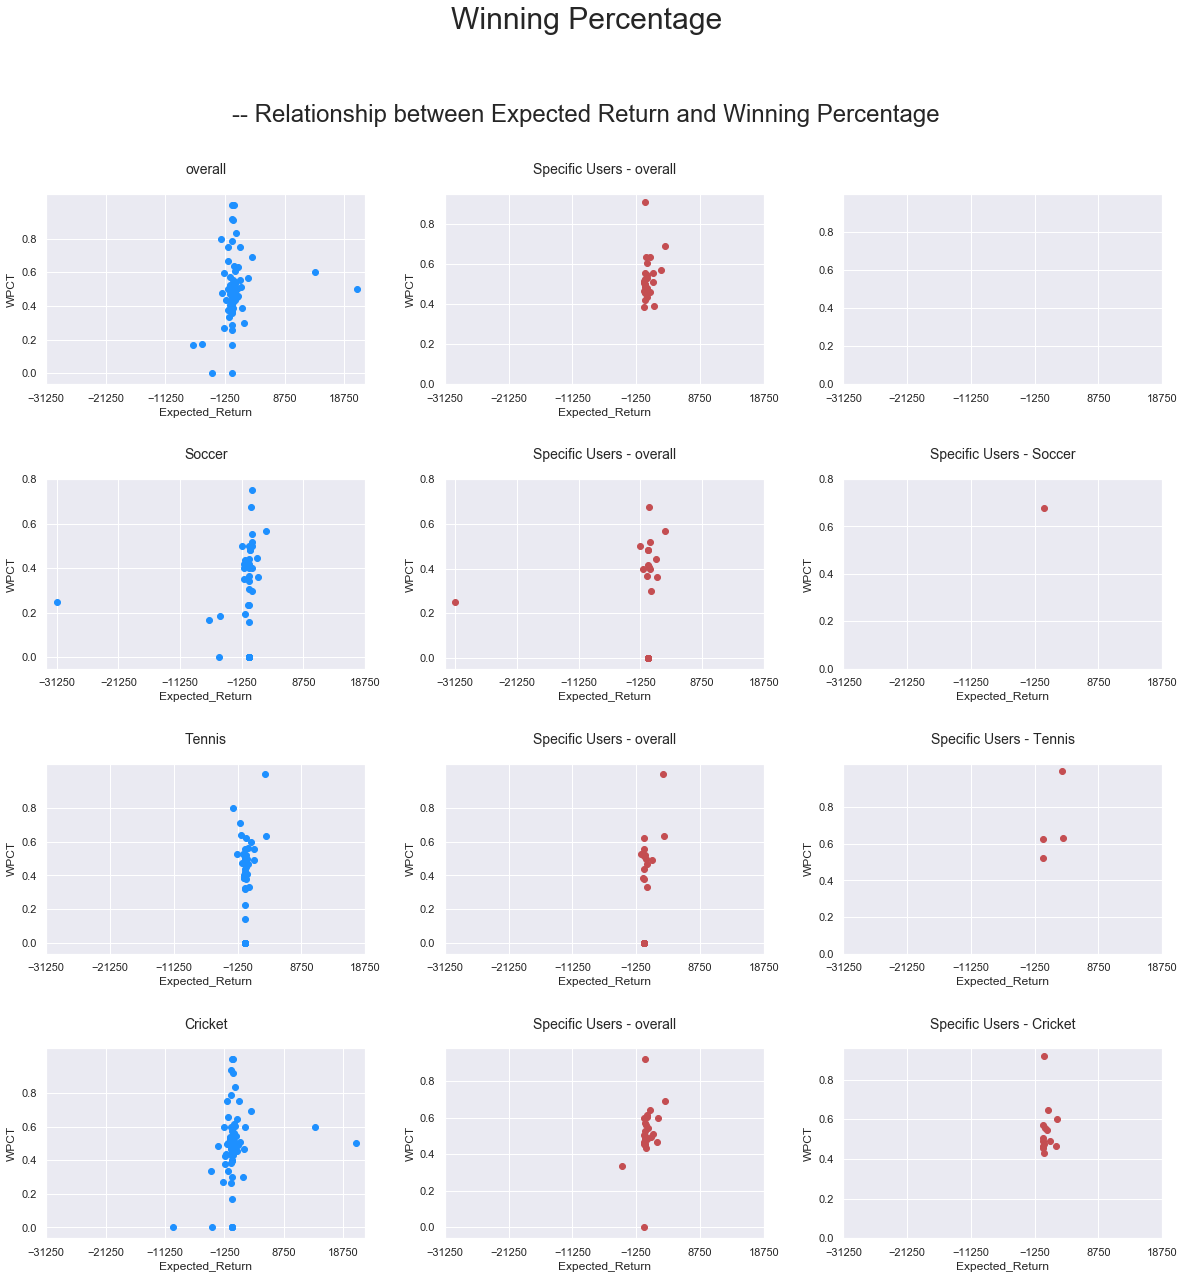

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [160]:
x_feature = "Expected_Return"
y_feature = "WPCT"
xticks_range = 10000
yticks_range = 0.2
suptitle = "Winning Percentage"
text = "Relationship between Expected Return and Winning Percentage"

scatter(x_feature, y_feature, xticks_range, yticks_range, suptitle, text) 

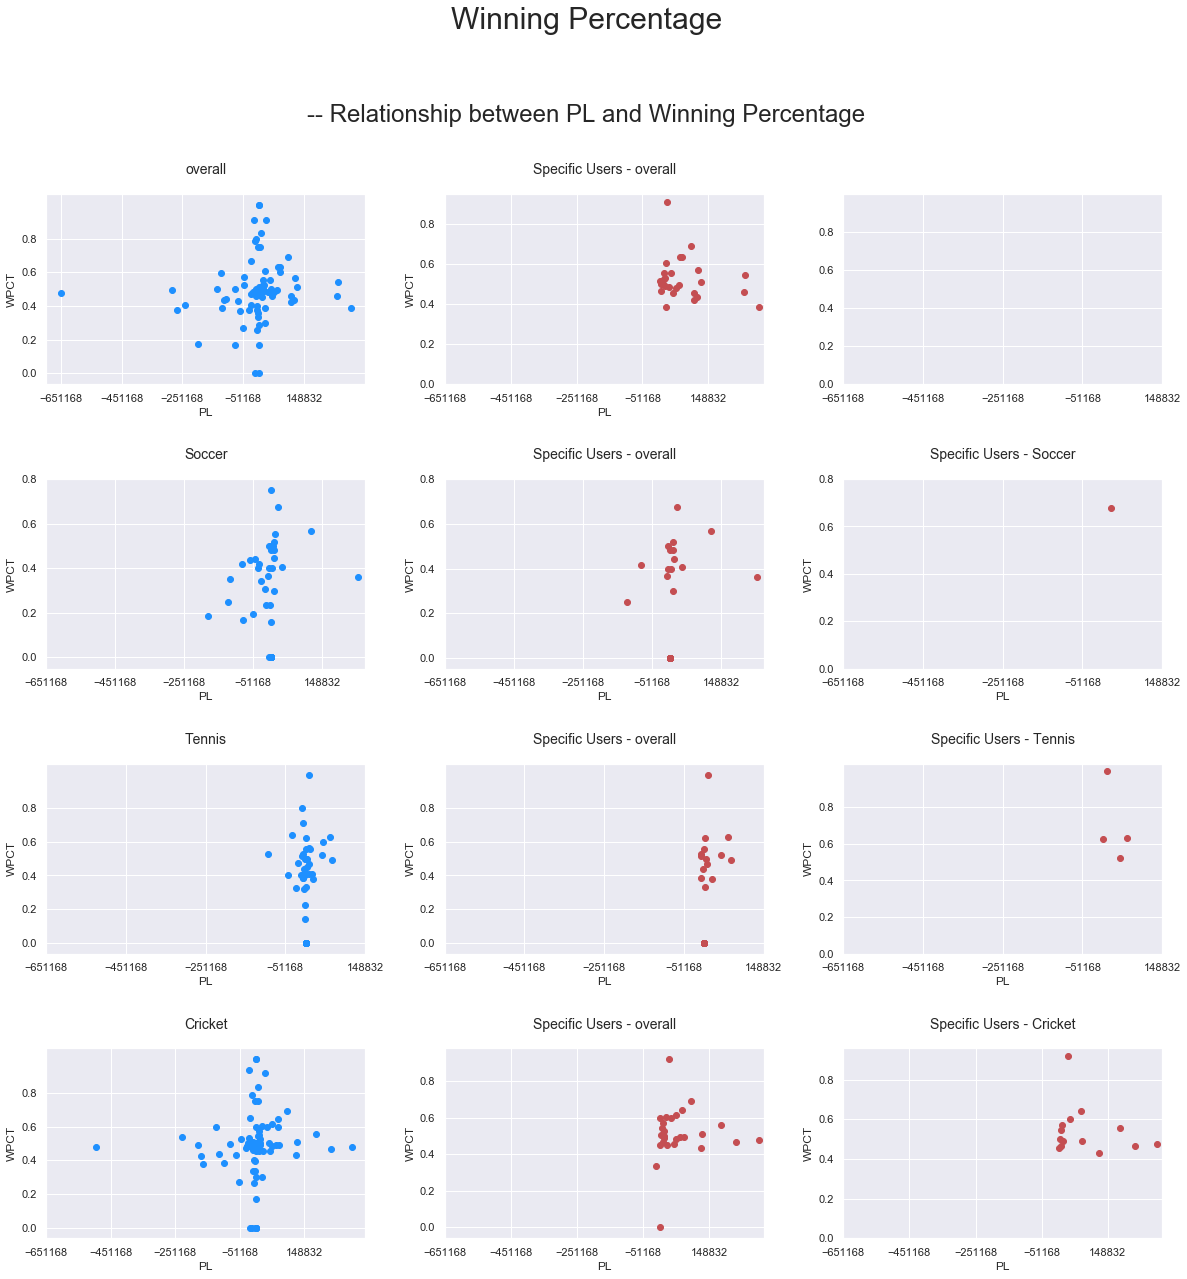

Specific Users - overall : 
['kick002', 'vikas786', 'bird26', 'company242424', 'kick003', 'phone06', 'am115', 'vikasg02', 'jsb01', 'am906', 'rajeshg01', 'bird03', 'bird30', 'princeg01', 'rajatg01', 'arung001', 'jmdg01', 'bird01', 'am122', 'bird00', 'rajatk01', 'anshk01', 'nov1000', 'nov3000', 'am903', 'bird27', 'shiv2424']
--
Specific Users - Soccer : 
['rajeshg01']
--
Specific Users - Tennis : 
['kick002', 'bird26', 'phone06', 'shiv2424']
--
Specific Users - Cricket : 
['bird26', 'vikasg02', 'vikas786', 'am115', 'phone06', 'am906', 'rajatg01', 'jmdg01', 'arung001', 'anshk01', 'am903', 'bird00', 'bird27', 'am122']
--


In [162]:
x_feature = "PL"
y_feature = "WPCT"
xticks_range = 200000
yticks_range = 0.2
suptitle = "Winning Percentage"
text = "Relationship between PL and Winning Percentage"

scatter(x_feature, y_feature, xticks_range, yticks_range, suptitle, text) 

-----------------

## By Market

> df_preprocess_Soccer

> df_preprocess_Tennis

> df_preprocess_Cricket

In [228]:
eventName = ["Soccer", "Tennis", "Cricket"]

In [229]:
# select each sprot out indivisually, in order to preprocess for each sport market

for i in range(0, len(eventName)) :
    exec(f'df_preprocess_{eventName[i]} = df_preprocess_eventall.loc[df_preprocess_eventall["eventTypeName"] == "{eventName[i]}", :]')
    
# df_preprocess_Soccer
# df_preprocess_Tennis
# df_preprocess_Cricket


In [230]:
# df_preprocess_{eventName[i]} - {eventName[i]}_winning_percentage

def winning_percentage_in_each_market(df_preprocess) :
    a1 = df_preprocess.groupby(["Member"])["Bet_ID"].count().reset_index().sort_values(by = "Bet_ID", ascending = False)
    a1.columns = ["Member", f"{eventName[i]}_Bet_num"]
    a2 = df_preprocess.groupby(["Member"])["Status_WON"].sum().reset_index().sort_values(by = "Status_WON", ascending = False)
    a2.columns = ["Member", f"{eventName[i]}_WON_num"]

    a1 = pd.merge(a1, a2, how = "right", on = ["Member"])
    a1[f"{eventName[i]}_winning_percentage"] = a1[f"{eventName[i]}_WON_num"] / a1[f"{eventName[i]}_Bet_num"]
    a1.sort_values(by = f"{eventName[i]}_winning_percentage", ascending = False)


    df_preprocess = pd.merge(df_preprocess, a1, how = "left", on = ["Member"])
    return df_preprocess


for i in range(0, len(eventName)) :
    exec(f'df_preprocess_{eventName[i]} = winning_percentage_in_each_market(df_preprocess_{eventName[i]})')



In [231]:
# df_preprocess_higher_win_pt_Soccer = df_preprocess_Soccer.loc[:, ["Member", "overall_winning_percentage", "Soccer_winning_percentage"]] \
# .drop_duplicates().reset_index(drop = True).sort_values(by = "Soccer_winning_percentage", ascending = False)

# df_preprocess_higher_win_pt_Soccer[df_preprocess_higher_win_pt_Soccer["overall_winning_percentage"] < df_preprocess_higher_win_pt_Soccer["Soccer_winning_percentage"]]


In [232]:
# member tendancy - by winning percentage

def member_tendancy_by_winning_percentage(df_preprocess_Soccer):
    df_preprocess_higher_win_pt_Soccer = df_preprocess_Soccer.loc[:, ["Member", "overall_winning_percentage", f"{eventName[i]}_winning_percentage"]] \
.drop_duplicates().reset_index(drop = True).sort_values(by = f"{eventName[i]}_winning_percentage", ascending = False)

    return df_preprocess_higher_win_pt_Soccer[df_preprocess_higher_win_pt_Soccer["overall_winning_percentage"] < df_preprocess_higher_win_pt_Soccer[f"{eventName[i]}_winning_percentage"]]["Member"].values.tolist()

for i in range(0, len(eventName)) :
    exec(f'good_at_{eventName[i]} = member_tendancy_by_winning_percentage(df_preprocess_{eventName[i]})')


# good_at_Soccer
# good_at_Tennis
# good_at_Cricket

/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [233]:
## 各市場的好手名單
# good_at_Soccer
# good_at_Tennis
# good_at_Cricket

In [234]:
# 淨獲利＆期望回報
def get_Expected_Return(df_test) :

    def get_AvgProfit(df_preprocess, status) :
        df = df_preprocess.loc[df_preprocess["Status"] == f"{status}", :]
        df_sum = df.groupby(["Member"])["Member_Win_Loss"].sum().reset_index()
        df_sum.columns = ["Member", f"sum_of_Member_{status}"]
        df_count = df.groupby(["Member"])["Member_Win_Loss"].count().reset_index()
        df_count.columns = ["Member", f"count_of_Member_{status}"]

        df = pd.merge(df_sum, df_count, on = ["Member"])
        df[f"Avg_{status}"] = df[f"sum_of_Member_{status}"] / df[f"count_of_Member_{status}"]
        return df

    won = get_AvgProfit(df_test, "WON")
    lost = get_AvgProfit(df_test, "LOST")
#     mem = pd.merge(won, lost, how = "inner", on = ["Member"])

    dfs = [df_test[["Member"]].drop_duplicates(), won, lost]
    mem = (reduce(lambda left,right: pd.merge(left, right, how = "outer", on = ["Member"]), dfs)).fillna(0)
    
    mem[["sum_of_Member_WON", "count_of_Member_WON", "Avg_WON", "sum_of_Member_LOST", "count_of_Member_LOST", "Avg_LOST"]] = mem[["sum_of_Member_WON", "count_of_Member_WON", "Avg_WON", "sum_of_Member_LOST", "count_of_Member_LOST", "Avg_LOST"]].fillna(value=0)
    mem["overall_winning_percentage"] = mem["count_of_Member_WON"] / (mem["count_of_Member_WON"] + mem["count_of_Member_LOST"])
    mem["Expected_Return"] = mem["Avg_WON"] * mem["overall_winning_percentage"] + mem["Avg_LOST"] * (1-mem["overall_winning_percentage"])

    df_test_2 = df_test.groupby(["Member"])["Member_Win_Loss"].sum().reset_index()
    df_test_2.columns = ["Member", "PL"]
    mem = pd.merge(mem, df_test_2, how = "outer", on = ["Member"])

    # 取前80%的下單次數（濾掉剛開始玩卻剛好運氣好的那種）
    # mem = mem[(mem["count_of_Member_WON"] + mem["count_of_Member_LOST"]) > (30)]
    mem = mem[(mem["count_of_Member_WON"] + mem["count_of_Member_LOST"]) > (np.percentile((mem["count_of_Member_WON"] + mem["count_of_Member_LOST"]), 20))]
    
    # sort by  "淨獲利", "期望回報", "勝場數多的"
    mem = mem.sort_values(by = ["PL", "Expected_Return", "count_of_Member_WON"], ascending = [False, False, False]).reset_index(drop = True)
    # 取 "淨獲利", "期望回報" > 0
    mem = mem[(mem["Expected_Return"] > 0) & (mem["PL"] > 0)].reset_index(drop = True)

    df_test_2 = df_test[["Member", "AVG_bet_amount_per_person"]].drop_duplicates()
    mem = pd.merge(mem, df_test_2, how = "left", on = ["Member"])

    return mem

mem = get_Expected_Return(df_test)
RiskControll_mem = get_Expected_Return(df_test)["Member"].tolist()

mem


,Member,sum_of_Member_WON,count_of_Member_WON,Avg_WON,sum_of_Member_LOST,count_of_Member_LOST,Avg_LOST,overall_winning_percentage,Expected_Return,PL,AVG_bet_amount_per_person
0,kick002,9.986189e+05,76.0,13139.722862,-6.967604e+05,120.0,-5806.336458,0.387755,1540.094707,301858.562500,0.057898
1,vikas786,4.377932e+06,328.0,13347.352134,-4.087138e+06,275.0,-14862.320000,0.543947,482.244610,290793.562500,0.037632
2,phone06,1.232349e+06,156.0,7899.673077,-9.672931e+05,173.0,-5591.289379,0.474164,805.641147,265055.906250,0.121225
3,kick003,2.895479e+05,25.0,11581.916250,-1.716400e+05,19.0,-9033.684211,0.568182,2679.725142,117907.898438,0.450220
4,am115,1.185245e+06,263.0,4506.634030,-1.069834e+06,360.0,-2971.762500,0.422151,185.249197,115410.234375,-0.092902
5,vikasg02,1.457360e+06,54.0,26988.148148,-1.351085e+06,64.0,-21110.699219,0.457627,900.637712,106275.226562,0.034076
6,company242424,1.029333e+06,68.0,15137.251838,-9.319964e+05,67.0,-13910.393657,0.503704,721.012963,97336.773438,0.064467
7,am906,3.091759e+05,81.0,3816.986497,-2.162350e+05,52.0,-4158.365385,0.609023,698.803806,92940.921875,0.192481
8,rajatk01,4.858037e+05,164.0,2962.217797,-4.055572e+05,155.0,-2616.498387,0.514107,251.556328,80246.460938,-0.021987
9,jsb01,2.673942e+05,25.0,10695.770000,-1.929910e+05,17.0,-11352.411765,0.595238,1771.505952,74403.242188,0.057476


In [235]:
# mem[mem["Member"]=="bird99"]

In [237]:
# # VOID, INVALID
# VO_INV_mem = df_suspicious_rec.loc[((df_suspicious_rec["suspicious_rec"] > np.percentile(df_suspicious_rec["suspicious_rec"], 80)) & \
#                 (df_suspicious_rec["suspicious_rate"] > np.percentile(df_suspicious_rec["suspicious_rate"], 80))\
#               | (df_suspicious_rec["suspicious_rec"] > np.percentile(df_suspicious_rec["suspicious_rec"], 95))), :]["Member"].tolist()



In [854]:
# 其實最後我取聯集啦
inner_black = []
inner_black.extend(RiskControll_mem)
inner_black.extend(df_win_pt) 
# inner_black.extend(VO_INV_mem)
inner_black = set(inner_black)

In [855]:
mem = mem.loc[mem["Member"].isin(inner_black), :]

In [856]:
VO_INV_mem

['bird26', 'bird27', 'am333', 'bird29', 'am905']

In [857]:
mem.loc[mem["Member"] == "bird27",:]

,Member,sum_of_Member_WON,count_of_Member_WON,Avg_WON,sum_of_Member_LOST,count_of_Member_LOST,Avg_LOST,winning_percentage,Expected_Return,PL,AVG_bet_amount_per_person


In [832]:
df_test.loc[df_test["Member"] == "bird27",:]

,Member,Placed,Selection,Bet_ID,In_Play,One_Click,Type,Odds,Stake,Status,...,eventTypeName,Placed_ms_mST,Stake_d_totalMatched,win_loss_ratio,AVG_bet_amount_per_person,Std_bet_amount_per_person,AVG_Odds_per_person,Std_Odds_per_person,AVG_Stake_per_person,Std_Stake_per_person
16586,bird27,16/02/2019 19:42:54,240 Runs,1902161142536416,1,0,No,100.00,600.0,LOST,...,Cricket,1 days 03:42:54,0.000026,-1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359
16587,bird27,16/02/2019 19:43:01,240 Runs,1902161143006454,1,0,No,100.00,600.0,LOST,...,Cricket,1 days 03:43:01,0.000026,-1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359
16588,bird27,16/02/2019 20:05:24,238 Runs,1902161205232645,1,0,Yes,100.00,400.0,WON,...,Cricket,1 days 04:05:24,0.000017,1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359
16589,bird27,16/02/2019 20:05:39,238 Runs,1902161205382767,1,0,Yes,100.00,200.0,WON,...,Cricket,1 days 04:05:39,0.000009,1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359
16590,bird27,16/02/2019 20:07:53,239 Runs,1902161207524653,1,0,Yes,100.00,600.0,WON,...,Cricket,1 days 04:07:53,0.000026,1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359
16591,bird27,16/02/2019 20:08:52,243 Runs,1902161208515624,1,0,No,100.00,400.0,LOST,...,Cricket,1 days 04:08:52,0.000017,-1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359
16592,bird27,16/02/2019 20:09:52,243 Runs,1902161209516768,1,0,No,100.00,400.0,LOST,...,Cricket,1 days 04:09:52,0.000017,-1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359
16593,bird27,16/02/2019 20:17:25,249 Runs,1902161217242541,1,0,No,100.00,600.0,LOST,...,Cricket,1 days 04:17:25,0.000026,-1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359
16594,bird27,16/02/2019 20:17:33,249 Runs,1902161217322624,1,0,No,100.00,600.0,LOST,...,Cricket,1 days 04:17:33,0.000026,-1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359
16595,bird27,15/02/2019 21:11:35,South Africa,1902151311357974,1,0,Back,1.24,3000.0,LOST,...,Cricket,0 days 05:11:35,0.000131,-1.00,0.003459,0.829973,31.227472,55.620148,2101.059326,2308.068359


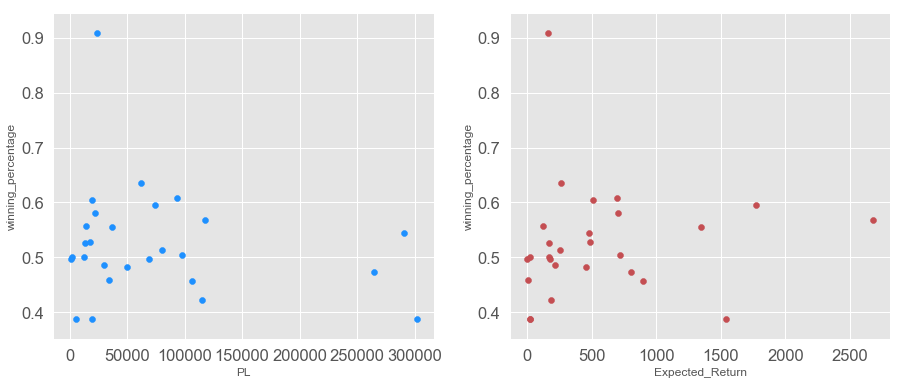

In [791]:
# plot - scatter plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15, 6))


# plot 1 - overall
ax1.scatter(mem["PL"], mem["winning_percentage"], marker="o", color="dodgerblue") # c
ax1.set(xlabel = 'PL', ylabel = 'winning_percentage')



# plot 2 - contrast
ax2.scatter(mem["Expected_Return"], mem["winning_percentage"], marker="o", color="r")
ax2.set(xlabel = 'Expected_Return', ylabel = 'winning_percentage')


# # legend
# ax1.legend(["Admitted"])
# ax2.legend(["Not-Admitted"])

plt.show()


In [ ]:
"""
select 
sum(MEMBERWinLoss) as PL,
count(1) as BetTimes, 
(count(case Betstatus when 'WON' then 1 end)/count(1))*100 as WinRatio,
sum(if(MEMBERWinLoss>0,MEMBERWinLoss,0))/(count(case Betstatus when 'WON' then 1 end)) as AvgWin,
sum(if(MEMBERWinLoss<0,MEMBERWinLoss,0))/(count(case Betstatus when 'LOST' then 1 end)) as AvgLose,
sum(if(MEMBERWinLoss>0,MEMBERWinLoss,0))/(count(case Betstatus when 'WON' then 1 end))*(count(case Betstatus when 'WON' then 1 end)/count(1))+sum(if(MEMBERWinLoss<0,MEMBERWinLoss,0))/(count(case Betstatus when 'LOST' then 1 end))*(1-(count(case Betstatus when 'WON' then 1 end)/count(1))) as Expected,
MemberLoginName 
from betlist_settled 
where CONCAT(substr(placedGMT,7,4),substr(placedGMT,4,2),substr(placedGMT,1,2)) between '20180801' and '20190311'
and betstatus in ('WON','LOST')
group by MemberLoginName 
order by PL desc;
"""

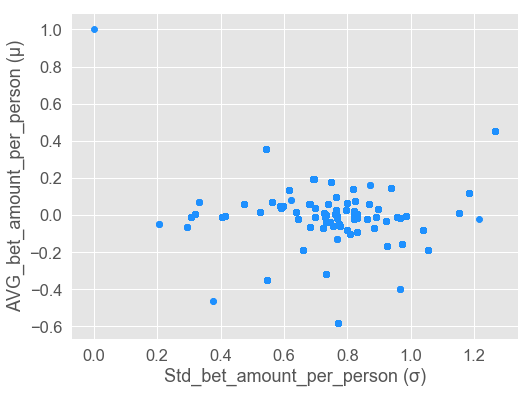

In [170]:
# plot - scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.scatter(df_test["Std_bet_amount_per_person"], df_test["AVG_bet_amount_per_person"], marker='o', color='dodgerblue')

sns.set(font_scale = 1.5) # font size
plt.xlabel('Std_bet_amount_per_person (σ)', fontsize = 18) # ax.set_xlabel('Status, Type',fontsize=14)
plt.ylabel('AVG_bet_amount_per_person (μ)', fontsize = 18) # ax.set_ylabel('Member_Win_Loss',fontsize=14) 

# plt.xlim(-0.1, 5.5)
# plt.ylim(-2, 2)

plt.style.use('ggplot')
plt.show()

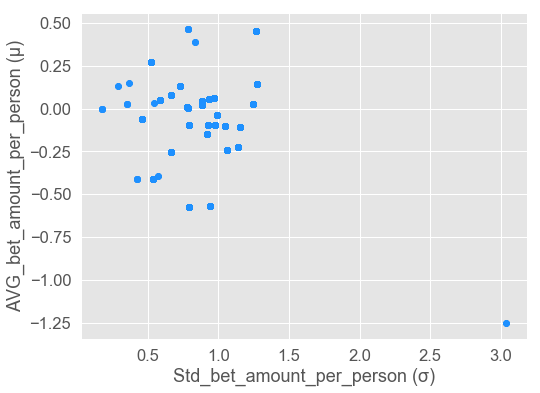

In [171]:
# plot - scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.scatter(df_test_Soccer["Std_bet_amount_per_person"], df_test_Soccer["AVG_bet_amount_per_person"], marker='o', color='dodgerblue')

sns.set(font_scale = 1.5) # font size
plt.xlabel('Std_bet_amount_per_person (σ)', fontsize = 18) # ax.set_xlabel('Status, Type',fontsize=14)
plt.ylabel('AVG_bet_amount_per_person (μ)', fontsize = 18) # ax.set_ylabel('Member_Win_Loss',fontsize=14) 

# plt.xlim(-0.1, 5.5)
# plt.ylim(-2, 2)

plt.style.use('ggplot')
plt.show()

In [529]:
df1.columns

Index(['Member', 'overall_count', 'overall_PL', 'overall_WON_count',
       'overall_WON_sum', 'overall_LOST_count', 'overall_LOST_sum',
       'overall_WPCT', 'overall_Expected_Return', 'overall_AVG_win_loss_ratio',
       'overall_Std_win_loss_ratio', 'overall_AVG_Odds', 'overall_Std_Odds',
       'overall_AVG_Stake', 'overall_Std_Stake', 'Soccer_PL', 'Soccer_count',
       'Soccer_WON_count', 'Soccer_WON_sum', 'Soccer_LOST_count',
       'Soccer_LOST_sum', 'Soccer_WPCT', 'Soccer_Expected_Return',
       'Soccer_AVG_win_loss_ratio', 'Soccer_Std_win_loss_ratio',
       'Soccer_AVG_Odds', 'Soccer_Std_Odds', 'Soccer_AVG_Stake',
       'Soccer_Std_Stake', 'Tennis_PL', 'Tennis_count', 'Tennis_WON_count',
       'Tennis_WON_sum', 'Tennis_LOST_count', 'Tennis_LOST_sum', 'Tennis_WPCT',
       'Tennis_Expected_Return', 'Tennis_AVG_win_loss_ratio',
       'Tennis_Std_win_loss_ratio', 'Tennis_AVG_Odds', 'Tennis_Std_Odds',
       'Tennis_AVG_Stake', 'Tennis_Std_Stake', 'Cricket_PL', 'Cricket_cou

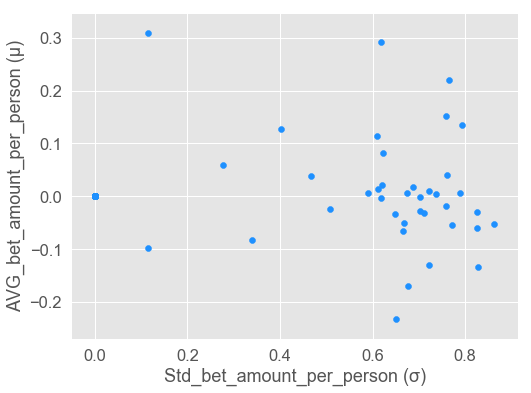

In [531]:
# plot - scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.scatter(df1["Tennis_Std_win_loss_ratio"], df1["Tennis_AVG_win_loss_ratio"], marker='o', color='dodgerblue')

sns.set(font_scale = 1.5) # font size
plt.xlabel('Std_bet_amount_per_person (σ)', fontsize = 18) # ax.set_xlabel('Status, Type',fontsize=14)
plt.ylabel('AVG_bet_amount_per_person (μ)', fontsize = 18) # ax.set_ylabel('Member_Win_Loss',fontsize=14) 

# plt.xlim(-0.1, 5.5)
# plt.ylim(-2, 2)

plt.style.use('ggplot')
plt.show()

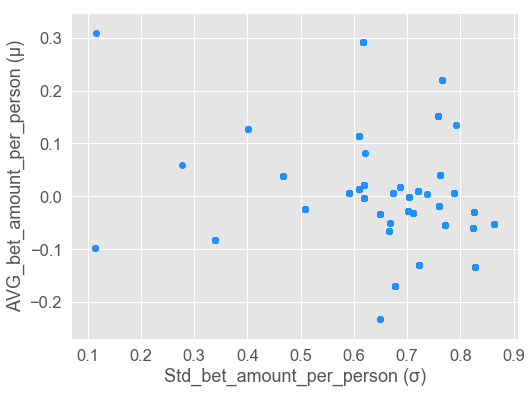

In [155]:
# plot - scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.scatter(df_test_Tennis["Std_bet_amount_per_person"], df_test_Tennis["AVG_bet_amount_per_person"], marker='o', color='dodgerblue')

sns.set(font_scale = 1.5) # font size
plt.xlabel('Std_bet_amount_per_person (σ)', fontsize = 18) # ax.set_xlabel('Status, Type',fontsize=14)
plt.ylabel('AVG_bet_amount_per_person (μ)', fontsize = 18) # ax.set_ylabel('Member_Win_Loss',fontsize=14) 

# plt.xlim(-0.1, 5.5)
# plt.ylim(-2, 2)

plt.style.use('ggplot')
plt.show()

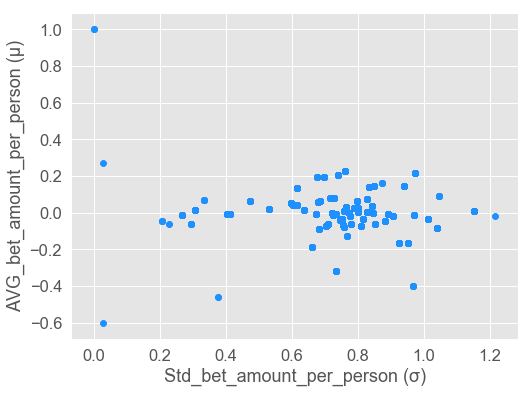

In [156]:
# plot - scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.scatter(df_test_Cricket["Std_bet_amount_per_person"], df_test_Cricket["AVG_bet_amount_per_person"], marker='o', color='dodgerblue')

sns.set(font_scale = 1.5) # font size
plt.xlabel('Std_bet_amount_per_person (σ)', fontsize = 18) # ax.set_xlabel('Status, Type',fontsize=14)
plt.ylabel('AVG_bet_amount_per_person (μ)', fontsize = 18) # ax.set_ylabel('Member_Win_Loss',fontsize=14) 

# plt.xlim(-0.1, 5.5)
# plt.ylim(-2, 2)

plt.style.use('ggplot')
plt.show()

## Black List 

> df_inner_black

### Method 1 to require black list

> μ在前幾名, σ在前幾名

潛在風險用戶名單(μ在前30名, σ在前30名) : 
['bird01', 'am666', 'anshk01', 'nov1000', 'stamp01', 'arung001', 'am902', 'leeds001', 'rajatg01', 'pun990', 'jsb01', 'vikas786', 'am128', 'nov3000', 'am906']


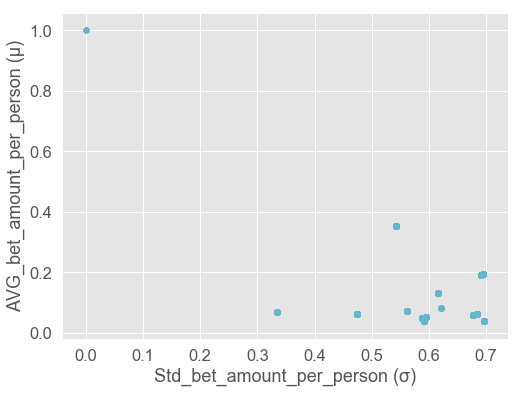

In [159]:
# # 整理
# df_preprocess["win_loss_ratio"] = df_preprocess["Member_Win_Loss"] / df_preprocess["Stake"]

# df_test = None
# df_1 = df_preprocess.groupby(['Member'])["win_loss_ratio"].mean().reset_index()
# df_2 = df_preprocess.groupby(['Member'])["win_loss_ratio"].std().reset_index()
# df_1.columns = ["Member", "AVG_bet_amount_per_person"]
# df_2.columns = ["Member", "Std_bet_amount_per_person"]

# df_test = pd.merge(df_1, df_2, how = "inner", on = ["Member"])
# df_test = pd.merge(df_preprocess, df_test, how = "inner", on = ["Member"])




# black list method 1
(μ在前幾名, σ在前幾名) = (30, 30)
sortlist_AVG_bet_amount_per_person = df_test.sort_values(by = "AVG_bet_amount_per_person", ascending = False)["Member"].unique().tolist()
sortlist_Std_bet_amount_per_person = df_test.sort_values(by = "Std_bet_amount_per_person", ascending = True)["Member"].unique().tolist()
black_list = list(set(sortlist_AVG_bet_amount_per_person[:μ在前幾名]) & set(sortlist_Std_bet_amount_per_person[0:σ在前幾名]))

df_test2 = df_test.copy()
df_test2 = df_test2.loc[df_test2["Member"].isin(black_list), :]
print("潛在風險用戶名單(μ在前%s名, σ在前%s名) : \n%s" % (μ在前幾名, σ在前幾名, black_list))


## black list method 2
# (μ, σ) = (0.1, 1)
# df_test2 = df_test.loc[(df_test["AVG_bet_amount_per_person"] > μ) & (df_test["Std_bet_amount_per_person"] < σ)]
# black_list_2 = df_test2["Member"].unique().tolist()
# print("潛在風險用戶名單(μ > %s, σ < %s) : \n%s" % (μ, σ, black_list_2))





# plot - scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.scatter(df_test2["Std_bet_amount_per_person"], df_test2["AVG_bet_amount_per_person"], marker='o', color='c')

sns.set(font_scale = 1.5) # font size
plt.xlabel('Std_bet_amount_per_person (σ)', fontsize = 18) # ax.set_xlabel('Status, Type',fontsize=14)
plt.ylabel('AVG_bet_amount_per_person (μ)', fontsize = 18) # ax.set_ylabel('Member_Win_Loss',fontsize=14) 

# plt.xlim(-0.1, 5)
# plt.ylim(-0.76, 1.05)
plt.style.use('ggplot')
plt.show()

### Method 2 to require black list

> μ > %s, σ < %s

潛在風險用戶名單(μ > 0.1, σ < 1) : 
['rajatk03', 'am906', 'amss09', 'am902', 'pun990', 'ashish2425', 'stamp01', 'bird16', 'am128']


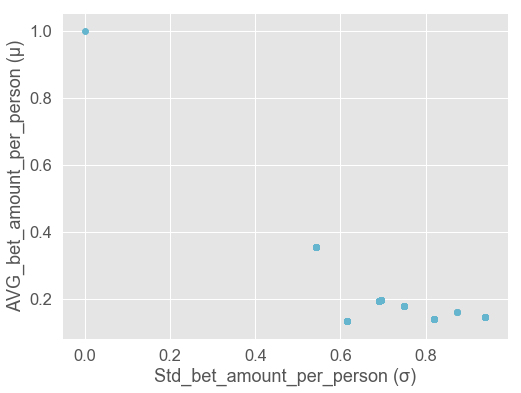

In [160]:
# # 整理
# df_preprocess["win_loss_ratio"] = df_preprocess["Member_Win_Loss"] / df_preprocess["Stake"]

# df_test = None
# df_1 = df_preprocess.groupby(['Member'])["win_loss_ratio"].mean().reset_index()
# df_2 = df_preprocess.groupby(['Member'])["win_loss_ratio"].std().reset_index()
# df_1.columns = ["Member", "AVG_bet_amount_per_person"]
# df_2.columns = ["Member", "Std_bet_amount_per_person"]

# df_test = pd.merge(df_1, df_2, how = "inner", on = ["Member"])
# df_test = pd.merge(df_preprocess, df_test, how = "inner", on = ["Member"])




# # black list method 1
# (μ在前幾名, σ在前幾名) = (70, 70)
# sortlist_AVG_bet_amount_per_person = df_test.sort_values(by = "AVG_bet_amount_per_person", ascending = False)["Member"].unique().tolist()
# sortlist_Std_bet_amount_per_person = df_test.sort_values(by = "Std_bet_amount_per_person", ascending = True)["Member"].unique().tolist()
# black_list = list(set(sortlist_AVG_bet_amount_per_person[:μ在前幾名]) & set(sortlist_Std_bet_amount_per_person[0:σ在前幾名]))

# df_test2 = df_test.copy()
# df_test2 = df_test2.loc[df_test2["Member"].isin(black_list), :]
# print("潛在風險用戶名單(μ大, σ小) : %s" % black_list)


# black list method 2
(μ, σ) = (0.1, 1)
df_test2 = df_test.loc[(df_test["AVG_bet_amount_per_person"] > μ) & (df_test["Std_bet_amount_per_person"] < σ)]
black_list_2 = df_test2["Member"].unique().tolist()
print("潛在風險用戶名單(μ > %s, σ < %s) : \n%s" % (μ, σ, black_list_2))





# plot - scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

ax = plt.scatter(df_test2["Std_bet_amount_per_person"], df_test2["AVG_bet_amount_per_person"], marker='o', color='c')

sns.set(font_scale = 1.5) # font size
plt.xlabel('Std_bet_amount_per_person (σ)', fontsize = 18) # ax.set_xlabel('Status, Type',fontsize=14)
plt.ylabel('AVG_bet_amount_per_person (μ)', fontsize = 18) # ax.set_ylabel('Member_Win_Loss',fontsize=14) 

# plt.xlim(-0.1, 5)
# plt.ylim(-0.76, 1.05)
plt.style.use('ggplot')
plt.show()


### inner_blacklist

> df_inner_black

In [161]:
inner_blacklist = list(set(black_list) & set(black_list_2))
print("同時符合這兩種篩選條件的名單 : \n%s" % inner_blacklist)

同時符合這兩種篩選條件的名單 : 
['stamp01', 'am902', 'pun990', 'am128', 'am906']


In [395]:
# inner black
df_inner_black = df_test.loc[df_test["Member"].isin(inner_blacklist), :]

## EDA - Overall vs BlackList

## Bar plot - Template

> Y : .count()

In [396]:
"""
figsize_tuple = (12, 9) # figure_size

df_overall = df_test
df_black = df_inner_black

groupby_col = 'Status'
sum_or_count_col = "Type_Lay"
set_order = ["LOST", "WON", "VOID", "INVALID"]

subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'Frequency'
xlabel_words = 'Status'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation
"""

"""
plt.subplots_adjust()
"""


def allvsblack_barplot_freq(figsize_tuple, set_order, df_overall, df_black, groupby_col, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = figsize_tuple)


    set_order = set_order # order of x-axis

    
    # plot 1 - overall
    
#     # other constrains 
#     df_test = df_preprocess.loc[df_preprocess["Type_Lay"] == 1, :]
    
    ax1 = df_overall.groupby([groupby_col]).count()[sum_or_count_col].loc[set_order].plot(kind = 'bar', ax = ax1, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    total = float(len(df_overall)) 
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 
    
    ax1.set_title("Overall", size = subplot_ttl_font, pad = ttl_hight_to_plots)   # fig.suptitle("Overall")
    ax1.set_xlabel(xlabel_words, fontsize = fontsize)
    ax1.set_ylabel(ylabel_words, fontsize = fontsize)   
#     ax1.set_ylim([0, 30000])

    # plot 2 - contrast
#     # other constrains 
#     df_test = df_preprocess.loc[df_preprocess["Type_Back"] == 1, :]
    
    ax2 = df_black.groupby([groupby_col]).count()[sum_or_count_col].loc[set_order].plot(kind = 'bar', ax = ax2, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    total = float(len(df_black)) 
    for p in ax2.patches:
        height = p.get_height()
        ax2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 
    
    ax2.set_title("Specific Users", size = subplot_ttl_font, pad = ttl_hight_to_plots) # fig.suptitle("Specific Users")
    ax2.set_xlabel(xlabel_words, fontsize = fontsize)
    ax2.set_ylabel(ylabel_words, fontsize = fontsize)   
#     ax2.set_ylim([0, 30000])


    # control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
    plt.style.use('ggplot')
    
    sns.set(font_scale = font_scale) # font size
    sns.set(style = "darkgrid")
    plt.xticks(rotation = xticks_rotat) # x-axis 字體方向

    plt.show()
    
    print("Specific Users : \n%s" % inner_blacklist)


In [397]:
def allvsblack_barplot_freq_with2groupedcol(figsize_tuple, df_overall, df_black, groupby_col_1, groupby_col_2, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat):
    

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = figsize_tuple)


    # plot 1 - overall

    #     # other constrains 
    #     df_test = df_preprocess.loc[df_preprocess["Type_Lay"] == 1, :]

    ax1 = df_overall.groupby([groupby_col_1, groupby_col_2]).count()[sum_or_count_col].plot(kind = 'bar', ax = ax1, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    total = float(len(df_overall)) 
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 

    ax1.set_title("Overall", size = subplot_ttl_font, pad = ttl_hight_to_plots)   # fig.suptitle("Overall")
    ax1.set_xlabel(xlabel_words, fontsize = fontsize)
    ax1.set_ylabel(ylabel_words, fontsize = fontsize)   
    #     ax1.set_ylim([0, 30000])

    # plot 2 - contrast
    #     # other constrains 
    #     df_test = df_preprocess.loc[df_preprocess["Type_Back"] == 1, :]

    ax2 = df_black.groupby([groupby_col_1, groupby_col_2]).count()[sum_or_count_col].plot(kind = 'bar', ax = ax2, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    total = float(len(df_black)) 
    for p in ax2.patches:
        height = p.get_height()
        ax2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 

    ax2.set_title("Specific Users", size = subplot_ttl_font, pad = ttl_hight_to_plots) # fig.suptitle("Specific Users")
    ax2.set_xlabel(xlabel_words, fontsize = fontsize)
    ax2.set_ylabel(ylabel_words, fontsize = fontsize)   
    #     ax2.set_ylim([0, 30000])


    # control all plots
    #     plt.title("Specific Users")
    #     plt.xlim(-0.1, 5)
    #     plt.ylim(-0.76, 1.05)
    plt.style.use('ggplot')

    sns.set(font_scale = font_scale) # font size
    sns.set(style = "darkgrid")
    plt.xticks(rotation = xticks_rotat) # x-axis 字體方向

    plt.show()

    print("Specific Users : \n%s" % inner_blacklist)



> Y : .sum()

In [398]:
"""
figsize_tuple = (12, 9) # figure_size

df_overall = df_test
df_black = df_inner_black

groupby_col = 'Status'
sum_or_count_col = "Type_Lay"
set_order = ["LOST", "WON", "VOID", "INVALID"]

subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'Frequency'
xlabel_words = 'Status'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation
"""

"""
plt.subplots_adjust()
"""


def allvsblack_barplot_sum(figsize_tuple, set_order, df_overall, df_black, groupby_col, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = figsize_tuple)


    set_order = set_order # order of x-axis

    
    # plot 1 - overall
    
#     # other constrains 
#     df_test = df_preprocess.loc[df_preprocess["Type_Lay"] == 1, :]
    
    ax1 = df_overall.groupby([groupby_col]).sum()[sum_or_count_col].loc[set_order].plot(kind = 'bar', ax = ax1, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    # 先分組相加得到各組總和，再apply各組元素得到各個絕對值，再相加得到total
    total = float(df_overall.groupby([groupby_col])[sum_or_count_col].sum().apply(lambda x: abs(x)).sum())
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 
    
    ax1.set_title("Overall", size = subplot_ttl_font, pad = ttl_hight_to_plots)   # fig.suptitle("Overall")
    ax1.set_xlabel(xlabel_words, fontsize = fontsize)
    ax1.set_ylabel(ylabel_words, fontsize = fontsize)   
#     ax1.set_ylim([0, 30000])

    # plot 2 - contrast
#     # other constrains 
#     df_test = df_preprocess.loc[df_preprocess["Type_Back"] == 1, :]
    
    ax2 = df_black.groupby([groupby_col]).sum()[sum_or_count_col].loc[set_order].plot(kind = 'bar', ax = ax2, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    # 分先分組相加得到各組總和，再apply各組元素得到各個絕對值，再相加得到total
    total = float(df_black.groupby([groupby_col])[sum_or_count_col].sum().apply(lambda x: abs(x)).sum())
    for p in ax2.patches:
        height = p.get_height()
        ax2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 
    
    ax2.set_title("Specific Users", size = subplot_ttl_font, pad = ttl_hight_to_plots) # fig.suptitle("Specific Users")
    ax2.set_xlabel(xlabel_words, fontsize = fontsize)
    ax2.set_ylabel(ylabel_words, fontsize = fontsize)   
#     ax2.set_ylim([0, 30000])


    # control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
    plt.style.use('ggplot')
    
    sns.set(font_scale = font_scale) # font size
    sns.set(style = "darkgrid")
    plt.xticks(rotation = xticks_rotat) # x-axis 字體方向

    plt.show()
    
    print("Specific Users : \n%s" % inner_blacklist)


In [399]:
"""
y - sum of Member_Win_Loss
x - 
"""
"""
figsize_tuple = (12, 9) # figure_size

df_overall = df_test
df_black = df_inner_black

groupby_col = 'Type'
sum_or_count_col = "Member_Win_Loss"
set_order = ["Back", "Yes", "Lay", "No"]

subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'Sum_of_Member_Win_Loss'
xlabel_words = 'Type'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation
"""
def allvsblack_barplot_sum_with2groupedcol(figsize_tuple, df_overall, df_black, groupby_col_1, groupby_col_2, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat):
    

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = figsize_tuple)


    # plot 1 - overall

    #     # other constrains 
    #     df_test = df_preprocess.loc[df_preprocess["Type_Lay"] == 1, :]

    ax1 = df_overall.groupby([groupby_col_1, groupby_col_2]).sum()[sum_or_count_col].plot(kind = 'bar', ax = ax1, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    # 先分組相加得到各組總和，再apply各組元素得到各個絕對值，再相加得到total
    total = float(df_overall.groupby([groupby_col_1, groupby_col_2])[sum_or_count_col].sum().apply(lambda x: abs(x)).sum())
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 

    ax1.set_title("Overall", size = subplot_ttl_font, pad = ttl_hight_to_plots)   # fig.suptitle("Overall")
    ax1.set_xlabel(xlabel_words, fontsize = fontsize)
    ax1.set_ylabel(ylabel_words, fontsize = fontsize)   
    #     ax1.set_ylim([0, 30000])

    # plot 2 - contrast
    #     # other constrains 
    #     df_test = df_preprocess.loc[df_preprocess["Type_Back"] == 1, :]

    ax2 = df_black.groupby([groupby_col_1, groupby_col_2]).sum()[sum_or_count_col].plot(kind = 'bar', ax = ax2, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    # 分先分組相加得到各組總和，再apply各組元素得到各個絕對值，再相加得到total
    total = float(df_black.groupby([groupby_col_1, groupby_col_2])[sum_or_count_col].sum().apply(lambda x: abs(x)).sum())
    for p in ax2.patches:
        height = p.get_height()
        ax2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 

    ax2.set_title("Specific Users", size = subplot_ttl_font, pad = ttl_hight_to_plots) # fig.suptitle("Specific Users")
    ax2.set_xlabel(xlabel_words, fontsize = fontsize)
    ax2.set_ylabel(ylabel_words, fontsize = fontsize)   
    #     ax2.set_ylim([0, 30000])


    # control all plots
    #     plt.title("Specific Users")
    #     plt.xlim(-0.1, 5)
    #     plt.ylim(-0.76, 1.05)
    plt.style.use('ggplot')

    sns.set(font_scale = font_scale) # font size
    sns.set(style = "darkgrid")
    plt.xticks(rotation = xticks_rotat) # x-axis 字體方向

    plt.show()

    print("Specific Users : \n%s" % inner_blacklist)



------------------

In [ ]:
# inner black
df_inner_black = df_preprocess_eventall.loc[df_preprocess_eventall["Member"].isin(inner_blacklist), :]

-------------

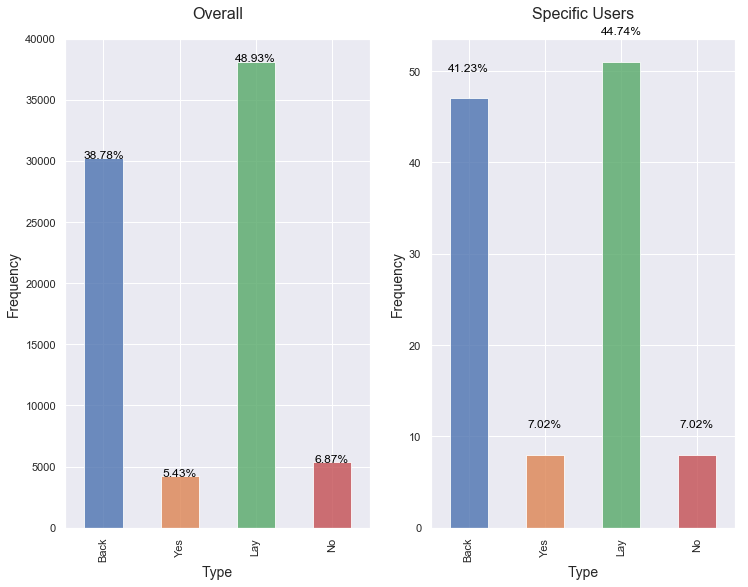

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [447]:
"""
y - Frequency
x - Type
"""
figsize_tuple = (12, 9) # figure_size

df_overall = df_test
df_black = df_inner_black

groupby_col = 'Type'
sum_or_count_col = "Type_Lay"
set_order = ["Back", "Yes", "Lay", "No"]

subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'Frequency'
xlabel_words = 'Type'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

# plot by function
allvsblack_barplot_freq(figsize_tuple, set_order, df_overall, df_black, groupby_col, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat)
   

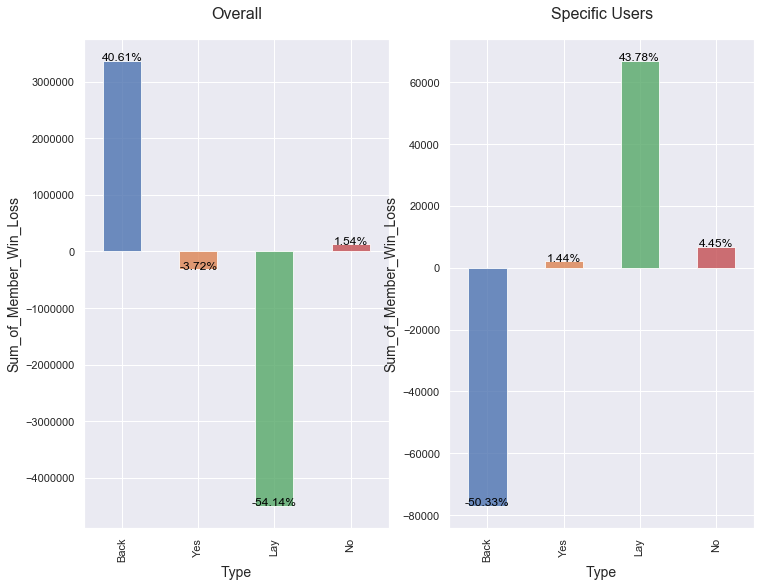

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [401]:
"""
y - sum of Member_Win_Loss
x - Type
"""
figsize_tuple = (12, 9) # figure_size

df_overall = df_test
df_black = df_inner_black

groupby_col = 'Type'
sum_or_count_col = "Member_Win_Loss"
set_order = ["Back", "Yes", "Lay", "No"]

subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'Sum_of_Member_Win_Loss'
xlabel_words = 'Type'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

# plot by function
allvsblack_barplot_sum(figsize_tuple, set_order, df_overall, df_black, groupby_col, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat)
   

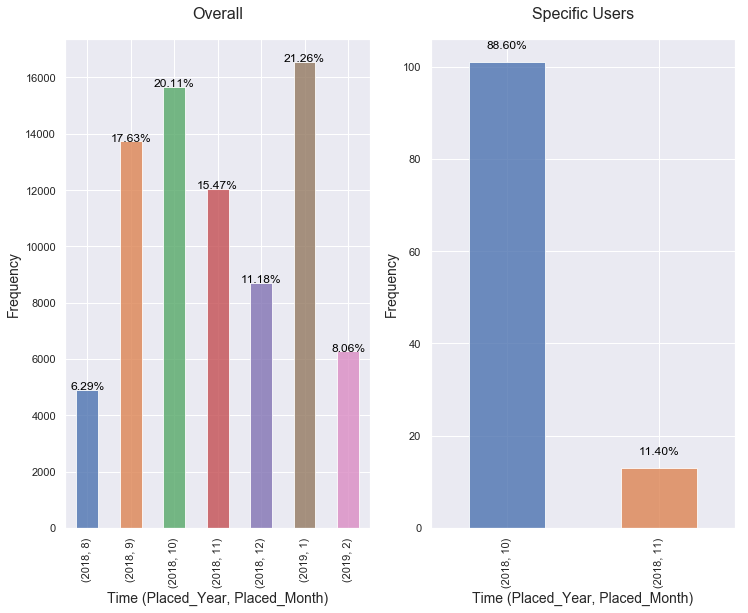

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [402]:
"""
y - Frequency
x - Time : 'Placed_Year', 'Placed_Month'
"""
figsize_tuple = (12, 9) # figure_size

df_overall = df_test
df_black = df_inner_black

groupby_col_1, groupby_col_2 = 'Placed_Year', 'Placed_Month'
sum_or_count_col = "In_Play"
# set_order = []

subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'Frequency'
xlabel_words = 'Time (Placed_Year, Placed_Month)'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

# plot by function
allvsblack_barplot_freq_with2groupedcol(figsize_tuple, df_overall, df_black, groupby_col_1, groupby_col_2, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat)


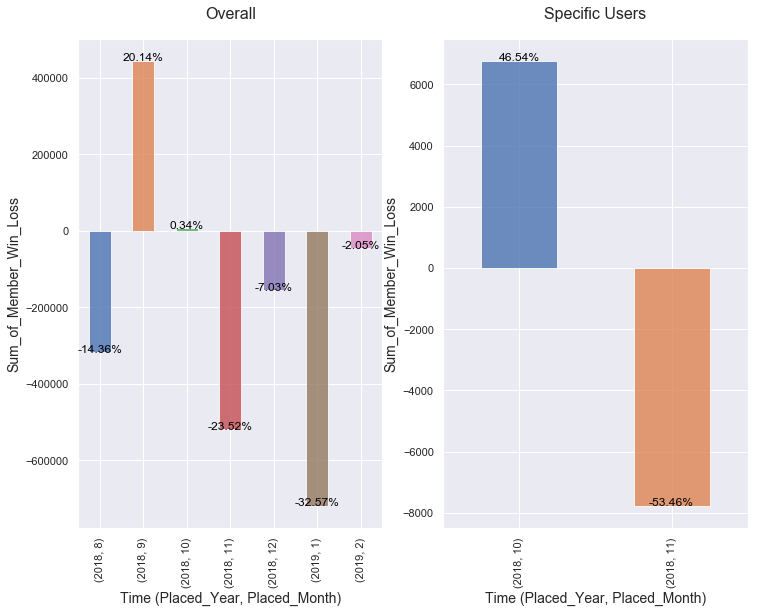

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [403]:
"""
y - Sum_of_Member_Win_Loss
x - Time : 'Placed_Year', 'Placed_Month'
"""
figsize_tuple = (12, 9) # figure_size

df_overall = df_test
df_black = df_inner_black

groupby_col_1, groupby_col_2 = 'Placed_Year', 'Placed_Month'
sum_or_count_col = "Member_Win_Loss"
# set_order = []

subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'Sum_of_Member_Win_Loss'
xlabel_words = 'Time (Placed_Year, Placed_Month)'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

# plot by function
allvsblack_barplot_sum_with2groupedcol(figsize_tuple, df_overall, df_black, groupby_col_1, groupby_col_2, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat)



/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


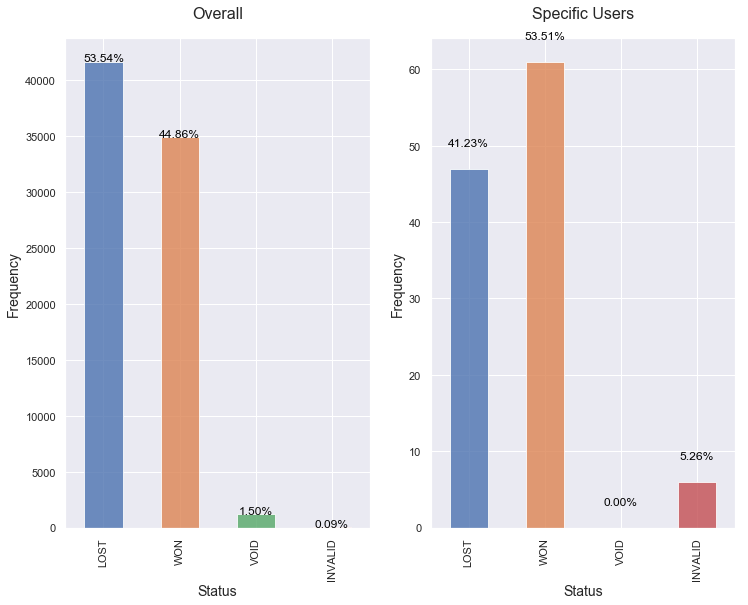

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [404]:
"""
y - Frequency
x - Status
"""
figsize_tuple = (12, 9) # figure_size

df_overall = df_test
df_black = df_inner_black

groupby_col = 'Status'
sum_or_count_col = "Type"
set_order = ["LOST", "WON", "VOID", "INVALID"]

subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'Frequency'
xlabel_words = 'Status'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

# plot by function
allvsblack_barplot_freq(figsize_tuple, set_order, df_overall, df_black, groupby_col, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat)
   

/Users/johnsonhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


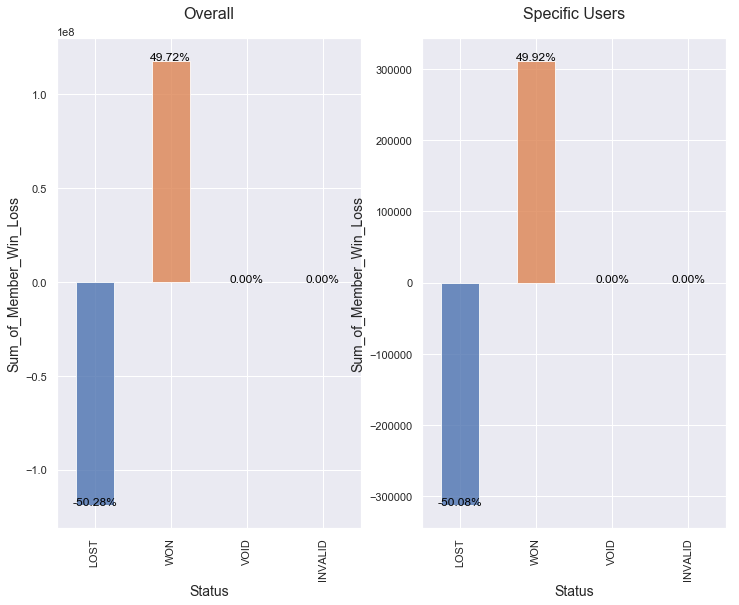

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [405]:
"""
y - Sum_of_Member_Win_Loss
x - Status
"""
figsize_tuple = (12, 9) # figure_size

df_overall = df_test
df_black = df_inner_black

groupby_col = 'Status'
sum_or_count_col = "Member_Win_Loss"
set_order = ["LOST", "WON", "VOID", "INVALID"]

subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'Sum_of_Member_Win_Loss'
xlabel_words = 'Status'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

# plot by function
allvsblack_barplot_sum(figsize_tuple, set_order, df_overall, df_black, groupby_col, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat)
   

In [406]:

# figsize_tuple = (8, 6)
# set_order = ["LOST", "WON", "VOID", "INVALID"]
# df_overall = df_test
# df_black = df_inner_black
# groupby_col = 'Status'
# count_col = "Type_Lay"
# xlabel_words = 'Status (For Type == "Lay")'
# ylabel_words = 'Frequency'

# fontsize = 14     # fontsize of x-axis title  
# font_scale = 10   # font_scale of x-axis  
# xticks_rotat = 90 # xticks_rotatation



# allvsblack_barplot_freq(df_overall, df_black, groupby_col, count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat)



## Scatter plot - Template

In [429]:
def allvsblack_barplot_sum(figsize_tuple, set_order, df_overall, df_black, groupby_col, sum_or_count_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = figsize_tuple)


    set_order = set_order # order of x-axis

    
    # plot 1 - overall
    
#     # other constrains 
#     df_test = df_preprocess.loc[df_preprocess["Type_Lay"] == 1, :]
    
    ax1 = df_overall.groupby([groupby_col]).sum()[sum_or_count_col].loc[set_order].plot(kind = 'bar', ax = ax1, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    # 先分組相加得到各組總和，再apply各組元素得到各個絕對值，再相加得到total
    total = float(df_overall.groupby([groupby_col])[sum_or_count_col].sum().apply(lambda x: abs(x)).sum())
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 
    
    ax1.set_title("Overall", size = subplot_ttl_font, pad = ttl_hight_to_plots)   # fig.suptitle("Overall")
    ax1.set_xlabel(xlabel_words, fontsize = fontsize)
    ax1.set_ylabel(ylabel_words, fontsize = fontsize)   
#     ax1.set_ylim([0, 30000])

    # plot 2 - contrast
#     # other constrains 
#     df_test = df_preprocess.loc[df_preprocess["Type_Back"] == 1, :]
    
    ax2 = df_black.groupby([groupby_col]).sum()[sum_or_count_col].loc[set_order].plot(kind = 'bar', ax = ax2, alpha=0.8) # sns.countplot(df_preprocess['Status'])
    # 分先分組相加得到各組總和，再apply各組元素得到各個絕對值，再相加得到total
    total = float(df_black.groupby([groupby_col])[sum_or_count_col].sum().apply(lambda x: abs(x)).sum())
    for p in ax2.patches:
        height = p.get_height()
        ax2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{0:.2%}'.format(height/total),   # percentage - '{0:.2%}'.format(height/total) ; number - '{}'.format(height)
                ha="center", color = "black") 
    
    ax2.set_title("Specific Users", size = subplot_ttl_font, pad = ttl_hight_to_plots) # fig.suptitle("Specific Users")
    ax2.set_xlabel(xlabel_words, fontsize = fontsize)
    ax2.set_ylabel(ylabel_words, fontsize = fontsize)   
#     ax2.set_ylim([0, 30000])


    # control all plots
#     plt.title("Specific Users")
#     plt.xlim(-0.1, 5)
#     plt.ylim(-0.76, 1.05)
    plt.style.use('ggplot')
    
    sns.set(font_scale = font_scale) # font size
    sns.set(style = "darkgrid")
    plt.xticks(rotation = xticks_rotat) # x-axis 字體方向

    plt.show()
    
    print("Specific Users : \n%s" % inner_blacklist)
    
    
    ax1.set_title("Overall", size = subplot_ttl_font, pad = ttl_hight_to_plots)
    ax2.set_title("Specific Users", size = subplot_ttl_font, pad = ttl_hight_to_plots)
    
    

In [430]:
"""
figsize_tuple = (15, 6) # figure_size

df_overall = df_test
df_black = df_inner_black

y_col = 'AVG_bet_amount_per_person'
x_col = 'Std_bet_amount_per_person'


subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'AVG_bet_amount_per_person (μ)'
xlabel_words = 'Std_bet_amount_per_person (σ)'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

xlim = (-0.5, 5.5)
y_lim = ()
"""

def allvsblack_scatter(figsize_tuple, df_overall, df_black, x_col, y_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat, subplot_ttl_font, ttl_hight_to_plots):



    # plot - scatter plot
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15, 6))


    # plot 1 - overall
    ax1.scatter(df_overall[x_col], df_overall[y_col], marker="o", color="dodgerblue") # c
    ax1.set(xlabel = xlabel_words, ylabel = ylabel_words)
    ax1.set_title("Overall", size = subplot_ttl_font, pad = ttl_hight_to_plots)



    # plot 2 - contrast
    ax2.scatter(df_black[x_col], df_black[y_col], marker="o", color="r")
    ax2.set(xlabel = xlabel_words, ylabel = ylabel_words, xlim = xlim, ylim = ylim)
    ax2.set_title("Specific Users", size = subplot_ttl_font, pad = ttl_hight_to_plots)

    # # legend
    # ax1.legend(["Admitted"])
    # ax2.legend(["Not-Admitted"])

    plt.show()
        
    print("Specific Users : \n%s" % inner_blacklist)
    


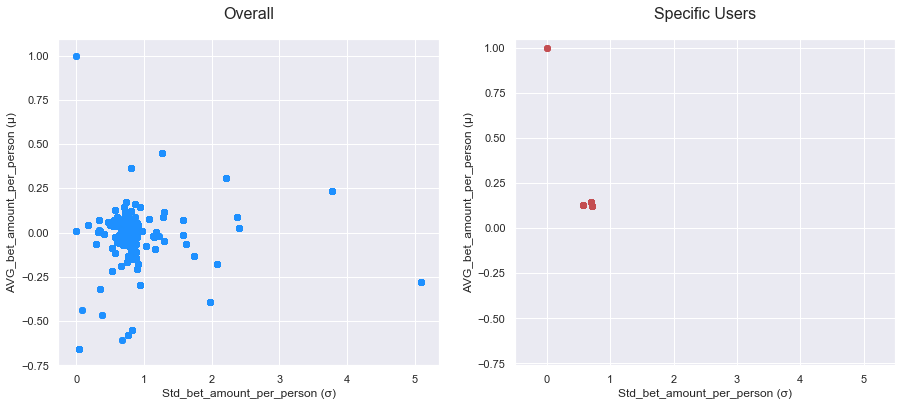

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [432]:

figsize_tuple = (15, 6) # figure_size

df_overall = df_test
df_black = df_inner_black

keyword_1, keyword_2, keyword_3 = "Std", "bet_amount", "σ"    # "Std", "bet_amount", "σ"  ;  "AVG", "bet_amount", "μ"
y_col = 'AVG_bet_amount_per_person'
x_col = f'{keyword_1}_{keyword_2}_per_person'


subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'AVG_bet_amount_per_person (μ)'
xlabel_words = f'{keyword_1}_{keyword_2}_per_person ({keyword_3})'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

xlim = (-0.5, 5.5) # None
ylim = (-0.76, 1.05) # None



allvsblack_scatter(figsize_tuple, df_overall, df_black, x_col, y_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat, subplot_ttl_font, ttl_hight_to_plots)



In [424]:
df_test.columns

Index(['Member', 'Placed', 'Selection', 'Bet_ID', 'In_Play', 'One_Click',
       'Type', 'Odds', 'Stake', 'Status', 'Member_Win_Loss', 'Agent_Win_Loss',
       'MA_Win_Loss', 'CUS_Win_Loss', 'http', 'Mem_Info_1', 'Mem_Info_2',
       'Placed_dt', 'Placed_Year', 'Placed_Month', 'Placed_Date',
       'Placed_Day_of_Week', 'Placed_Hour', 'Placed_Minute', 'Type_Back',
       'Type_Lay', 'Type_No', 'Type_Yes', 'Status_INVALID', 'Status_LOST',
       'Status_VOID', 'Status_WON', 'http_Info_1', 'http_Info_2',
       'http_Info_3', 'win_loss_ratio', 'AVG_bet_amount_per_person',
       'Std_bet_amount_per_person', 'AVG_Odds_per_person',
       'Std_Odds_per_person', 'AVG_Stake_per_person', 'Std_Stake_per_person'],
      dtype='object')

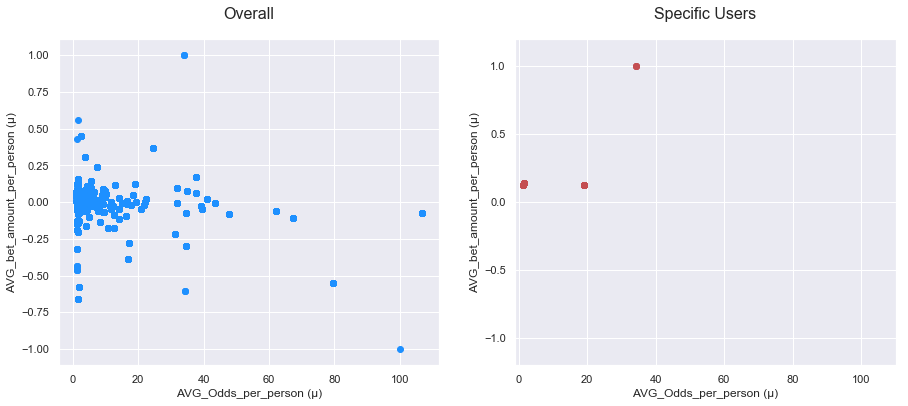

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [437]:

figsize_tuple = (15, 6) # figure_size

df_overall = df_test
df_black = df_inner_black

keyword_1, keyword_2, keyword_3 = "AVG", "Odds", "μ"    # "Std", "bet_amount", "σ"  ;  "AVG", "bet_amount", "μ"
y_col = 'AVG_bet_amount_per_person'
x_col = f'{keyword_1}_{keyword_2}_per_person'


subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'AVG_bet_amount_per_person (μ)'
xlabel_words = f'{keyword_1}_{keyword_2}_per_person ({keyword_3})'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

xlim = (-1, 110)  # None
ylim = (-1.2, 1.2)  # None



allvsblack_scatter(figsize_tuple, df_overall, df_black, x_col, y_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat, subplot_ttl_font, ttl_hight_to_plots)



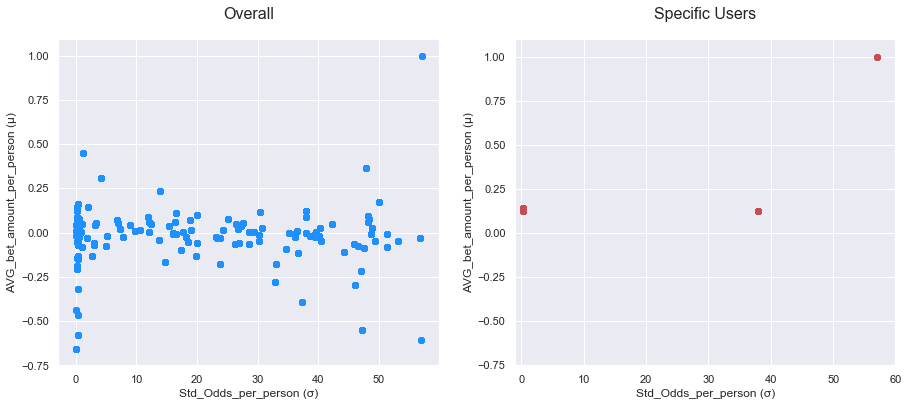

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [439]:

figsize_tuple = (15, 6) # figure_size

df_overall = df_test
df_black = df_inner_black

keyword_1, keyword_2, keyword_3 = "Std", "Odds", "σ"    # "Std", "bet_amount", "σ"  ;  "AVG", "bet_amount", "μ"
y_col = 'AVG_bet_amount_per_person'
x_col = f'{keyword_1}_{keyword_2}_per_person'


subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'AVG_bet_amount_per_person (μ)'
xlabel_words = f'{keyword_1}_{keyword_2}_per_person ({keyword_3})'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

xlim = (-1, 60)  # None
ylim = (-0.75, 1.1)  # None



allvsblack_scatter(figsize_tuple, df_overall, df_black, x_col, y_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat, subplot_ttl_font, ttl_hight_to_plots)



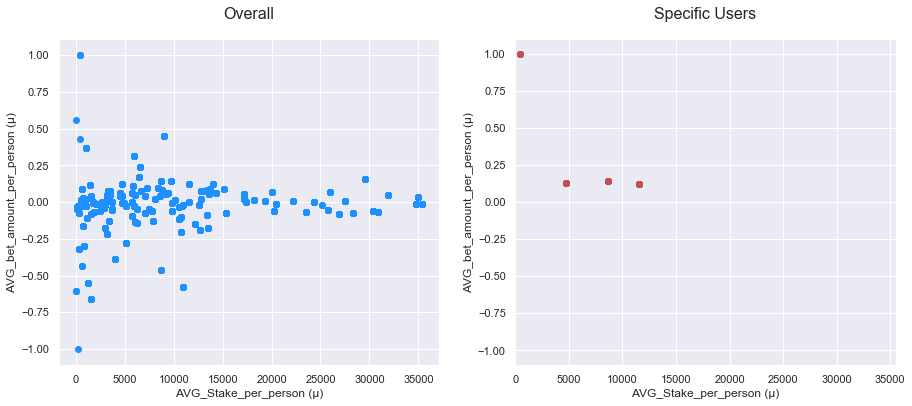

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [440]:

figsize_tuple = (15, 6) # figure_size

df_overall = df_test
df_black = df_inner_black

keyword_1, keyword_2, keyword_3 = "AVG", "Stake", "μ"    # "Std", "bet_amount", "σ"  ;  "AVG", "bet_amount", "μ"
y_col = 'AVG_bet_amount_per_person'
x_col = f'{keyword_1}_{keyword_2}_per_person'


subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'AVG_bet_amount_per_person (μ)'
xlabel_words = f'{keyword_1}_{keyword_2}_per_person ({keyword_3})'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

xlim = (-5, 35500)   # None
ylim = (-1.1, 1.1)   # None



allvsblack_scatter(figsize_tuple, df_overall, df_black, x_col, y_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat, subplot_ttl_font, ttl_hight_to_plots)



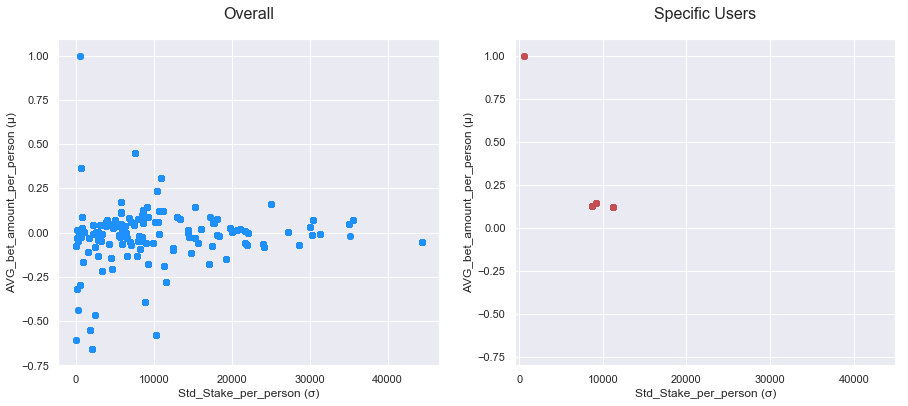

Specific Users : 
['7005 ', '7001 ', 'shitiz ', 'rahul6677 ']


In [446]:

figsize_tuple = (15, 6) # figure_size

df_overall = df_test
df_black = df_inner_black

keyword_1, keyword_2, keyword_3 = "Std", "Stake", "σ"    # "Std", "bet_amount", "σ"  ;  "AVG", "bet_amount", "μ"
y_col = 'AVG_bet_amount_per_person'
x_col = f'{keyword_1}_{keyword_2}_per_person'


subplot_ttl_font = 16   # subplot_title font size       ### fig.suptitle("Overall") 是有多個subplots但統一用一個title
ttl_hight_to_plots = 20 # hight between subplot title & plot

ylabel_words = 'AVG_bet_amount_per_person (μ)'
xlabel_words = f'{keyword_1}_{keyword_2}_per_person ({keyword_3})'

fontsize = 14     # fontsize of x-axis title  
font_scale = 10   # font_scale of x-axis  
xticks_rotat = 90 # xticks_rotatation

xlim = (-500, 45000)   # None
ylim = (-0.8, 1.1)   # None



allvsblack_scatter(figsize_tuple, df_overall, df_black, x_col, y_col, xlabel_words, ylabel_words, fontsize, font_scale, xticks_rotat, subplot_ttl_font, ttl_hight_to_plots)



---------

## Box plot - Template

## Frequency - grouped totalMatched (in 10 bins)

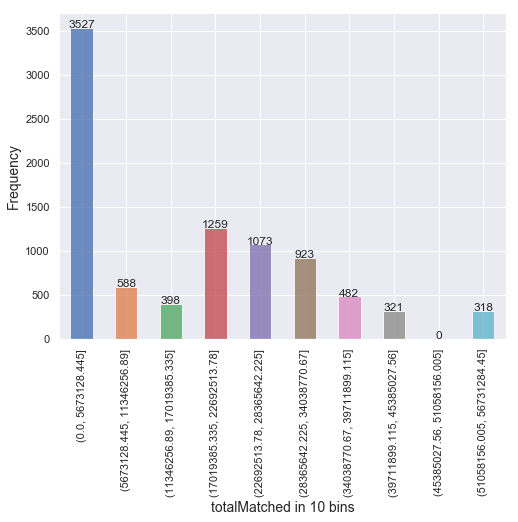

In [91]:
mv = df_preprocess_eventall["totalMatched"].max()
bins = [0, mv*0.1, mv*0.2, mv*0.3, mv*0.4, mv*0.5, mv*0.6, mv*0.7, mv*0.8, mv*0.9, mv]


fig, ax = plt.subplots(figsize=(8, 6))
# count in different bins
ax = df_preprocess_eventall.groupby(pd.cut(df_preprocess_eventall['totalMatched'], bins=bins)).totalMatched.count().plot(kind='bar', alpha=0.8) 

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}'.format(height),   # '{:1.2f}'.format(height/total),
            ha="center") 

ax.set_xlabel('totalMatched in 10 bins',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)   

sns.set(font_scale=3) # font size
sns.set(style="darkgrid")
plt.xticks(rotation=90) # x-axis 字體方向
plt.show()

